In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_0_t1t2_normalized_e_n_e_1_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(722000, 828)
(722000, 8)
validation
(113488, 828)
(113488, 8)
test
(56512, 828)
(56512, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/73 [..............................] - ETA: 1:41 - loss: 2.0074 - STD: 0.0834 - MAE: 0.2091

 4/73 [>.............................] - ETA: 1s - loss: 1.6497 - STD: 0.1458 - MAE: 0.1733  

 5/73 [=>............................] - ETA: 2s - loss: 1.6084 - STD: 0.1604 - MAE: 0.1668

 6/73 [=>............................] - ETA: 2s - loss: 1.5760 - STD: 0.1695 - MAE: 0.1625

 7/73 [=>............................] - ETA: 3s - loss: 1.5547 - STD: 0.1745 - MAE: 0.1600

 8/73 [==>...........................] - ETA: 3s - loss: 1.5370 - STD: 0.1766 - MAE: 0.1588

 9/73 [==>...........................] - ETA: 3s - loss: 1.5241 - STD: 0.1769 - MAE: 0.1584

10/73 [===>..........................] - ETA: 3s - loss: 1.5166 - STD: 0.1763 - MAE: 0.1585

11/73 [===>..........................] - ETA: 3s - loss: 1.5078 - STD: 0.1755 - MAE: 0.1585

12/73 [===>..........................] - ETA: 3s - loss: 1.5015 - STD: 0.1748 - MAE: 0.1586

13/73 [====>.........................] - ETA: 3s - loss: 1.4967 - STD: 0.1746 - MAE: 0.1586

14/73 [====>.........................] - ETA: 3s - loss: 1.4920 - STD: 0.1747 - MAE: 0.1585

15/73 [=====>........................] - ETA: 3s - loss: 1.4867 - STD: 0.1753 - MAE: 0.1582

16/73 [=====>........................] - ETA: 3s - loss: 1.4824 - STD: 0.1760 - MAE: 0.1578

17/73 [=====>........................] - ETA: 3s - loss: 1.4788 - STD: 0.1769 - MAE: 0.1574

18/73 [======>.......................] - ETA: 3s - loss: 1.4750 - STD: 0.1778 - MAE: 0.1569

19/73 [======>.......................] - ETA: 3s - loss: 1.4714 - STD: 0.1786 - MAE: 0.1565

20/73 [=======>......................] - ETA: 3s - loss: 1.4688 - STD: 0.1793 - MAE: 0.1562

21/73 [=======>......................] - ETA: 3s - loss: 1.4652 - STD: 0.1798 - MAE: 0.1559

22/73 [========>.....................] - ETA: 3s - loss: 1.4627 - STD: 0.1801 - MAE: 0.1558

23/73 [========>.....................] - ETA: 3s - loss: 1.4602 - STD: 0.1802 - MAE: 0.1557

24/73 [========>.....................] - ETA: 2s - loss: 1.4576 - STD: 0.1801 - MAE: 0.1557

25/73 [=========>....................] - ETA: 2s - loss: 1.4557 - STD: 0.1799 - MAE: 0.1557

26/73 [=========>....................] - ETA: 2s - loss: 1.4544 - STD: 0.1795 - MAE: 0.1558

27/73 [==========>...................] - ETA: 3s - loss: 1.4541 - STD: 0.1792 - MAE: 0.1559

31/73 [===========>..................] - ETA: 3s - loss: 1.4477 - STD: 0.1782 - MAE: 0.1562

32/73 [============>.................] - ETA: 3s - loss: 1.4460 - STD: 0.1781 - MAE: 0.1562

33/73 [============>.................] - ETA: 2s - loss: 1.4448 - STD: 0.1782 - MAE: 0.1561

34/73 [============>.................] - ETA: 2s - loss: 1.4432 - STD: 0.1783 - MAE: 0.1561

35/73 [=============>................] - ETA: 2s - loss: 1.4414 - STD: 0.1784 - MAE: 0.1560

36/73 [=============>................] - ETA: 2s - loss: 1.4404 - STD: 0.1786 - MAE: 0.1559

37/73 [==============>...............] - ETA: 2s - loss: 1.4396 - STD: 0.1787 - MAE: 0.1558

38/73 [==============>...............] - ETA: 2s - loss: 1.4385 - STD: 0.1788 - MAE: 0.1558

39/73 [===============>..............] - ETA: 2s - loss: 1.4378 - STD: 0.1788 - MAE: 0.1558

40/73 [===============>..............] - ETA: 2s - loss: 1.4371 - STD: 0.1788 - MAE: 0.1558

41/73 [===============>..............] - ETA: 2s - loss: 1.4358 - STD: 0.1787 - MAE: 0.1557

42/73 [================>.............] - ETA: 2s - loss: 1.4349 - STD: 0.1786 - MAE: 0.1558

43/73 [================>.............] - ETA: 2s - loss: 1.4339 - STD: 0.1784 - MAE: 0.1558

44/73 [=================>............] - ETA: 2s - loss: 1.4334 - STD: 0.1783 - MAE: 0.1558

45/73 [=================>............] - ETA: 2s - loss: 1.4324 - STD: 0.1782 - MAE: 0.1558

46/73 [=================>............] - ETA: 1s - loss: 1.4317 - STD: 0.1782 - MAE: 0.1558

47/73 [==================>...........] - ETA: 1s - loss: 1.4310 - STD: 0.1782 - MAE: 0.1558

48/73 [==================>...........] - ETA: 1s - loss: 1.4301 - STD: 0.1782 - MAE: 0.1558

49/73 [===================>..........] - ETA: 1s - loss: 1.4293 - STD: 0.1782 - MAE: 0.1558

50/73 [===================>..........] - ETA: 1s - loss: 1.4283 - STD: 0.1783 - MAE: 0.1557

51/73 [===================>..........] - ETA: 1s - loss: 1.4275 - STD: 0.1783 - MAE: 0.1557

52/73 [====================>.........] - ETA: 1s - loss: 1.4268 - STD: 0.1784 - MAE: 0.1556

53/73 [====================>.........] - ETA: 1s - loss: 1.4266 - STD: 0.1784 - MAE: 0.1556

54/73 [=====================>........] - ETA: 1s - loss: 1.4259 - STD: 0.1784 - MAE: 0.1556

55/73 [=====================>........] - ETA: 1s - loss: 1.4251 - STD: 0.1784 - MAE: 0.1556

56/73 [======================>.......] - ETA: 1s - loss: 1.4243 - STD: 0.1783 - MAE: 0.1555

57/73 [======================>.......] - ETA: 1s - loss: 1.4239 - STD: 0.1783 - MAE: 0.1556

58/73 [======================>.......] - ETA: 1s - loss: 1.4235 - STD: 0.1783 - MAE: 0.1556

59/73 [=======================>......] - ETA: 0s - loss: 1.4227 - STD: 0.1782 - MAE: 0.1555

60/73 [=======================>......] - ETA: 0s - loss: 1.4221 - STD: 0.1782 - MAE: 0.1555

61/73 [========================>.....] - ETA: 0s - loss: 1.4213 - STD: 0.1782 - MAE: 0.1555

62/73 [========================>.....] - ETA: 0s - loss: 1.4206 - STD: 0.1783 - MAE: 0.1554

63/73 [========================>.....] - ETA: 0s - loss: 1.4198 - STD: 0.1783 - MAE: 0.1554

64/73 [=========================>....] - ETA: 0s - loss: 1.4192 - STD: 0.1783 - MAE: 0.1554

65/73 [=========================>....] - ETA: 0s - loss: 1.4185 - STD: 0.1783 - MAE: 0.1553

66/73 [==========================>...] - ETA: 0s - loss: 1.4180 - STD: 0.1783 - MAE: 0.1553

67/73 [==========================>...] - ETA: 0s - loss: 1.4171 - STD: 0.1783 - MAE: 0.1553

68/73 [==========================>...] - ETA: 0s - loss: 1.4161 - STD: 0.1783 - MAE: 0.1552

69/73 [===========================>..] - ETA: 0s - loss: 1.4153 - STD: 0.1783 - MAE: 0.1552

70/73 [===========================>..] - ETA: 0s - loss: 1.4142 - STD: 0.1783 - MAE: 0.1552

71/73 [============================>.] - ETA: 0s - loss: 1.4131 - STD: 0.1784 - MAE: 0.1551

72/73 [============================>.] - ETA: 0s - loss: 1.4121 - STD: 0.1784 - MAE: 0.1550

73/73 [==============================] - ETA: 0s - loss: 1.4112 - STD: 0.1785 - MAE: 0.1550

73/73 [==============================] - 7s 80ms/step - loss: 1.4112 - STD: 0.1785 - MAE: 0.1550 - val_loss: 1.3606 - val_STD: 0.1772 - val_MAE: 0.1533


Epoch 2/10000


 1/73 [..............................] - ETA: 7s - loss: 1.3394 - STD: 0.1819 - MAE: 0.1504

 2/73 [..............................] - ETA: 4s - loss: 1.3422 - STD: 0.1812 - MAE: 0.1508

 3/73 [>.............................] - ETA: 4s - loss: 1.3408 - STD: 0.1807 - MAE: 0.1510

 4/73 [>.............................] - ETA: 4s - loss: 1.3412 - STD: 0.1811 - MAE: 0.1508

 5/73 [=>............................] - ETA: 4s - loss: 1.3443 - STD: 0.1821 - MAE: 0.1507

 6/73 [=>............................] - ETA: 4s - loss: 1.3414 - STD: 0.1827 - MAE: 0.1504

 7/73 [=>............................] - ETA: 4s - loss: 1.3385 - STD: 0.1829 - MAE: 0.1502

 8/73 [==>...........................] - ETA: 4s - loss: 1.3367 - STD: 0.1830 - MAE: 0.1501

 9/73 [==>...........................] - ETA: 4s - loss: 1.3342 - STD: 0.1834 - MAE: 0.1498

10/73 [===>..........................] - ETA: 4s - loss: 1.3327 - STD: 0.1840 - MAE: 0.1496

11/73 [===>..........................] - ETA: 4s - loss: 1.3297 - STD: 0.1844 - MAE: 0.1493

12/73 [===>..........................] - ETA: 4s - loss: 1.3295 - STD: 0.1847 - MAE: 0.1493

13/73 [====>.........................] - ETA: 3s - loss: 1.3266 - STD: 0.1848 - MAE: 0.1491

14/73 [====>.........................] - ETA: 3s - loss: 1.3270 - STD: 0.1850 - MAE: 0.1491

15/73 [=====>........................] - ETA: 3s - loss: 1.3252 - STD: 0.1850 - MAE: 0.1490

16/73 [=====>........................] - ETA: 3s - loss: 1.3245 - STD: 0.1850 - MAE: 0.1491

17/73 [=====>........................] - ETA: 3s - loss: 1.3243 - STD: 0.1850 - MAE: 0.1491

18/73 [======>.......................] - ETA: 3s - loss: 1.3237 - STD: 0.1850 - MAE: 0.1491

19/73 [======>.......................] - ETA: 3s - loss: 1.3217 - STD: 0.1852 - MAE: 0.1489

20/73 [=======>......................] - ETA: 3s - loss: 1.3199 - STD: 0.1856 - MAE: 0.1487

21/73 [=======>......................] - ETA: 3s - loss: 1.3189 - STD: 0.1860 - MAE: 0.1486

22/73 [========>.....................] - ETA: 3s - loss: 1.3181 - STD: 0.1861 - MAE: 0.1485

23/73 [========>.....................] - ETA: 3s - loss: 1.3162 - STD: 0.1860 - MAE: 0.1485

24/73 [========>.....................] - ETA: 3s - loss: 1.3150 - STD: 0.1860 - MAE: 0.1485

25/73 [=========>....................] - ETA: 3s - loss: 1.3140 - STD: 0.1863 - MAE: 0.1483

26/73 [=========>....................] - ETA: 3s - loss: 1.3133 - STD: 0.1865 - MAE: 0.1483

27/73 [==========>...................] - ETA: 3s - loss: 1.3122 - STD: 0.1864 - MAE: 0.1483

28/73 [==========>...................] - ETA: 2s - loss: 1.3112 - STD: 0.1863 - MAE: 0.1483

29/73 [==========>...................] - ETA: 2s - loss: 1.3089 - STD: 0.1864 - MAE: 0.1482

30/73 [===========>..................] - ETA: 2s - loss: 1.3080 - STD: 0.1867 - MAE: 0.1481

31/73 [===========>..................] - ETA: 2s - loss: 1.3064 - STD: 0.1869 - MAE: 0.1480

32/73 [============>.................] - ETA: 2s - loss: 1.3052 - STD: 0.1868 - MAE: 0.1479

33/73 [============>.................] - ETA: 2s - loss: 1.3036 - STD: 0.1868 - MAE: 0.1479

34/73 [============>.................] - ETA: 2s - loss: 1.3025 - STD: 0.1870 - MAE: 0.1478

35/73 [=============>................] - ETA: 2s - loss: 1.3016 - STD: 0.1873 - MAE: 0.1477

36/73 [=============>................] - ETA: 2s - loss: 1.2998 - STD: 0.1874 - MAE: 0.1476

37/73 [==============>...............] - ETA: 2s - loss: 1.2989 - STD: 0.1873 - MAE: 0.1476

38/73 [==============>...............] - ETA: 2s - loss: 1.2977 - STD: 0.1873 - MAE: 0.1475

39/73 [===============>..............] - ETA: 2s - loss: 1.2964 - STD: 0.1875 - MAE: 0.1475

40/73 [===============>..............] - ETA: 2s - loss: 1.2952 - STD: 0.1877 - MAE: 0.1474

41/73 [===============>..............] - ETA: 2s - loss: 1.2943 - STD: 0.1877 - MAE: 0.1473

42/73 [================>.............] - ETA: 2s - loss: 1.2930 - STD: 0.1876 - MAE: 0.1473

43/73 [================>.............] - ETA: 1s - loss: 1.2917 - STD: 0.1877 - MAE: 0.1473

44/73 [=================>............] - ETA: 1s - loss: 1.2907 - STD: 0.1879 - MAE: 0.1472

45/73 [=================>............] - ETA: 1s - loss: 1.2896 - STD: 0.1879 - MAE: 0.1471

47/73 [==================>...........] - ETA: 1s - loss: 1.2878 - STD: 0.1879 - MAE: 0.1470

48/73 [==================>...........] - ETA: 1s - loss: 1.2867 - STD: 0.1881 - MAE: 0.1469

49/73 [===================>..........] - ETA: 1s - loss: 1.2854 - STD: 0.1883 - MAE: 0.1468

50/73 [===================>..........] - ETA: 1s - loss: 1.2845 - STD: 0.1883 - MAE: 0.1468

51/73 [===================>..........] - ETA: 1s - loss: 1.2831 - STD: 0.1883 - MAE: 0.1468

52/73 [====================>.........] - ETA: 1s - loss: 1.2816 - STD: 0.1883 - MAE: 0.1467

53/73 [====================>.........] - ETA: 1s - loss: 1.2809 - STD: 0.1885 - MAE: 0.1466

54/73 [=====================>........] - ETA: 1s - loss: 1.2798 - STD: 0.1886 - MAE: 0.1466

55/73 [=====================>........] - ETA: 1s - loss: 1.2786 - STD: 0.1886 - MAE: 0.1465

56/73 [======================>.......] - ETA: 1s - loss: 1.2776 - STD: 0.1886 - MAE: 0.1465

57/73 [======================>.......] - ETA: 1s - loss: 1.2766 - STD: 0.1886 - MAE: 0.1465

58/73 [======================>.......] - ETA: 0s - loss: 1.2756 - STD: 0.1887 - MAE: 0.1464

59/73 [=======================>......] - ETA: 0s - loss: 1.2745 - STD: 0.1888 - MAE: 0.1464

60/73 [=======================>......] - ETA: 0s - loss: 1.2735 - STD: 0.1888 - MAE: 0.1463

61/73 [========================>.....] - ETA: 0s - loss: 1.2726 - STD: 0.1888 - MAE: 0.1463

62/73 [========================>.....] - ETA: 0s - loss: 1.2715 - STD: 0.1889 - MAE: 0.1462

63/73 [========================>.....] - ETA: 0s - loss: 1.2701 - STD: 0.1890 - MAE: 0.1461

64/73 [=========================>....] - ETA: 0s - loss: 1.2689 - STD: 0.1891 - MAE: 0.1461

65/73 [=========================>....] - ETA: 0s - loss: 1.2678 - STD: 0.1892 - MAE: 0.1460

66/73 [==========================>...] - ETA: 0s - loss: 1.2668 - STD: 0.1893 - MAE: 0.1459

67/73 [==========================>...] - ETA: 0s - loss: 1.2662 - STD: 0.1893 - MAE: 0.1459

68/73 [==========================>...] - ETA: 0s - loss: 1.2650 - STD: 0.1893 - MAE: 0.1459

69/73 [===========================>..] - ETA: 0s - loss: 1.2639 - STD: 0.1893 - MAE: 0.1459

70/73 [===========================>..] - ETA: 0s - loss: 1.2628 - STD: 0.1893 - MAE: 0.1458

71/73 [============================>.] - ETA: 0s - loss: 1.2620 - STD: 0.1895 - MAE: 0.1457

72/73 [============================>.] - ETA: 0s - loss: 1.2611 - STD: 0.1896 - MAE: 0.1457

73/73 [==============================] - ETA: 0s - loss: 1.2601 - STD: 0.1896 - MAE: 0.1456

73/73 [==============================] - 5s 69ms/step - loss: 1.2601 - STD: 0.1896 - MAE: 0.1456 - val_loss: 1.1979 - val_STD: 0.1792 - val_MAE: 0.1474


Epoch 3/10000


 1/73 [..............................] - ETA: 7s - loss: 1.1804 - STD: 0.1911 - MAE: 0.1427

 2/73 [..............................] - ETA: 5s - loss: 1.1746 - STD: 0.1916 - MAE: 0.1421

 3/73 [>.............................] - ETA: 4s - loss: 1.1710 - STD: 0.1930 - MAE: 0.1414

 4/73 [>.............................] - ETA: 4s - loss: 1.1740 - STD: 0.1948 - MAE: 0.1409

 5/73 [=>............................] - ETA: 4s - loss: 1.1736 - STD: 0.1955 - MAE: 0.1406

 6/73 [=>............................] - ETA: 4s - loss: 1.1722 - STD: 0.1953 - MAE: 0.1406

 7/73 [=>............................] - ETA: 4s - loss: 1.1706 - STD: 0.1950 - MAE: 0.1407

 8/73 [==>...........................] - ETA: 4s - loss: 1.1685 - STD: 0.1950 - MAE: 0.1406

 9/73 [==>...........................] - ETA: 4s - loss: 1.1684 - STD: 0.1953 - MAE: 0.1405

10/73 [===>..........................] - ETA: 4s - loss: 1.1659 - STD: 0.1955 - MAE: 0.1403

11/73 [===>..........................] - ETA: 4s - loss: 1.1646 - STD: 0.1954 - MAE: 0.1403

12/73 [===>..........................] - ETA: 4s - loss: 1.1658 - STD: 0.1955 - MAE: 0.1403

13/73 [====>.........................] - ETA: 4s - loss: 1.1636 - STD: 0.1955 - MAE: 0.1402

14/73 [====>.........................] - ETA: 4s - loss: 1.1624 - STD: 0.1957 - MAE: 0.1401

15/73 [=====>........................] - ETA: 3s - loss: 1.1614 - STD: 0.1960 - MAE: 0.1400

16/73 [=====>........................] - ETA: 3s - loss: 1.1595 - STD: 0.1961 - MAE: 0.1398

17/73 [=====>........................] - ETA: 3s - loss: 1.1578 - STD: 0.1962 - MAE: 0.1397

18/73 [======>.......................] - ETA: 3s - loss: 1.1569 - STD: 0.1965 - MAE: 0.1396

19/73 [======>.......................] - ETA: 3s - loss: 1.1556 - STD: 0.1966 - MAE: 0.1395

20/73 [=======>......................] - ETA: 3s - loss: 1.1539 - STD: 0.1964 - MAE: 0.1395

21/73 [=======>......................] - ETA: 3s - loss: 1.1531 - STD: 0.1965 - MAE: 0.1395

22/73 [========>.....................] - ETA: 3s - loss: 1.1519 - STD: 0.1971 - MAE: 0.1392

23/73 [========>.....................] - ETA: 3s - loss: 1.1508 - STD: 0.1971 - MAE: 0.1392

24/73 [========>.....................] - ETA: 3s - loss: 1.1496 - STD: 0.1969 - MAE: 0.1392

25/73 [=========>....................] - ETA: 3s - loss: 1.1491 - STD: 0.1972 - MAE: 0.1391

26/73 [=========>....................] - ETA: 3s - loss: 1.1489 - STD: 0.1976 - MAE: 0.1389

27/73 [==========>...................] - ETA: 3s - loss: 1.1484 - STD: 0.1976 - MAE: 0.1389

28/73 [==========>...................] - ETA: 3s - loss: 1.1468 - STD: 0.1974 - MAE: 0.1389

29/73 [==========>...................] - ETA: 3s - loss: 1.1460 - STD: 0.1976 - MAE: 0.1388

30/73 [===========>..................] - ETA: 2s - loss: 1.1451 - STD: 0.1981 - MAE: 0.1386

31/73 [===========>..................] - ETA: 2s - loss: 1.1444 - STD: 0.1982 - MAE: 0.1385

32/73 [============>.................] - ETA: 2s - loss: 1.1437 - STD: 0.1979 - MAE: 0.1386

33/73 [============>.................] - ETA: 2s - loss: 1.1427 - STD: 0.1979 - MAE: 0.1386

34/73 [============>.................] - ETA: 2s - loss: 1.1421 - STD: 0.1984 - MAE: 0.1384

35/73 [=============>................] - ETA: 2s - loss: 1.1413 - STD: 0.1987 - MAE: 0.1382

36/73 [=============>................] - ETA: 2s - loss: 1.1406 - STD: 0.1986 - MAE: 0.1383

37/73 [==============>...............] - ETA: 2s - loss: 1.1400 - STD: 0.1984 - MAE: 0.1383

38/73 [==============>...............] - ETA: 2s - loss: 1.1397 - STD: 0.1984 - MAE: 0.1383

40/73 [===============>..............] - ETA: 2s - loss: 1.1390 - STD: 0.1988 - MAE: 0.1381

41/73 [===============>..............] - ETA: 2s - loss: 1.1381 - STD: 0.1987 - MAE: 0.1382

42/73 [================>.............] - ETA: 2s - loss: 1.1373 - STD: 0.1987 - MAE: 0.1382

43/73 [================>.............] - ETA: 1s - loss: 1.1363 - STD: 0.1990 - MAE: 0.1380

44/73 [=================>............] - ETA: 1s - loss: 1.1355 - STD: 0.1993 - MAE: 0.1378

45/73 [=================>............] - ETA: 1s - loss: 1.1345 - STD: 0.1992 - MAE: 0.1378

46/73 [=================>............] - ETA: 1s - loss: 1.1336 - STD: 0.1991 - MAE: 0.1378

47/73 [==================>...........] - ETA: 1s - loss: 1.1326 - STD: 0.1993 - MAE: 0.1377

48/73 [==================>...........] - ETA: 1s - loss: 1.1316 - STD: 0.1996 - MAE: 0.1375

49/73 [===================>..........] - ETA: 1s - loss: 1.1307 - STD: 0.1997 - MAE: 0.1375

50/73 [===================>..........] - ETA: 1s - loss: 1.1300 - STD: 0.1995 - MAE: 0.1375

51/73 [===================>..........] - ETA: 1s - loss: 1.1292 - STD: 0.1997 - MAE: 0.1374

52/73 [====================>.........] - ETA: 1s - loss: 1.1285 - STD: 0.1999 - MAE: 0.1373

53/73 [====================>.........] - ETA: 1s - loss: 1.1276 - STD: 0.2000 - MAE: 0.1372

54/73 [=====================>........] - ETA: 1s - loss: 1.1271 - STD: 0.2000 - MAE: 0.1372

55/73 [=====================>........] - ETA: 1s - loss: 1.1264 - STD: 0.2000 - MAE: 0.1372

56/73 [======================>.......] - ETA: 1s - loss: 1.1258 - STD: 0.2002 - MAE: 0.1371

57/73 [======================>.......] - ETA: 1s - loss: 1.1253 - STD: 0.2002 - MAE: 0.1371

58/73 [======================>.......] - ETA: 0s - loss: 1.1248 - STD: 0.2002 - MAE: 0.1371

59/73 [=======================>......] - ETA: 0s - loss: 1.1242 - STD: 0.2003 - MAE: 0.1370

60/73 [=======================>......] - ETA: 0s - loss: 1.1233 - STD: 0.2004 - MAE: 0.1369

61/73 [========================>.....] - ETA: 0s - loss: 1.1230 - STD: 0.2005 - MAE: 0.1369

62/73 [========================>.....] - ETA: 0s - loss: 1.1227 - STD: 0.2005 - MAE: 0.1369

63/73 [========================>.....] - ETA: 0s - loss: 1.1219 - STD: 0.2005 - MAE: 0.1368

64/73 [=========================>....] - ETA: 0s - loss: 1.1213 - STD: 0.2008 - MAE: 0.1367

65/73 [=========================>....] - ETA: 0s - loss: 1.1206 - STD: 0.2008 - MAE: 0.1367

66/73 [==========================>...] - ETA: 0s - loss: 1.1199 - STD: 0.2008 - MAE: 0.1366

67/73 [==========================>...] - ETA: 0s - loss: 1.1196 - STD: 0.2010 - MAE: 0.1365

68/73 [==========================>...] - ETA: 0s - loss: 1.1187 - STD: 0.2010 - MAE: 0.1365

69/73 [===========================>..] - ETA: 0s - loss: 1.1180 - STD: 0.2011 - MAE: 0.1364

70/73 [===========================>..] - ETA: 0s - loss: 1.1172 - STD: 0.2012 - MAE: 0.1363

71/73 [============================>.] - ETA: 0s - loss: 1.1165 - STD: 0.2013 - MAE: 0.1363

72/73 [============================>.] - ETA: 0s - loss: 1.1157 - STD: 0.2012 - MAE: 0.1363

73/73 [==============================] - ETA: 0s - loss: 1.1149 - STD: 0.2014 - MAE: 0.1362

73/73 [==============================] - 5s 70ms/step - loss: 1.1149 - STD: 0.2014 - MAE: 0.1362 - val_loss: 1.0522 - val_STD: 0.1997 - val_MAE: 0.1339


Epoch 4/10000


 1/73 [..............................] - ETA: 7s - loss: 1.0806 - STD: 0.2108 - MAE: 0.1312

 2/73 [..............................] - ETA: 5s - loss: 1.0825 - STD: 0.2034 - MAE: 0.1343

 3/73 [>.............................] - ETA: 4s - loss: 1.0790 - STD: 0.2045 - MAE: 0.1335

 4/73 [>.............................] - ETA: 4s - loss: 1.0737 - STD: 0.2078 - MAE: 0.1319

 5/73 [=>............................] - ETA: 4s - loss: 1.0722 - STD: 0.2070 - MAE: 0.1321

 6/73 [=>............................] - ETA: 4s - loss: 1.0712 - STD: 0.2066 - MAE: 0.1322

 7/73 [=>............................] - ETA: 4s - loss: 1.0686 - STD: 0.2076 - MAE: 0.1316

 8/73 [==>...........................] - ETA: 4s - loss: 1.0674 - STD: 0.2076 - MAE: 0.1316

 9/73 [==>...........................] - ETA: 4s - loss: 1.0662 - STD: 0.2076 - MAE: 0.1315

10/73 [===>..........................] - ETA: 4s - loss: 1.0654 - STD: 0.2074 - MAE: 0.1316

11/73 [===>..........................] - ETA: 4s - loss: 1.0651 - STD: 0.2077 - MAE: 0.1314

12/73 [===>..........................] - ETA: 4s - loss: 1.0636 - STD: 0.2078 - MAE: 0.1313

13/73 [====>.........................] - ETA: 4s - loss: 1.0628 - STD: 0.2076 - MAE: 0.1314

14/73 [====>.........................] - ETA: 4s - loss: 1.0606 - STD: 0.2077 - MAE: 0.1312

15/73 [=====>........................] - ETA: 3s - loss: 1.0589 - STD: 0.2080 - MAE: 0.1310

16/73 [=====>........................] - ETA: 3s - loss: 1.0590 - STD: 0.2080 - MAE: 0.1310

17/73 [=====>........................] - ETA: 3s - loss: 1.0588 - STD: 0.2077 - MAE: 0.1311

18/73 [======>.......................] - ETA: 3s - loss: 1.0577 - STD: 0.2078 - MAE: 0.1311

19/73 [======>.......................] - ETA: 3s - loss: 1.0569 - STD: 0.2082 - MAE: 0.1309

20/73 [=======>......................] - ETA: 3s - loss: 1.0573 - STD: 0.2082 - MAE: 0.1309

21/73 [=======>......................] - ETA: 3s - loss: 1.0571 - STD: 0.2076 - MAE: 0.1311

22/73 [========>.....................] - ETA: 3s - loss: 1.0560 - STD: 0.2081 - MAE: 0.1308

23/73 [========>.....................] - ETA: 3s - loss: 1.0559 - STD: 0.2084 - MAE: 0.1307

24/73 [========>.....................] - ETA: 3s - loss: 1.0556 - STD: 0.2078 - MAE: 0.1309

25/73 [=========>....................] - ETA: 3s - loss: 1.0548 - STD: 0.2081 - MAE: 0.1308

26/73 [=========>....................] - ETA: 3s - loss: 1.0545 - STD: 0.2084 - MAE: 0.1307

27/73 [==========>...................] - ETA: 3s - loss: 1.0544 - STD: 0.2082 - MAE: 0.1307

28/73 [==========>...................] - ETA: 3s - loss: 1.0543 - STD: 0.2083 - MAE: 0.1307

29/73 [==========>...................] - ETA: 3s - loss: 1.0537 - STD: 0.2083 - MAE: 0.1307

30/73 [===========>..................] - ETA: 2s - loss: 1.0531 - STD: 0.2084 - MAE: 0.1306

31/73 [===========>..................] - ETA: 2s - loss: 1.0524 - STD: 0.2085 - MAE: 0.1305

32/73 [============>.................] - ETA: 2s - loss: 1.0519 - STD: 0.2083 - MAE: 0.1306

33/73 [============>.................] - ETA: 2s - loss: 1.0511 - STD: 0.2084 - MAE: 0.1305

34/73 [============>.................] - ETA: 2s - loss: 1.0503 - STD: 0.2089 - MAE: 0.1303

35/73 [=============>................] - ETA: 2s - loss: 1.0500 - STD: 0.2086 - MAE: 0.1304

37/73 [==============>...............] - ETA: 2s - loss: 1.0497 - STD: 0.2089 - MAE: 0.1302

38/73 [==============>...............] - ETA: 2s - loss: 1.0497 - STD: 0.2089 - MAE: 0.1302

39/73 [===============>..............] - ETA: 2s - loss: 1.0488 - STD: 0.2086 - MAE: 0.1303

40/73 [===============>..............] - ETA: 2s - loss: 1.0480 - STD: 0.2088 - MAE: 0.1302

41/73 [===============>..............] - ETA: 2s - loss: 1.0474 - STD: 0.2090 - MAE: 0.1301

42/73 [================>.............] - ETA: 2s - loss: 1.0467 - STD: 0.2092 - MAE: 0.1299

43/73 [================>.............] - ETA: 2s - loss: 1.0461 - STD: 0.2091 - MAE: 0.1300

44/73 [=================>............] - ETA: 1s - loss: 1.0458 - STD: 0.2090 - MAE: 0.1300

45/73 [=================>............] - ETA: 1s - loss: 1.0452 - STD: 0.2092 - MAE: 0.1299

46/73 [=================>............] - ETA: 1s - loss: 1.0446 - STD: 0.2095 - MAE: 0.1297

47/73 [==================>...........] - ETA: 1s - loss: 1.0437 - STD: 0.2095 - MAE: 0.1297

48/73 [==================>...........] - ETA: 1s - loss: 1.0430 - STD: 0.2094 - MAE: 0.1297

49/73 [===================>..........] - ETA: 1s - loss: 1.0424 - STD: 0.2095 - MAE: 0.1296

50/73 [===================>..........] - ETA: 1s - loss: 1.0418 - STD: 0.2098 - MAE: 0.1295

51/73 [===================>..........] - ETA: 1s - loss: 1.0413 - STD: 0.2098 - MAE: 0.1295

52/73 [====================>.........] - ETA: 1s - loss: 1.0405 - STD: 0.2098 - MAE: 0.1294

53/73 [====================>.........] - ETA: 1s - loss: 1.0399 - STD: 0.2099 - MAE: 0.1294

54/73 [=====================>........] - ETA: 1s - loss: 1.0394 - STD: 0.2099 - MAE: 0.1293

55/73 [=====================>........] - ETA: 1s - loss: 1.0391 - STD: 0.2100 - MAE: 0.1293

56/73 [======================>.......] - ETA: 1s - loss: 1.0387 - STD: 0.2101 - MAE: 0.1292

57/73 [======================>.......] - ETA: 1s - loss: 1.0381 - STD: 0.2100 - MAE: 0.1292

58/73 [======================>.......] - ETA: 1s - loss: 1.0373 - STD: 0.2100 - MAE: 0.1292

59/73 [=======================>......] - ETA: 0s - loss: 1.0366 - STD: 0.2103 - MAE: 0.1291

60/73 [=======================>......] - ETA: 0s - loss: 1.0359 - STD: 0.2103 - MAE: 0.1290

61/73 [========================>.....] - ETA: 0s - loss: 1.0354 - STD: 0.2102 - MAE: 0.1291

62/73 [========================>.....] - ETA: 0s - loss: 1.0348 - STD: 0.2103 - MAE: 0.1290

63/73 [========================>.....] - ETA: 0s - loss: 1.0342 - STD: 0.2104 - MAE: 0.1289

64/73 [=========================>....] - ETA: 0s - loss: 1.0338 - STD: 0.2105 - MAE: 0.1289

65/73 [=========================>....] - ETA: 0s - loss: 1.0333 - STD: 0.2105 - MAE: 0.1288

66/73 [==========================>...] - ETA: 0s - loss: 1.0328 - STD: 0.2105 - MAE: 0.1288

67/73 [==========================>...] - ETA: 0s - loss: 1.0322 - STD: 0.2105 - MAE: 0.1288

68/73 [==========================>...] - ETA: 0s - loss: 1.0314 - STD: 0.2107 - MAE: 0.1287

69/73 [===========================>..] - ETA: 0s - loss: 1.0310 - STD: 0.2109 - MAE: 0.1286

70/73 [===========================>..] - ETA: 0s - loss: 1.0303 - STD: 0.2108 - MAE: 0.1286

71/73 [============================>.] - ETA: 0s - loss: 1.0296 - STD: 0.2108 - MAE: 0.1286

72/73 [============================>.] - ETA: 0s - loss: 1.0291 - STD: 0.2110 - MAE: 0.1284

73/73 [==============================] - ETA: 0s - loss: 1.0287 - STD: 0.2111 - MAE: 0.1284

73/73 [==============================] - 5s 71ms/step - loss: 1.0287 - STD: 0.2111 - MAE: 0.1284 - val_loss: 0.9704 - val_STD: 0.1975 - val_MAE: 0.1311


Epoch 5/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9927 - STD: 0.2078 - MAE: 0.1284

 2/73 [..............................] - ETA: 4s - loss: 0.9946 - STD: 0.2141 - MAE: 0.1259

 3/73 [>.............................] - ETA: 4s - loss: 0.9934 - STD: 0.2135 - MAE: 0.1261

 4/73 [>.............................] - ETA: 4s - loss: 0.9894 - STD: 0.2132 - MAE: 0.1259

 5/73 [=>............................] - ETA: 4s - loss: 0.9883 - STD: 0.2157 - MAE: 0.1248

 6/73 [=>............................] - ETA: 4s - loss: 0.9878 - STD: 0.2155 - MAE: 0.1249

 7/73 [=>............................] - ETA: 4s - loss: 0.9872 - STD: 0.2142 - MAE: 0.1254

 8/73 [==>...........................] - ETA: 4s - loss: 0.9877 - STD: 0.2147 - MAE: 0.1252

 9/73 [==>...........................] - ETA: 4s - loss: 0.9869 - STD: 0.2159 - MAE: 0.1246

10/73 [===>..........................] - ETA: 4s - loss: 0.9861 - STD: 0.2156 - MAE: 0.1248

11/73 [===>..........................] - ETA: 4s - loss: 0.9859 - STD: 0.2147 - MAE: 0.1251

12/73 [===>..........................] - ETA: 4s - loss: 0.9841 - STD: 0.2150 - MAE: 0.1249

13/73 [====>.........................] - ETA: 4s - loss: 0.9853 - STD: 0.2160 - MAE: 0.1245

14/73 [====>.........................] - ETA: 4s - loss: 0.9841 - STD: 0.2157 - MAE: 0.1246

15/73 [=====>........................] - ETA: 3s - loss: 0.9842 - STD: 0.2150 - MAE: 0.1250

16/73 [=====>........................] - ETA: 3s - loss: 0.9841 - STD: 0.2153 - MAE: 0.1248

17/73 [=====>........................] - ETA: 3s - loss: 0.9841 - STD: 0.2157 - MAE: 0.1246

18/73 [======>.......................] - ETA: 3s - loss: 0.9838 - STD: 0.2158 - MAE: 0.1246

19/73 [======>.......................] - ETA: 3s - loss: 0.9839 - STD: 0.2154 - MAE: 0.1247

20/73 [=======>......................] - ETA: 3s - loss: 0.9840 - STD: 0.2154 - MAE: 0.1247

21/73 [=======>......................] - ETA: 3s - loss: 0.9840 - STD: 0.2156 - MAE: 0.1247

22/73 [========>.....................] - ETA: 3s - loss: 0.9834 - STD: 0.2157 - MAE: 0.1246

23/73 [========>.....................] - ETA: 3s - loss: 0.9829 - STD: 0.2157 - MAE: 0.1246

24/73 [========>.....................] - ETA: 3s - loss: 0.9830 - STD: 0.2157 - MAE: 0.1246

25/73 [=========>....................] - ETA: 3s - loss: 0.9822 - STD: 0.2156 - MAE: 0.1245

26/73 [=========>....................] - ETA: 3s - loss: 0.9827 - STD: 0.2158 - MAE: 0.1245

27/73 [==========>...................] - ETA: 3s - loss: 0.9821 - STD: 0.2158 - MAE: 0.1244

28/73 [==========>...................] - ETA: 3s - loss: 0.9816 - STD: 0.2157 - MAE: 0.1245

29/73 [==========>...................] - ETA: 2s - loss: 0.9809 - STD: 0.2158 - MAE: 0.1244

30/73 [===========>..................] - ETA: 2s - loss: 0.9805 - STD: 0.2161 - MAE: 0.1243

31/73 [===========>..................] - ETA: 2s - loss: 0.9801 - STD: 0.2160 - MAE: 0.1243

32/73 [============>.................] - ETA: 2s - loss: 0.9797 - STD: 0.2158 - MAE: 0.1244

33/73 [============>.................] - ETA: 2s - loss: 0.9798 - STD: 0.2160 - MAE: 0.1243

34/73 [============>.................] - ETA: 2s - loss: 0.9795 - STD: 0.2162 - MAE: 0.1242

35/73 [=============>................] - ETA: 2s - loss: 0.9794 - STD: 0.2160 - MAE: 0.1243

36/73 [=============>................] - ETA: 2s - loss: 0.9793 - STD: 0.2159 - MAE: 0.1243

38/73 [==============>...............] - ETA: 2s - loss: 0.9789 - STD: 0.2162 - MAE: 0.1241

39/73 [===============>..............] - ETA: 2s - loss: 0.9783 - STD: 0.2161 - MAE: 0.1241

40/73 [===============>..............] - ETA: 2s - loss: 0.9780 - STD: 0.2163 - MAE: 0.1241

41/73 [===============>..............] - ETA: 2s - loss: 0.9778 - STD: 0.2164 - MAE: 0.1240

42/73 [================>.............] - ETA: 2s - loss: 0.9777 - STD: 0.2163 - MAE: 0.1240

43/73 [================>.............] - ETA: 1s - loss: 0.9774 - STD: 0.2164 - MAE: 0.1240

44/73 [=================>............] - ETA: 1s - loss: 0.9771 - STD: 0.2166 - MAE: 0.1239

45/73 [=================>............] - ETA: 1s - loss: 0.9769 - STD: 0.2165 - MAE: 0.1239

46/73 [=================>............] - ETA: 1s - loss: 0.9764 - STD: 0.2164 - MAE: 0.1239

47/73 [==================>...........] - ETA: 1s - loss: 0.9762 - STD: 0.2167 - MAE: 0.1238

48/73 [==================>...........] - ETA: 1s - loss: 0.9760 - STD: 0.2167 - MAE: 0.1238

49/73 [===================>..........] - ETA: 1s - loss: 0.9759 - STD: 0.2166 - MAE: 0.1238

50/73 [===================>..........] - ETA: 1s - loss: 0.9757 - STD: 0.2166 - MAE: 0.1238

51/73 [===================>..........] - ETA: 1s - loss: 0.9757 - STD: 0.2168 - MAE: 0.1237

52/73 [====================>.........] - ETA: 1s - loss: 0.9754 - STD: 0.2167 - MAE: 0.1238

53/73 [====================>.........] - ETA: 1s - loss: 0.9756 - STD: 0.2166 - MAE: 0.1238

54/73 [=====================>........] - ETA: 1s - loss: 0.9753 - STD: 0.2167 - MAE: 0.1238

55/73 [=====================>........] - ETA: 1s - loss: 0.9753 - STD: 0.2168 - MAE: 0.1238

56/73 [======================>.......] - ETA: 1s - loss: 0.9749 - STD: 0.2167 - MAE: 0.1238

57/73 [======================>.......] - ETA: 1s - loss: 0.9749 - STD: 0.2167 - MAE: 0.1238

58/73 [======================>.......] - ETA: 0s - loss: 0.9747 - STD: 0.2168 - MAE: 0.1237

59/73 [=======================>......] - ETA: 0s - loss: 0.9745 - STD: 0.2167 - MAE: 0.1238

60/73 [=======================>......] - ETA: 0s - loss: 0.9743 - STD: 0.2168 - MAE: 0.1237

61/73 [========================>.....] - ETA: 0s - loss: 0.9741 - STD: 0.2169 - MAE: 0.1237

62/73 [========================>.....] - ETA: 0s - loss: 0.9740 - STD: 0.2168 - MAE: 0.1237

63/73 [========================>.....] - ETA: 0s - loss: 0.9738 - STD: 0.2167 - MAE: 0.1237

64/73 [=========================>....] - ETA: 0s - loss: 0.9737 - STD: 0.2169 - MAE: 0.1237

65/73 [=========================>....] - ETA: 0s - loss: 0.9733 - STD: 0.2170 - MAE: 0.1236

66/73 [==========================>...] - ETA: 0s - loss: 0.9732 - STD: 0.2169 - MAE: 0.1236

67/73 [==========================>...] - ETA: 0s - loss: 0.9731 - STD: 0.2169 - MAE: 0.1236

68/73 [==========================>...] - ETA: 0s - loss: 0.9729 - STD: 0.2170 - MAE: 0.1236

69/73 [===========================>..] - ETA: 0s - loss: 0.9728 - STD: 0.2170 - MAE: 0.1236

70/73 [===========================>..] - ETA: 0s - loss: 0.9728 - STD: 0.2169 - MAE: 0.1236

71/73 [============================>.] - ETA: 0s - loss: 0.9728 - STD: 0.2170 - MAE: 0.1236

72/73 [============================>.] - ETA: 0s - loss: 0.9725 - STD: 0.2170 - MAE: 0.1235

73/73 [==============================] - ETA: 0s - loss: 0.9721 - STD: 0.2170 - MAE: 0.1235

73/73 [==============================] - 5s 70ms/step - loss: 0.9721 - STD: 0.2170 - MAE: 0.1235 - val_loss: 0.9356 - val_STD: 0.2099 - val_MAE: 0.1244


Epoch 6/10000


 1/73 [..............................] - ETA: 6s - loss: 0.9540 - STD: 0.2195 - MAE: 0.1218

 2/73 [..............................] - ETA: 5s - loss: 0.9602 - STD: 0.2196 - MAE: 0.1221

 3/73 [>.............................] - ETA: 4s - loss: 0.9546 - STD: 0.2188 - MAE: 0.1222

 4/73 [>.............................] - ETA: 4s - loss: 0.9577 - STD: 0.2184 - MAE: 0.1225

 5/73 [=>............................] - ETA: 4s - loss: 0.9572 - STD: 0.2187 - MAE: 0.1223

 6/73 [=>............................] - ETA: 4s - loss: 0.9572 - STD: 0.2186 - MAE: 0.1224

 7/73 [=>............................] - ETA: 4s - loss: 0.9567 - STD: 0.2189 - MAE: 0.1222

 8/73 [==>...........................] - ETA: 4s - loss: 0.9574 - STD: 0.2191 - MAE: 0.1221

 9/73 [==>...........................] - ETA: 4s - loss: 0.9558 - STD: 0.2188 - MAE: 0.1221

10/73 [===>..........................] - ETA: 4s - loss: 0.9567 - STD: 0.2186 - MAE: 0.1222

12/73 [===>..........................] - ETA: 3s - loss: 0.9588 - STD: 0.2185 - MAE: 0.1225

13/73 [====>.........................] - ETA: 3s - loss: 0.9585 - STD: 0.2182 - MAE: 0.1227

14/73 [====>.........................] - ETA: 3s - loss: 0.9599 - STD: 0.2189 - MAE: 0.1224

15/73 [=====>........................] - ETA: 3s - loss: 0.9582 - STD: 0.2187 - MAE: 0.1224

16/73 [=====>........................] - ETA: 3s - loss: 0.9587 - STD: 0.2185 - MAE: 0.1225

17/73 [=====>........................] - ETA: 3s - loss: 0.9584 - STD: 0.2188 - MAE: 0.1223

18/73 [======>.......................] - ETA: 3s - loss: 0.9576 - STD: 0.2188 - MAE: 0.1223

19/73 [======>.......................] - ETA: 3s - loss: 0.9569 - STD: 0.2185 - MAE: 0.1224

20/73 [=======>......................] - ETA: 3s - loss: 0.9571 - STD: 0.2189 - MAE: 0.1222

21/73 [=======>......................] - ETA: 3s - loss: 0.9564 - STD: 0.2190 - MAE: 0.1221

22/73 [========>.....................] - ETA: 3s - loss: 0.9559 - STD: 0.2187 - MAE: 0.1222

23/73 [========>.....................] - ETA: 3s - loss: 0.9557 - STD: 0.2189 - MAE: 0.1221

24/73 [========>.....................] - ETA: 3s - loss: 0.9558 - STD: 0.2193 - MAE: 0.1219

25/73 [=========>....................] - ETA: 3s - loss: 0.9560 - STD: 0.2189 - MAE: 0.1221

26/73 [=========>....................] - ETA: 3s - loss: 0.9561 - STD: 0.2187 - MAE: 0.1222

27/73 [==========>...................] - ETA: 2s - loss: 0.9561 - STD: 0.2190 - MAE: 0.1220

28/73 [==========>...................] - ETA: 2s - loss: 0.9561 - STD: 0.2190 - MAE: 0.1221

29/73 [==========>...................] - ETA: 2s - loss: 0.9555 - STD: 0.2189 - MAE: 0.1221

30/73 [===========>..................] - ETA: 2s - loss: 0.9555 - STD: 0.2190 - MAE: 0.1220

31/73 [===========>..................] - ETA: 2s - loss: 0.9546 - STD: 0.2189 - MAE: 0.1220

32/73 [============>.................] - ETA: 2s - loss: 0.9544 - STD: 0.2190 - MAE: 0.1219

33/73 [============>.................] - ETA: 2s - loss: 0.9544 - STD: 0.2191 - MAE: 0.1219

34/73 [============>.................] - ETA: 2s - loss: 0.9542 - STD: 0.2190 - MAE: 0.1219

35/73 [=============>................] - ETA: 2s - loss: 0.9534 - STD: 0.2190 - MAE: 0.1219

36/73 [=============>................] - ETA: 2s - loss: 0.9535 - STD: 0.2192 - MAE: 0.1218

37/73 [==============>...............] - ETA: 2s - loss: 0.9533 - STD: 0.2191 - MAE: 0.1218

38/73 [==============>...............] - ETA: 2s - loss: 0.9525 - STD: 0.2192 - MAE: 0.1217

39/73 [===============>..............] - ETA: 2s - loss: 0.9524 - STD: 0.2194 - MAE: 0.1216

40/73 [===============>..............] - ETA: 2s - loss: 0.9522 - STD: 0.2194 - MAE: 0.1216

41/73 [===============>..............] - ETA: 2s - loss: 0.9515 - STD: 0.2193 - MAE: 0.1216

42/73 [================>.............] - ETA: 2s - loss: 0.9514 - STD: 0.2195 - MAE: 0.1215

43/73 [================>.............] - ETA: 1s - loss: 0.9517 - STD: 0.2195 - MAE: 0.1215

44/73 [=================>............] - ETA: 1s - loss: 0.9517 - STD: 0.2193 - MAE: 0.1216

45/73 [=================>............] - ETA: 1s - loss: 0.9518 - STD: 0.2195 - MAE: 0.1215

46/73 [=================>............] - ETA: 1s - loss: 0.9513 - STD: 0.2195 - MAE: 0.1215

47/73 [==================>...........] - ETA: 1s - loss: 0.9513 - STD: 0.2195 - MAE: 0.1215

48/73 [==================>...........] - ETA: 1s - loss: 0.9510 - STD: 0.2196 - MAE: 0.1215

49/73 [===================>..........] - ETA: 1s - loss: 0.9504 - STD: 0.2196 - MAE: 0.1215

50/73 [===================>..........] - ETA: 1s - loss: 0.9501 - STD: 0.2196 - MAE: 0.1214

51/73 [===================>..........] - ETA: 1s - loss: 0.9497 - STD: 0.2197 - MAE: 0.1214

52/73 [====================>.........] - ETA: 1s - loss: 0.9494 - STD: 0.2197 - MAE: 0.1213

53/73 [====================>.........] - ETA: 1s - loss: 0.9495 - STD: 0.2197 - MAE: 0.1214

54/73 [=====================>........] - ETA: 1s - loss: 0.9493 - STD: 0.2198 - MAE: 0.1213

55/73 [=====================>........] - ETA: 1s - loss: 0.9490 - STD: 0.2198 - MAE: 0.1213

56/73 [======================>.......] - ETA: 1s - loss: 0.9488 - STD: 0.2197 - MAE: 0.1213

57/73 [======================>.......] - ETA: 1s - loss: 0.9487 - STD: 0.2198 - MAE: 0.1212

58/73 [======================>.......] - ETA: 0s - loss: 0.9484 - STD: 0.2198 - MAE: 0.1212

59/73 [=======================>......] - ETA: 0s - loss: 0.9484 - STD: 0.2198 - MAE: 0.1212

60/73 [=======================>......] - ETA: 0s - loss: 0.9481 - STD: 0.2199 - MAE: 0.1212

61/73 [========================>.....] - ETA: 0s - loss: 0.9480 - STD: 0.2198 - MAE: 0.1212

62/73 [========================>.....] - ETA: 0s - loss: 0.9477 - STD: 0.2198 - MAE: 0.1212

63/73 [========================>.....] - ETA: 0s - loss: 0.9474 - STD: 0.2199 - MAE: 0.1211

64/73 [=========================>....] - ETA: 0s - loss: 0.9471 - STD: 0.2199 - MAE: 0.1211

65/73 [=========================>....] - ETA: 0s - loss: 0.9470 - STD: 0.2200 - MAE: 0.1211

66/73 [==========================>...] - ETA: 0s - loss: 0.9468 - STD: 0.2200 - MAE: 0.1211

67/73 [==========================>...] - ETA: 0s - loss: 0.9466 - STD: 0.2200 - MAE: 0.1211

68/73 [==========================>...] - ETA: 0s - loss: 0.9463 - STD: 0.2200 - MAE: 0.1210

69/73 [===========================>..] - ETA: 0s - loss: 0.9461 - STD: 0.2200 - MAE: 0.1210

70/73 [===========================>..] - ETA: 0s - loss: 0.9459 - STD: 0.2201 - MAE: 0.1210

71/73 [============================>.] - ETA: 0s - loss: 0.9457 - STD: 0.2202 - MAE: 0.1209

72/73 [============================>.] - ETA: 0s - loss: 0.9458 - STD: 0.2201 - MAE: 0.1210

73/73 [==============================] - ETA: 0s - loss: 0.9457 - STD: 0.2201 - MAE: 0.1210

73/73 [==============================] - 5s 69ms/step - loss: 0.9457 - STD: 0.2201 - MAE: 0.1210 - val_loss: 0.9049 - val_STD: 0.2130 - val_MAE: 0.1214


Epoch 7/10000


 1/73 [..............................] - ETA: 7s - loss: 0.9460 - STD: 0.2221 - MAE: 0.1199

 2/73 [..............................] - ETA: 5s - loss: 0.9396 - STD: 0.2221 - MAE: 0.1195

 3/73 [>.............................] - ETA: 4s - loss: 0.9398 - STD: 0.2216 - MAE: 0.1200

 4/73 [>.............................] - ETA: 4s - loss: 0.9358 - STD: 0.2200 - MAE: 0.1205

 5/73 [=>............................] - ETA: 4s - loss: 0.9331 - STD: 0.2224 - MAE: 0.1193

 6/73 [=>............................] - ETA: 4s - loss: 0.9362 - STD: 0.2229 - MAE: 0.1192

 7/73 [=>............................] - ETA: 4s - loss: 0.9368 - STD: 0.2205 - MAE: 0.1204

 8/73 [==>...........................] - ETA: 4s - loss: 0.9351 - STD: 0.2219 - MAE: 0.1197

 9/73 [==>...........................] - ETA: 4s - loss: 0.9342 - STD: 0.2231 - MAE: 0.1190

10/73 [===>..........................] - ETA: 4s - loss: 0.9344 - STD: 0.2222 - MAE: 0.1195

11/73 [===>..........................] - ETA: 4s - loss: 0.9353 - STD: 0.2219 - MAE: 0.1196

12/73 [===>..........................] - ETA: 4s - loss: 0.9350 - STD: 0.2223 - MAE: 0.1194

13/73 [====>.........................] - ETA: 4s - loss: 0.9342 - STD: 0.2227 - MAE: 0.1192

14/73 [====>.........................] - ETA: 3s - loss: 0.9326 - STD: 0.2226 - MAE: 0.1192

15/73 [=====>........................] - ETA: 3s - loss: 0.9322 - STD: 0.2224 - MAE: 0.1192

16/73 [=====>........................] - ETA: 3s - loss: 0.9313 - STD: 0.2224 - MAE: 0.1191

17/73 [=====>........................] - ETA: 3s - loss: 0.9320 - STD: 0.2228 - MAE: 0.1190

18/73 [======>.......................] - ETA: 3s - loss: 0.9326 - STD: 0.2223 - MAE: 0.1193

19/73 [======>.......................] - ETA: 3s - loss: 0.9318 - STD: 0.2219 - MAE: 0.1194

20/73 [=======>......................] - ETA: 3s - loss: 0.9335 - STD: 0.2226 - MAE: 0.1192

21/73 [=======>......................] - ETA: 3s - loss: 0.9340 - STD: 0.2222 - MAE: 0.1194

22/73 [========>.....................] - ETA: 3s - loss: 0.9344 - STD: 0.2218 - MAE: 0.1196

23/73 [========>.....................] - ETA: 3s - loss: 0.9348 - STD: 0.2219 - MAE: 0.1196

24/73 [========>.....................] - ETA: 3s - loss: 0.9349 - STD: 0.2220 - MAE: 0.1195

25/73 [=========>....................] - ETA: 3s - loss: 0.9346 - STD: 0.2222 - MAE: 0.1194

26/73 [=========>....................] - ETA: 3s - loss: 0.9347 - STD: 0.2220 - MAE: 0.1195

27/73 [==========>...................] - ETA: 3s - loss: 0.9349 - STD: 0.2218 - MAE: 0.1196

28/73 [==========>...................] - ETA: 3s - loss: 0.9350 - STD: 0.2222 - MAE: 0.1194

29/73 [==========>...................] - ETA: 2s - loss: 0.9344 - STD: 0.2222 - MAE: 0.1194

30/73 [===========>..................] - ETA: 2s - loss: 0.9345 - STD: 0.2219 - MAE: 0.1196

31/73 [===========>..................] - ETA: 2s - loss: 0.9344 - STD: 0.2221 - MAE: 0.1195

33/73 [============>.................] - ETA: 2s - loss: 0.9339 - STD: 0.2220 - MAE: 0.1195

34/73 [============>.................] - ETA: 2s - loss: 0.9338 - STD: 0.2221 - MAE: 0.1194

35/73 [=============>................] - ETA: 2s - loss: 0.9333 - STD: 0.2222 - MAE: 0.1193

36/73 [=============>................] - ETA: 2s - loss: 0.9330 - STD: 0.2222 - MAE: 0.1193

37/73 [==============>...............] - ETA: 2s - loss: 0.9330 - STD: 0.2222 - MAE: 0.1193

38/73 [==============>...............] - ETA: 2s - loss: 0.9327 - STD: 0.2221 - MAE: 0.1193

39/73 [===============>..............] - ETA: 2s - loss: 0.9321 - STD: 0.2223 - MAE: 0.1192

40/73 [===============>..............] - ETA: 2s - loss: 0.9321 - STD: 0.2223 - MAE: 0.1192

41/73 [===============>..............] - ETA: 2s - loss: 0.9320 - STD: 0.2222 - MAE: 0.1193

42/73 [================>.............] - ETA: 2s - loss: 0.9315 - STD: 0.2221 - MAE: 0.1193

43/73 [================>.............] - ETA: 1s - loss: 0.9320 - STD: 0.2224 - MAE: 0.1191

44/73 [=================>............] - ETA: 1s - loss: 0.9319 - STD: 0.2223 - MAE: 0.1192

45/73 [=================>............] - ETA: 1s - loss: 0.9318 - STD: 0.2223 - MAE: 0.1192

46/73 [=================>............] - ETA: 1s - loss: 0.9318 - STD: 0.2223 - MAE: 0.1192

47/73 [==================>...........] - ETA: 1s - loss: 0.9323 - STD: 0.2223 - MAE: 0.1192

48/73 [==================>...........] - ETA: 1s - loss: 0.9321 - STD: 0.2224 - MAE: 0.1192

49/73 [===================>..........] - ETA: 1s - loss: 0.9323 - STD: 0.2224 - MAE: 0.1192

50/73 [===================>..........] - ETA: 1s - loss: 0.9324 - STD: 0.2222 - MAE: 0.1193

51/73 [===================>..........] - ETA: 1s - loss: 0.9326 - STD: 0.2224 - MAE: 0.1192

52/73 [====================>.........] - ETA: 1s - loss: 0.9322 - STD: 0.2224 - MAE: 0.1192

53/73 [====================>.........] - ETA: 1s - loss: 0.9322 - STD: 0.2223 - MAE: 0.1193

54/73 [=====================>........] - ETA: 1s - loss: 0.9322 - STD: 0.2224 - MAE: 0.1192

55/73 [=====================>........] - ETA: 1s - loss: 0.9320 - STD: 0.2223 - MAE: 0.1192

56/73 [======================>.......] - ETA: 1s - loss: 0.9318 - STD: 0.2222 - MAE: 0.1193

57/73 [======================>.......] - ETA: 1s - loss: 0.9318 - STD: 0.2223 - MAE: 0.1192

58/73 [======================>.......] - ETA: 0s - loss: 0.9315 - STD: 0.2223 - MAE: 0.1192

59/73 [=======================>......] - ETA: 0s - loss: 0.9314 - STD: 0.2223 - MAE: 0.1192

60/73 [=======================>......] - ETA: 0s - loss: 0.9311 - STD: 0.2224 - MAE: 0.1192

61/73 [========================>.....] - ETA: 0s - loss: 0.9309 - STD: 0.2223 - MAE: 0.1192

62/73 [========================>.....] - ETA: 0s - loss: 0.9308 - STD: 0.2223 - MAE: 0.1192

63/73 [========================>.....] - ETA: 0s - loss: 0.9310 - STD: 0.2224 - MAE: 0.1192

64/73 [=========================>....] - ETA: 0s - loss: 0.9311 - STD: 0.2224 - MAE: 0.1192

65/73 [=========================>....] - ETA: 0s - loss: 0.9307 - STD: 0.2223 - MAE: 0.1192

66/73 [==========================>...] - ETA: 0s - loss: 0.9304 - STD: 0.2224 - MAE: 0.1191

67/73 [==========================>...] - ETA: 0s - loss: 0.9302 - STD: 0.2224 - MAE: 0.1191

68/73 [==========================>...] - ETA: 0s - loss: 0.9301 - STD: 0.2224 - MAE: 0.1191

69/73 [===========================>..] - ETA: 0s - loss: 0.9302 - STD: 0.2225 - MAE: 0.1191

70/73 [===========================>..] - ETA: 0s - loss: 0.9300 - STD: 0.2225 - MAE: 0.1191

71/73 [============================>.] - ETA: 0s - loss: 0.9298 - STD: 0.2224 - MAE: 0.1191

72/73 [============================>.] - ETA: 0s - loss: 0.9299 - STD: 0.2225 - MAE: 0.1191

73/73 [==============================] - ETA: 0s - loss: 0.9295 - STD: 0.2224 - MAE: 0.1191

73/73 [==============================] - 5s 70ms/step - loss: 0.9295 - STD: 0.2224 - MAE: 0.1191 - val_loss: 0.8941 - val_STD: 0.2153 - val_MAE: 0.1201


Epoch 8/10000


 1/73 [..............................] - ETA: 7s - loss: 0.9099 - STD: 0.2240 - MAE: 0.1174

 2/73 [..............................] - ETA: 5s - loss: 0.9064 - STD: 0.2268 - MAE: 0.1160

 3/73 [>.............................] - ETA: 4s - loss: 0.9102 - STD: 0.2245 - MAE: 0.1171

 4/73 [>.............................] - ETA: 4s - loss: 0.9152 - STD: 0.2235 - MAE: 0.1178

 5/73 [=>............................] - ETA: 4s - loss: 0.9163 - STD: 0.2246 - MAE: 0.1174

 6/73 [=>............................] - ETA: 4s - loss: 0.9150 - STD: 0.2237 - MAE: 0.1178

 7/73 [=>............................] - ETA: 4s - loss: 0.9150 - STD: 0.2231 - MAE: 0.1181

 8/73 [==>...........................] - ETA: 4s - loss: 0.9186 - STD: 0.2243 - MAE: 0.1178

 9/73 [==>...........................] - ETA: 4s - loss: 0.9173 - STD: 0.2234 - MAE: 0.1181

10/73 [===>..........................] - ETA: 4s - loss: 0.9172 - STD: 0.2234 - MAE: 0.1181

11/73 [===>..........................] - ETA: 4s - loss: 0.9168 - STD: 0.2238 - MAE: 0.1180

12/73 [===>..........................] - ETA: 4s - loss: 0.9180 - STD: 0.2236 - MAE: 0.1181

13/73 [====>.........................] - ETA: 4s - loss: 0.9171 - STD: 0.2235 - MAE: 0.1181

14/73 [====>.........................] - ETA: 4s - loss: 0.9164 - STD: 0.2237 - MAE: 0.1180

15/73 [=====>........................] - ETA: 3s - loss: 0.9167 - STD: 0.2236 - MAE: 0.1180

16/73 [=====>........................] - ETA: 3s - loss: 0.9162 - STD: 0.2238 - MAE: 0.1179

17/73 [=====>........................] - ETA: 3s - loss: 0.9153 - STD: 0.2235 - MAE: 0.1180

18/73 [======>.......................] - ETA: 3s - loss: 0.9160 - STD: 0.2235 - MAE: 0.1180

19/73 [======>.......................] - ETA: 3s - loss: 0.9172 - STD: 0.2239 - MAE: 0.1179

20/73 [=======>......................] - ETA: 3s - loss: 0.9175 - STD: 0.2235 - MAE: 0.1181

21/73 [=======>......................] - ETA: 3s - loss: 0.9170 - STD: 0.2237 - MAE: 0.1180

22/73 [========>.....................] - ETA: 3s - loss: 0.9175 - STD: 0.2242 - MAE: 0.1178

23/73 [========>.....................] - ETA: 3s - loss: 0.9188 - STD: 0.2236 - MAE: 0.1181

24/73 [========>.....................] - ETA: 3s - loss: 0.9182 - STD: 0.2237 - MAE: 0.1180

25/73 [=========>....................] - ETA: 3s - loss: 0.9191 - STD: 0.2241 - MAE: 0.1179

26/73 [=========>....................] - ETA: 3s - loss: 0.9193 - STD: 0.2238 - MAE: 0.1180

27/73 [==========>...................] - ETA: 3s - loss: 0.9184 - STD: 0.2237 - MAE: 0.1181

28/73 [==========>...................] - ETA: 3s - loss: 0.9193 - STD: 0.2241 - MAE: 0.1179

29/73 [==========>...................] - ETA: 2s - loss: 0.9187 - STD: 0.2241 - MAE: 0.1179

30/73 [===========>..................] - ETA: 2s - loss: 0.9193 - STD: 0.2238 - MAE: 0.1180

31/73 [===========>..................] - ETA: 2s - loss: 0.9197 - STD: 0.2240 - MAE: 0.1180

32/73 [============>.................] - ETA: 2s - loss: 0.9193 - STD: 0.2241 - MAE: 0.1179

33/73 [============>.................] - ETA: 2s - loss: 0.9197 - STD: 0.2239 - MAE: 0.1180

34/73 [============>.................] - ETA: 2s - loss: 0.9197 - STD: 0.2238 - MAE: 0.1181

35/73 [=============>................] - ETA: 2s - loss: 0.9196 - STD: 0.2240 - MAE: 0.1180

36/73 [=============>................] - ETA: 2s - loss: 0.9201 - STD: 0.2238 - MAE: 0.1181

37/73 [==============>...............] - ETA: 2s - loss: 0.9201 - STD: 0.2237 - MAE: 0.1181

38/73 [==============>...............] - ETA: 2s - loss: 0.9198 - STD: 0.2238 - MAE: 0.1181

39/73 [===============>..............] - ETA: 2s - loss: 0.9195 - STD: 0.2237 - MAE: 0.1181

40/73 [===============>..............] - ETA: 2s - loss: 0.9191 - STD: 0.2236 - MAE: 0.1181

41/73 [===============>..............] - ETA: 2s - loss: 0.9190 - STD: 0.2238 - MAE: 0.1180

42/73 [================>.............] - ETA: 2s - loss: 0.9186 - STD: 0.2238 - MAE: 0.1180

43/73 [================>.............] - ETA: 2s - loss: 0.9183 - STD: 0.2237 - MAE: 0.1181

44/73 [=================>............] - ETA: 1s - loss: 0.9179 - STD: 0.2237 - MAE: 0.1180

45/73 [=================>............] - ETA: 1s - loss: 0.9180 - STD: 0.2238 - MAE: 0.1180

46/73 [=================>............] - ETA: 1s - loss: 0.9176 - STD: 0.2238 - MAE: 0.1180

47/73 [==================>...........] - ETA: 1s - loss: 0.9177 - STD: 0.2236 - MAE: 0.1180

48/73 [==================>...........] - ETA: 1s - loss: 0.9175 - STD: 0.2237 - MAE: 0.1180

49/73 [===================>..........] - ETA: 1s - loss: 0.9172 - STD: 0.2237 - MAE: 0.1180

50/73 [===================>..........] - ETA: 1s - loss: 0.9166 - STD: 0.2237 - MAE: 0.1180

51/73 [===================>..........] - ETA: 1s - loss: 0.9164 - STD: 0.2238 - MAE: 0.1179

52/73 [====================>.........] - ETA: 1s - loss: 0.9162 - STD: 0.2238 - MAE: 0.1179

53/73 [====================>.........] - ETA: 1s - loss: 0.9160 - STD: 0.2237 - MAE: 0.1179

54/73 [=====================>........] - ETA: 1s - loss: 0.9159 - STD: 0.2239 - MAE: 0.1179

55/73 [=====================>........] - ETA: 1s - loss: 0.9156 - STD: 0.2239 - MAE: 0.1178

56/73 [======================>.......] - ETA: 1s - loss: 0.9155 - STD: 0.2239 - MAE: 0.1178

57/73 [======================>.......] - ETA: 1s - loss: 0.9153 - STD: 0.2240 - MAE: 0.1178

58/73 [======================>.......] - ETA: 1s - loss: 0.9152 - STD: 0.2241 - MAE: 0.1177

59/73 [=======================>......] - ETA: 0s - loss: 0.9151 - STD: 0.2240 - MAE: 0.1178

61/73 [========================>.....] - ETA: 0s - loss: 0.9147 - STD: 0.2242 - MAE: 0.1176

62/73 [========================>.....] - ETA: 0s - loss: 0.9147 - STD: 0.2241 - MAE: 0.1177

63/73 [========================>.....] - ETA: 0s - loss: 0.9146 - STD: 0.2241 - MAE: 0.1177

64/73 [=========================>....] - ETA: 0s - loss: 0.9146 - STD: 0.2241 - MAE: 0.1176

65/73 [=========================>....] - ETA: 0s - loss: 0.9143 - STD: 0.2241 - MAE: 0.1176

66/73 [==========================>...] - ETA: 0s - loss: 0.9140 - STD: 0.2242 - MAE: 0.1176

67/73 [==========================>...] - ETA: 0s - loss: 0.9141 - STD: 0.2242 - MAE: 0.1176

68/73 [==========================>...] - ETA: 0s - loss: 0.9142 - STD: 0.2241 - MAE: 0.1176

69/73 [===========================>..] - ETA: 0s - loss: 0.9141 - STD: 0.2242 - MAE: 0.1176

70/73 [===========================>..] - ETA: 0s - loss: 0.9138 - STD: 0.2243 - MAE: 0.1175

71/73 [============================>.] - ETA: 0s - loss: 0.9137 - STD: 0.2242 - MAE: 0.1176

72/73 [============================>.] - ETA: 0s - loss: 0.9135 - STD: 0.2242 - MAE: 0.1176

73/73 [==============================] - ETA: 0s - loss: 0.9133 - STD: 0.2243 - MAE: 0.1175

73/73 [==============================] - 5s 71ms/step - loss: 0.9133 - STD: 0.2243 - MAE: 0.1175 - val_loss: 0.8885 - val_STD: 0.2119 - val_MAE: 0.1213


Epoch 9/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8922 - STD: 0.2205 - MAE: 0.1184

 2/73 [..............................] - ETA: 4s - loss: 0.9022 - STD: 0.2215 - MAE: 0.1184

 3/73 [>.............................] - ETA: 4s - loss: 0.8993 - STD: 0.2245 - MAE: 0.1169

 4/73 [>.............................] - ETA: 4s - loss: 0.8983 - STD: 0.2249 - MAE: 0.1166

 6/73 [=>............................] - ETA: 3s - loss: 0.8956 - STD: 0.2245 - MAE: 0.1166

 7/73 [=>............................] - ETA: 3s - loss: 0.8951 - STD: 0.2252 - MAE: 0.1163

 8/73 [==>...........................] - ETA: 3s - loss: 0.8959 - STD: 0.2255 - MAE: 0.1162

 9/73 [==>...........................] - ETA: 3s - loss: 0.8969 - STD: 0.2251 - MAE: 0.1165

10/73 [===>..........................] - ETA: 3s - loss: 0.8965 - STD: 0.2249 - MAE: 0.1165

11/73 [===>..........................] - ETA: 3s - loss: 0.8975 - STD: 0.2250 - MAE: 0.1165

12/73 [===>..........................] - ETA: 3s - loss: 0.8972 - STD: 0.2252 - MAE: 0.1163

13/73 [====>.........................] - ETA: 3s - loss: 0.8982 - STD: 0.2249 - MAE: 0.1165

14/73 [====>.........................] - ETA: 3s - loss: 0.8972 - STD: 0.2248 - MAE: 0.1165

15/73 [=====>........................] - ETA: 3s - loss: 0.8959 - STD: 0.2252 - MAE: 0.1163

16/73 [=====>........................] - ETA: 3s - loss: 0.8955 - STD: 0.2251 - MAE: 0.1163

17/73 [=====>........................] - ETA: 3s - loss: 0.8961 - STD: 0.2249 - MAE: 0.1164

18/73 [======>.......................] - ETA: 3s - loss: 0.8960 - STD: 0.2251 - MAE: 0.1163

19/73 [======>.......................] - ETA: 3s - loss: 0.8952 - STD: 0.2250 - MAE: 0.1163

20/73 [=======>......................] - ETA: 2s - loss: 0.8956 - STD: 0.2250 - MAE: 0.1163

21/73 [=======>......................] - ETA: 2s - loss: 0.8956 - STD: 0.2250 - MAE: 0.1163

22/73 [========>.....................] - ETA: 2s - loss: 0.8960 - STD: 0.2250 - MAE: 0.1164

23/73 [========>.....................] - ETA: 2s - loss: 0.8958 - STD: 0.2250 - MAE: 0.1163

24/73 [========>.....................] - ETA: 2s - loss: 0.8957 - STD: 0.2251 - MAE: 0.1163

25/73 [=========>....................] - ETA: 2s - loss: 0.8958 - STD: 0.2251 - MAE: 0.1163

26/73 [=========>....................] - ETA: 2s - loss: 0.8952 - STD: 0.2251 - MAE: 0.1163

27/73 [==========>...................] - ETA: 2s - loss: 0.8954 - STD: 0.2252 - MAE: 0.1162

28/73 [==========>...................] - ETA: 2s - loss: 0.8949 - STD: 0.2253 - MAE: 0.1161

29/73 [==========>...................] - ETA: 2s - loss: 0.8951 - STD: 0.2252 - MAE: 0.1162

30/73 [===========>..................] - ETA: 2s - loss: 0.8950 - STD: 0.2253 - MAE: 0.1161

31/73 [===========>..................] - ETA: 2s - loss: 0.8954 - STD: 0.2255 - MAE: 0.1161

32/73 [============>.................] - ETA: 2s - loss: 0.8976 - STD: 0.2252 - MAE: 0.1163

33/73 [============>.................] - ETA: 2s - loss: 0.8984 - STD: 0.2256 - MAE: 0.1162

34/73 [============>.................] - ETA: 2s - loss: 0.8981 - STD: 0.2256 - MAE: 0.1162

35/73 [=============>................] - ETA: 2s - loss: 0.8984 - STD: 0.2254 - MAE: 0.1162

36/73 [=============>................] - ETA: 2s - loss: 0.8992 - STD: 0.2257 - MAE: 0.1162

37/73 [==============>...............] - ETA: 2s - loss: 0.8995 - STD: 0.2256 - MAE: 0.1163

38/73 [==============>...............] - ETA: 2s - loss: 0.8995 - STD: 0.2255 - MAE: 0.1163

39/73 [===============>..............] - ETA: 1s - loss: 0.9000 - STD: 0.2257 - MAE: 0.1162

40/73 [===============>..............] - ETA: 1s - loss: 0.8999 - STD: 0.2256 - MAE: 0.1163

41/73 [===============>..............] - ETA: 1s - loss: 0.9001 - STD: 0.2256 - MAE: 0.1163

42/73 [================>.............] - ETA: 1s - loss: 0.8998 - STD: 0.2256 - MAE: 0.1163

43/73 [================>.............] - ETA: 1s - loss: 0.8999 - STD: 0.2256 - MAE: 0.1163

44/73 [=================>............] - ETA: 1s - loss: 0.9002 - STD: 0.2256 - MAE: 0.1163

45/73 [=================>............] - ETA: 1s - loss: 0.9004 - STD: 0.2256 - MAE: 0.1163

46/73 [=================>............] - ETA: 1s - loss: 0.9002 - STD: 0.2256 - MAE: 0.1163

47/73 [==================>...........] - ETA: 1s - loss: 0.9003 - STD: 0.2256 - MAE: 0.1163

48/73 [==================>...........] - ETA: 1s - loss: 0.9003 - STD: 0.2257 - MAE: 0.1162

49/73 [===================>..........] - ETA: 1s - loss: 0.8997 - STD: 0.2256 - MAE: 0.1162

50/73 [===================>..........] - ETA: 1s - loss: 0.8995 - STD: 0.2257 - MAE: 0.1162

51/73 [===================>..........] - ETA: 1s - loss: 0.8997 - STD: 0.2257 - MAE: 0.1162

52/73 [====================>.........] - ETA: 1s - loss: 0.8997 - STD: 0.2256 - MAE: 0.1162

53/73 [====================>.........] - ETA: 1s - loss: 0.9002 - STD: 0.2256 - MAE: 0.1163

54/73 [=====================>........] - ETA: 1s - loss: 0.9001 - STD: 0.2257 - MAE: 0.1162

55/73 [=====================>........] - ETA: 1s - loss: 0.9002 - STD: 0.2257 - MAE: 0.1162

56/73 [======================>.......] - ETA: 0s - loss: 0.9001 - STD: 0.2256 - MAE: 0.1163

57/73 [======================>.......] - ETA: 0s - loss: 0.8999 - STD: 0.2257 - MAE: 0.1162

58/73 [======================>.......] - ETA: 0s - loss: 0.8999 - STD: 0.2258 - MAE: 0.1162

59/73 [=======================>......] - ETA: 0s - loss: 0.8999 - STD: 0.2256 - MAE: 0.1163

60/73 [=======================>......] - ETA: 0s - loss: 0.8997 - STD: 0.2256 - MAE: 0.1162

61/73 [========================>.....] - ETA: 0s - loss: 0.8996 - STD: 0.2258 - MAE: 0.1161

62/73 [========================>.....] - ETA: 0s - loss: 0.8997 - STD: 0.2257 - MAE: 0.1162

63/73 [========================>.....] - ETA: 0s - loss: 0.8994 - STD: 0.2256 - MAE: 0.1162

64/73 [=========================>....] - ETA: 0s - loss: 0.8995 - STD: 0.2258 - MAE: 0.1161

65/73 [=========================>....] - ETA: 0s - loss: 0.8994 - STD: 0.2259 - MAE: 0.1161

66/73 [==========================>...] - ETA: 0s - loss: 0.8996 - STD: 0.2257 - MAE: 0.1162

67/73 [==========================>...] - ETA: 0s - loss: 0.8994 - STD: 0.2257 - MAE: 0.1162

68/73 [==========================>...] - ETA: 0s - loss: 0.8993 - STD: 0.2258 - MAE: 0.1161

69/73 [===========================>..] - ETA: 0s - loss: 0.8991 - STD: 0.2259 - MAE: 0.1161

70/73 [===========================>..] - ETA: 0s - loss: 0.8992 - STD: 0.2257 - MAE: 0.1162

71/73 [============================>.] - ETA: 0s - loss: 0.8992 - STD: 0.2257 - MAE: 0.1162

72/73 [============================>.] - ETA: 0s - loss: 0.8994 - STD: 0.2259 - MAE: 0.1161

73/73 [==============================] - ETA: 0s - loss: 0.8993 - STD: 0.2259 - MAE: 0.1161

73/73 [==============================] - 5s 62ms/step - loss: 0.8993 - STD: 0.2259 - MAE: 0.1161 - val_loss: 0.9010 - val_STD: 0.2107 - val_MAE: 0.1228


Epoch 10/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8839 - STD: 0.2188 - MAE: 0.1188

 2/73 [..............................] - ETA: 4s - loss: 0.8922 - STD: 0.2227 - MAE: 0.1173

 3/73 [>.............................] - ETA: 4s - loss: 0.8855 - STD: 0.2258 - MAE: 0.1154

 4/73 [>.............................] - ETA: 4s - loss: 0.8858 - STD: 0.2266 - MAE: 0.1151

 5/73 [=>............................] - ETA: 4s - loss: 0.8840 - STD: 0.2257 - MAE: 0.1153

 6/73 [=>............................] - ETA: 3s - loss: 0.8838 - STD: 0.2257 - MAE: 0.1154

 7/73 [=>............................] - ETA: 3s - loss: 0.8846 - STD: 0.2263 - MAE: 0.1151

 8/73 [==>...........................] - ETA: 3s - loss: 0.8845 - STD: 0.2262 - MAE: 0.1152

 9/73 [==>...........................] - ETA: 3s - loss: 0.8854 - STD: 0.2259 - MAE: 0.1153

10/73 [===>..........................] - ETA: 3s - loss: 0.8861 - STD: 0.2262 - MAE: 0.1152

11/73 [===>..........................] - ETA: 3s - loss: 0.8851 - STD: 0.2263 - MAE: 0.1151

12/73 [===>..........................] - ETA: 3s - loss: 0.8854 - STD: 0.2261 - MAE: 0.1152

13/73 [====>.........................] - ETA: 3s - loss: 0.8864 - STD: 0.2260 - MAE: 0.1153

14/73 [====>.........................] - ETA: 3s - loss: 0.8875 - STD: 0.2263 - MAE: 0.1152

15/73 [=====>........................] - ETA: 3s - loss: 0.8880 - STD: 0.2260 - MAE: 0.1154

16/73 [=====>........................] - ETA: 3s - loss: 0.8881 - STD: 0.2259 - MAE: 0.1155

17/73 [=====>........................] - ETA: 3s - loss: 0.8887 - STD: 0.2261 - MAE: 0.1155

18/73 [======>.......................] - ETA: 3s - loss: 0.8872 - STD: 0.2262 - MAE: 0.1153

19/73 [======>.......................] - ETA: 3s - loss: 0.8872 - STD: 0.2263 - MAE: 0.1153

20/73 [=======>......................] - ETA: 3s - loss: 0.8874 - STD: 0.2261 - MAE: 0.1153

21/73 [=======>......................] - ETA: 3s - loss: 0.8878 - STD: 0.2265 - MAE: 0.1152

22/73 [========>.....................] - ETA: 3s - loss: 0.8864 - STD: 0.2264 - MAE: 0.1151

23/73 [========>.....................] - ETA: 2s - loss: 0.8868 - STD: 0.2264 - MAE: 0.1152

24/73 [========>.....................] - ETA: 2s - loss: 0.8878 - STD: 0.2267 - MAE: 0.1151

25/73 [=========>....................] - ETA: 2s - loss: 0.8885 - STD: 0.2265 - MAE: 0.1152

27/73 [==========>...................] - ETA: 2s - loss: 0.8880 - STD: 0.2266 - MAE: 0.1151

28/73 [==========>...................] - ETA: 2s - loss: 0.8876 - STD: 0.2266 - MAE: 0.1151

29/73 [==========>...................] - ETA: 2s - loss: 0.8875 - STD: 0.2266 - MAE: 0.1151

30/73 [===========>..................] - ETA: 2s - loss: 0.8875 - STD: 0.2267 - MAE: 0.1151

31/73 [===========>..................] - ETA: 2s - loss: 0.8879 - STD: 0.2266 - MAE: 0.1152

32/73 [============>.................] - ETA: 2s - loss: 0.8880 - STD: 0.2267 - MAE: 0.1151

33/73 [============>.................] - ETA: 2s - loss: 0.8875 - STD: 0.2266 - MAE: 0.1151

34/73 [============>.................] - ETA: 2s - loss: 0.8875 - STD: 0.2266 - MAE: 0.1152

35/73 [=============>................] - ETA: 2s - loss: 0.8876 - STD: 0.2268 - MAE: 0.1151

36/73 [=============>................] - ETA: 2s - loss: 0.8871 - STD: 0.2268 - MAE: 0.1150

37/73 [==============>...............] - ETA: 2s - loss: 0.8873 - STD: 0.2267 - MAE: 0.1151

38/73 [==============>...............] - ETA: 2s - loss: 0.8877 - STD: 0.2269 - MAE: 0.1150

39/73 [===============>..............] - ETA: 2s - loss: 0.8877 - STD: 0.2268 - MAE: 0.1151

40/73 [===============>..............] - ETA: 1s - loss: 0.8878 - STD: 0.2268 - MAE: 0.1151

41/73 [===============>..............] - ETA: 1s - loss: 0.8876 - STD: 0.2269 - MAE: 0.1150

42/73 [================>.............] - ETA: 1s - loss: 0.8878 - STD: 0.2269 - MAE: 0.1150

43/73 [================>.............] - ETA: 1s - loss: 0.8877 - STD: 0.2269 - MAE: 0.1150

44/73 [=================>............] - ETA: 1s - loss: 0.8880 - STD: 0.2270 - MAE: 0.1150

45/73 [=================>............] - ETA: 1s - loss: 0.8884 - STD: 0.2269 - MAE: 0.1151

46/73 [=================>............] - ETA: 1s - loss: 0.8886 - STD: 0.2270 - MAE: 0.1150

47/73 [==================>...........] - ETA: 1s - loss: 0.8883 - STD: 0.2271 - MAE: 0.1150

48/73 [==================>...........] - ETA: 1s - loss: 0.8886 - STD: 0.2270 - MAE: 0.1151

49/73 [===================>..........] - ETA: 1s - loss: 0.8887 - STD: 0.2270 - MAE: 0.1150

50/73 [===================>..........] - ETA: 1s - loss: 0.8889 - STD: 0.2271 - MAE: 0.1150

51/73 [===================>..........] - ETA: 1s - loss: 0.8887 - STD: 0.2270 - MAE: 0.1151

52/73 [====================>.........] - ETA: 1s - loss: 0.8883 - STD: 0.2270 - MAE: 0.1150

53/73 [====================>.........] - ETA: 1s - loss: 0.8883 - STD: 0.2271 - MAE: 0.1150

54/73 [=====================>........] - ETA: 1s - loss: 0.8883 - STD: 0.2270 - MAE: 0.1150

55/73 [=====================>........] - ETA: 1s - loss: 0.8883 - STD: 0.2270 - MAE: 0.1151

56/73 [======================>.......] - ETA: 1s - loss: 0.8883 - STD: 0.2270 - MAE: 0.1150

57/73 [======================>.......] - ETA: 0s - loss: 0.8882 - STD: 0.2271 - MAE: 0.1150

58/73 [======================>.......] - ETA: 0s - loss: 0.8879 - STD: 0.2270 - MAE: 0.1150

59/73 [=======================>......] - ETA: 0s - loss: 0.8878 - STD: 0.2270 - MAE: 0.1150

60/73 [=======================>......] - ETA: 0s - loss: 0.8878 - STD: 0.2270 - MAE: 0.1150

61/73 [========================>.....] - ETA: 0s - loss: 0.8875 - STD: 0.2270 - MAE: 0.1150

62/73 [========================>.....] - ETA: 0s - loss: 0.8873 - STD: 0.2270 - MAE: 0.1150

63/73 [========================>.....] - ETA: 0s - loss: 0.8871 - STD: 0.2270 - MAE: 0.1150

64/73 [=========================>....] - ETA: 0s - loss: 0.8869 - STD: 0.2270 - MAE: 0.1149

65/73 [=========================>....] - ETA: 0s - loss: 0.8871 - STD: 0.2270 - MAE: 0.1150

66/73 [==========================>...] - ETA: 0s - loss: 0.8872 - STD: 0.2270 - MAE: 0.1150

67/73 [==========================>...] - ETA: 0s - loss: 0.8870 - STD: 0.2270 - MAE: 0.1150

68/73 [==========================>...] - ETA: 0s - loss: 0.8869 - STD: 0.2271 - MAE: 0.1149

69/73 [===========================>..] - ETA: 0s - loss: 0.8869 - STD: 0.2269 - MAE: 0.1150

70/73 [===========================>..] - ETA: 0s - loss: 0.8868 - STD: 0.2270 - MAE: 0.1150

71/73 [============================>.] - ETA: 0s - loss: 0.8868 - STD: 0.2271 - MAE: 0.1149

72/73 [============================>.] - ETA: 0s - loss: 0.8867 - STD: 0.2270 - MAE: 0.1150

73/73 [==============================] - ETA: 0s - loss: 0.8864 - STD: 0.2271 - MAE: 0.1149

73/73 [==============================] - 5s 63ms/step - loss: 0.8864 - STD: 0.2271 - MAE: 0.1149 - val_loss: 0.8813 - val_STD: 0.2305 - val_MAE: 0.1133


Epoch 11/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8989 - STD: 0.2389 - MAE: 0.1104

 3/73 [>.............................] - ETA: 2s - loss: 0.8789 - STD: 0.2276 - MAE: 0.1145

 4/73 [>.............................] - ETA: 3s - loss: 0.8823 - STD: 0.2303 - MAE: 0.1134

 5/73 [=>............................] - ETA: 3s - loss: 0.8806 - STD: 0.2294 - MAE: 0.1136

 6/73 [=>............................] - ETA: 3s - loss: 0.8818 - STD: 0.2287 - MAE: 0.1141

 7/73 [=>............................] - ETA: 3s - loss: 0.8812 - STD: 0.2293 - MAE: 0.1137

 8/73 [==>...........................] - ETA: 3s - loss: 0.8800 - STD: 0.2293 - MAE: 0.1137

 9/73 [==>...........................] - ETA: 3s - loss: 0.8816 - STD: 0.2285 - MAE: 0.1141

10/73 [===>..........................] - ETA: 3s - loss: 0.8813 - STD: 0.2283 - MAE: 0.1142

11/73 [===>..........................] - ETA: 3s - loss: 0.8805 - STD: 0.2286 - MAE: 0.1140

12/73 [===>..........................] - ETA: 3s - loss: 0.8808 - STD: 0.2284 - MAE: 0.1141

13/73 [====>.........................] - ETA: 3s - loss: 0.8809 - STD: 0.2280 - MAE: 0.1143

14/73 [====>.........................] - ETA: 3s - loss: 0.8803 - STD: 0.2280 - MAE: 0.1142

15/73 [=====>........................] - ETA: 3s - loss: 0.8795 - STD: 0.2281 - MAE: 0.1141

16/73 [=====>........................] - ETA: 3s - loss: 0.8790 - STD: 0.2280 - MAE: 0.1141

17/73 [=====>........................] - ETA: 3s - loss: 0.8791 - STD: 0.2280 - MAE: 0.1141

18/73 [======>.......................] - ETA: 3s - loss: 0.8798 - STD: 0.2281 - MAE: 0.1141

19/73 [======>.......................] - ETA: 3s - loss: 0.8802 - STD: 0.2279 - MAE: 0.1142

20/73 [=======>......................] - ETA: 3s - loss: 0.8799 - STD: 0.2278 - MAE: 0.1143

21/73 [=======>......................] - ETA: 3s - loss: 0.8793 - STD: 0.2281 - MAE: 0.1142

22/73 [========>.....................] - ETA: 3s - loss: 0.8798 - STD: 0.2280 - MAE: 0.1142

23/73 [========>.....................] - ETA: 3s - loss: 0.8794 - STD: 0.2278 - MAE: 0.1143

24/73 [========>.....................] - ETA: 3s - loss: 0.8792 - STD: 0.2281 - MAE: 0.1141

25/73 [=========>....................] - ETA: 2s - loss: 0.8787 - STD: 0.2281 - MAE: 0.1141

26/73 [=========>....................] - ETA: 2s - loss: 0.8792 - STD: 0.2279 - MAE: 0.1142

27/73 [==========>...................] - ETA: 2s - loss: 0.8789 - STD: 0.2279 - MAE: 0.1142

28/73 [==========>...................] - ETA: 2s - loss: 0.8786 - STD: 0.2282 - MAE: 0.1140

29/73 [==========>...................] - ETA: 2s - loss: 0.8784 - STD: 0.2281 - MAE: 0.1141

30/73 [===========>..................] - ETA: 2s - loss: 0.8785 - STD: 0.2280 - MAE: 0.1141

31/73 [===========>..................] - ETA: 2s - loss: 0.8785 - STD: 0.2281 - MAE: 0.1141

32/73 [============>.................] - ETA: 2s - loss: 0.8784 - STD: 0.2283 - MAE: 0.1140

33/73 [============>.................] - ETA: 2s - loss: 0.8785 - STD: 0.2281 - MAE: 0.1141

34/73 [============>.................] - ETA: 2s - loss: 0.8785 - STD: 0.2282 - MAE: 0.1140

35/73 [=============>................] - ETA: 2s - loss: 0.8789 - STD: 0.2282 - MAE: 0.1140

36/73 [=============>................] - ETA: 2s - loss: 0.8794 - STD: 0.2281 - MAE: 0.1141

37/73 [==============>...............] - ETA: 2s - loss: 0.8791 - STD: 0.2281 - MAE: 0.1141

38/73 [==============>...............] - ETA: 2s - loss: 0.8792 - STD: 0.2283 - MAE: 0.1140

39/73 [===============>..............] - ETA: 2s - loss: 0.8794 - STD: 0.2282 - MAE: 0.1141

40/73 [===============>..............] - ETA: 2s - loss: 0.8795 - STD: 0.2282 - MAE: 0.1141

41/73 [===============>..............] - ETA: 1s - loss: 0.8795 - STD: 0.2283 - MAE: 0.1140

42/73 [================>.............] - ETA: 1s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1140

43/73 [================>.............] - ETA: 1s - loss: 0.8793 - STD: 0.2282 - MAE: 0.1140

44/73 [=================>............] - ETA: 1s - loss: 0.8792 - STD: 0.2282 - MAE: 0.1140

45/73 [=================>............] - ETA: 1s - loss: 0.8792 - STD: 0.2283 - MAE: 0.1140

46/73 [=================>............] - ETA: 1s - loss: 0.8791 - STD: 0.2283 - MAE: 0.1140

47/73 [==================>...........] - ETA: 1s - loss: 0.8787 - STD: 0.2282 - MAE: 0.1140

48/73 [==================>...........] - ETA: 1s - loss: 0.8786 - STD: 0.2283 - MAE: 0.1139

49/73 [===================>..........] - ETA: 1s - loss: 0.8780 - STD: 0.2283 - MAE: 0.1139

50/73 [===================>..........] - ETA: 1s - loss: 0.8776 - STD: 0.2283 - MAE: 0.1139

51/73 [===================>..........] - ETA: 1s - loss: 0.8775 - STD: 0.2283 - MAE: 0.1139

52/73 [====================>.........] - ETA: 1s - loss: 0.8771 - STD: 0.2284 - MAE: 0.1138

53/73 [====================>.........] - ETA: 1s - loss: 0.8770 - STD: 0.2284 - MAE: 0.1138

54/73 [=====================>........] - ETA: 1s - loss: 0.8769 - STD: 0.2283 - MAE: 0.1139

55/73 [=====================>........] - ETA: 1s - loss: 0.8767 - STD: 0.2284 - MAE: 0.1138

56/73 [======================>.......] - ETA: 1s - loss: 0.8763 - STD: 0.2284 - MAE: 0.1138

57/73 [======================>.......] - ETA: 0s - loss: 0.8761 - STD: 0.2284 - MAE: 0.1138

58/73 [======================>.......] - ETA: 0s - loss: 0.8759 - STD: 0.2284 - MAE: 0.1137

59/73 [=======================>......] - ETA: 0s - loss: 0.8759 - STD: 0.2284 - MAE: 0.1137

60/73 [=======================>......] - ETA: 0s - loss: 0.8758 - STD: 0.2284 - MAE: 0.1138

61/73 [========================>.....] - ETA: 0s - loss: 0.8756 - STD: 0.2284 - MAE: 0.1137

62/73 [========================>.....] - ETA: 0s - loss: 0.8754 - STD: 0.2285 - MAE: 0.1137

63/73 [========================>.....] - ETA: 0s - loss: 0.8752 - STD: 0.2285 - MAE: 0.1137

64/73 [=========================>....] - ETA: 0s - loss: 0.8749 - STD: 0.2285 - MAE: 0.1137

65/73 [=========================>....] - ETA: 0s - loss: 0.8748 - STD: 0.2285 - MAE: 0.1136

66/73 [==========================>...] - ETA: 0s - loss: 0.8747 - STD: 0.2285 - MAE: 0.1136

67/73 [==========================>...] - ETA: 0s - loss: 0.8744 - STD: 0.2285 - MAE: 0.1136

68/73 [==========================>...] - ETA: 0s - loss: 0.8742 - STD: 0.2286 - MAE: 0.1136

69/73 [===========================>..] - ETA: 0s - loss: 0.8742 - STD: 0.2286 - MAE: 0.1136

70/73 [===========================>..] - ETA: 0s - loss: 0.8744 - STD: 0.2286 - MAE: 0.1136

71/73 [============================>.] - ETA: 0s - loss: 0.8747 - STD: 0.2286 - MAE: 0.1136

72/73 [============================>.] - ETA: 0s - loss: 0.8744 - STD: 0.2287 - MAE: 0.1136

73/73 [==============================] - ETA: 0s - loss: 0.8742 - STD: 0.2286 - MAE: 0.1136

73/73 [==============================] - 5s 63ms/step - loss: 0.8742 - STD: 0.2286 - MAE: 0.1136 - val_loss: 0.9082 - val_STD: 0.2256 - val_MAE: 0.1169


Epoch 12/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8903 - STD: 0.2334 - MAE: 0.1124

 2/73 [..............................] - ETA: 4s - loss: 0.8854 - STD: 0.2291 - MAE: 0.1140

 3/73 [>.............................] - ETA: 4s - loss: 0.8817 - STD: 0.2288 - MAE: 0.1139

 4/73 [>.............................] - ETA: 4s - loss: 0.8771 - STD: 0.2298 - MAE: 0.1131

 5/73 [=>............................] - ETA: 4s - loss: 0.8756 - STD: 0.2299 - MAE: 0.1130

 6/73 [=>............................] - ETA: 3s - loss: 0.8743 - STD: 0.2294 - MAE: 0.1132

 7/73 [=>............................] - ETA: 3s - loss: 0.8745 - STD: 0.2292 - MAE: 0.1133

 8/73 [==>...........................] - ETA: 3s - loss: 0.8744 - STD: 0.2295 - MAE: 0.1131

 9/73 [==>...........................] - ETA: 3s - loss: 0.8722 - STD: 0.2299 - MAE: 0.1129

10/73 [===>..........................] - ETA: 3s - loss: 0.8699 - STD: 0.2294 - MAE: 0.1130

11/73 [===>..........................] - ETA: 3s - loss: 0.8688 - STD: 0.2294 - MAE: 0.1129

12/73 [===>..........................] - ETA: 3s - loss: 0.8676 - STD: 0.2299 - MAE: 0.1126

13/73 [====>.........................] - ETA: 3s - loss: 0.8679 - STD: 0.2294 - MAE: 0.1128

14/73 [====>.........................] - ETA: 3s - loss: 0.8682 - STD: 0.2289 - MAE: 0.1131

15/73 [=====>........................] - ETA: 3s - loss: 0.8686 - STD: 0.2296 - MAE: 0.1128

16/73 [=====>........................] - ETA: 3s - loss: 0.8690 - STD: 0.2296 - MAE: 0.1128

17/73 [=====>........................] - ETA: 3s - loss: 0.8693 - STD: 0.2292 - MAE: 0.1131

18/73 [======>.......................] - ETA: 3s - loss: 0.8695 - STD: 0.2295 - MAE: 0.1129

19/73 [======>.......................] - ETA: 3s - loss: 0.8692 - STD: 0.2295 - MAE: 0.1129

20/73 [=======>......................] - ETA: 3s - loss: 0.8700 - STD: 0.2294 - MAE: 0.1130

21/73 [=======>......................] - ETA: 3s - loss: 0.8703 - STD: 0.2294 - MAE: 0.1130

22/73 [========>.....................] - ETA: 3s - loss: 0.8706 - STD: 0.2295 - MAE: 0.1130

23/73 [========>.....................] - ETA: 2s - loss: 0.8698 - STD: 0.2294 - MAE: 0.1130

24/73 [========>.....................] - ETA: 2s - loss: 0.8698 - STD: 0.2293 - MAE: 0.1130

25/73 [=========>....................] - ETA: 2s - loss: 0.8708 - STD: 0.2292 - MAE: 0.1131

26/73 [=========>....................] - ETA: 2s - loss: 0.8707 - STD: 0.2294 - MAE: 0.1130

27/73 [==========>...................] - ETA: 2s - loss: 0.8704 - STD: 0.2292 - MAE: 0.1131

28/73 [==========>...................] - ETA: 2s - loss: 0.8708 - STD: 0.2291 - MAE: 0.1131

29/73 [==========>...................] - ETA: 2s - loss: 0.8714 - STD: 0.2295 - MAE: 0.1130

30/73 [===========>..................] - ETA: 2s - loss: 0.8709 - STD: 0.2293 - MAE: 0.1131

31/73 [===========>..................] - ETA: 2s - loss: 0.8702 - STD: 0.2292 - MAE: 0.1131

32/73 [============>.................] - ETA: 2s - loss: 0.8709 - STD: 0.2297 - MAE: 0.1129

33/73 [============>.................] - ETA: 2s - loss: 0.8718 - STD: 0.2295 - MAE: 0.1130

34/73 [============>.................] - ETA: 2s - loss: 0.8719 - STD: 0.2294 - MAE: 0.1131

35/73 [=============>................] - ETA: 2s - loss: 0.8724 - STD: 0.2296 - MAE: 0.1131

36/73 [=============>................] - ETA: 2s - loss: 0.8725 - STD: 0.2296 - MAE: 0.1131

37/73 [==============>...............] - ETA: 2s - loss: 0.8724 - STD: 0.2295 - MAE: 0.1131

38/73 [==============>...............] - ETA: 2s - loss: 0.8723 - STD: 0.2295 - MAE: 0.1131

39/73 [===============>..............] - ETA: 2s - loss: 0.8718 - STD: 0.2295 - MAE: 0.1130

40/73 [===============>..............] - ETA: 1s - loss: 0.8719 - STD: 0.2295 - MAE: 0.1130

41/73 [===============>..............] - ETA: 1s - loss: 0.8716 - STD: 0.2295 - MAE: 0.1131

42/73 [================>.............] - ETA: 1s - loss: 0.8709 - STD: 0.2295 - MAE: 0.1130

44/73 [=================>............] - ETA: 1s - loss: 0.8708 - STD: 0.2296 - MAE: 0.1129

45/73 [=================>............] - ETA: 1s - loss: 0.8708 - STD: 0.2295 - MAE: 0.1130

46/73 [=================>............] - ETA: 1s - loss: 0.8703 - STD: 0.2294 - MAE: 0.1130

47/73 [==================>...........] - ETA: 1s - loss: 0.8705 - STD: 0.2295 - MAE: 0.1129

48/73 [==================>...........] - ETA: 1s - loss: 0.8701 - STD: 0.2295 - MAE: 0.1130

49/73 [===================>..........] - ETA: 1s - loss: 0.8700 - STD: 0.2294 - MAE: 0.1130

50/73 [===================>..........] - ETA: 1s - loss: 0.8700 - STD: 0.2295 - MAE: 0.1129

51/73 [===================>..........] - ETA: 1s - loss: 0.8703 - STD: 0.2295 - MAE: 0.1130

52/73 [====================>.........] - ETA: 1s - loss: 0.8700 - STD: 0.2294 - MAE: 0.1130

53/73 [====================>.........] - ETA: 1s - loss: 0.8702 - STD: 0.2294 - MAE: 0.1130

54/73 [=====================>........] - ETA: 1s - loss: 0.8698 - STD: 0.2295 - MAE: 0.1130

55/73 [=====================>........] - ETA: 1s - loss: 0.8694 - STD: 0.2295 - MAE: 0.1130

56/73 [======================>.......] - ETA: 0s - loss: 0.8694 - STD: 0.2295 - MAE: 0.1130

57/73 [======================>.......] - ETA: 0s - loss: 0.8692 - STD: 0.2295 - MAE: 0.1130

58/73 [======================>.......] - ETA: 0s - loss: 0.8689 - STD: 0.2295 - MAE: 0.1129

59/73 [=======================>......] - ETA: 0s - loss: 0.8686 - STD: 0.2295 - MAE: 0.1129

60/73 [=======================>......] - ETA: 0s - loss: 0.8684 - STD: 0.2295 - MAE: 0.1129

61/73 [========================>.....] - ETA: 0s - loss: 0.8682 - STD: 0.2295 - MAE: 0.1129

62/73 [========================>.....] - ETA: 0s - loss: 0.8683 - STD: 0.2295 - MAE: 0.1129

63/73 [========================>.....] - ETA: 0s - loss: 0.8679 - STD: 0.2295 - MAE: 0.1128

64/73 [=========================>....] - ETA: 0s - loss: 0.8679 - STD: 0.2295 - MAE: 0.1128

65/73 [=========================>....] - ETA: 0s - loss: 0.8680 - STD: 0.2295 - MAE: 0.1129

66/73 [==========================>...] - ETA: 0s - loss: 0.8677 - STD: 0.2295 - MAE: 0.1129

67/73 [==========================>...] - ETA: 0s - loss: 0.8676 - STD: 0.2295 - MAE: 0.1128

68/73 [==========================>...] - ETA: 0s - loss: 0.8672 - STD: 0.2295 - MAE: 0.1128

69/73 [===========================>..] - ETA: 0s - loss: 0.8671 - STD: 0.2295 - MAE: 0.1128

70/73 [===========================>..] - ETA: 0s - loss: 0.8670 - STD: 0.2295 - MAE: 0.1128

71/73 [============================>.] - ETA: 0s - loss: 0.8668 - STD: 0.2295 - MAE: 0.1128

72/73 [============================>.] - ETA: 0s - loss: 0.8666 - STD: 0.2296 - MAE: 0.1128

73/73 [==============================] - ETA: 0s - loss: 0.8665 - STD: 0.2296 - MAE: 0.1128

73/73 [==============================] - 5s 62ms/step - loss: 0.8665 - STD: 0.2296 - MAE: 0.1128 - val_loss: 0.8553 - val_STD: 0.2220 - val_MAE: 0.1156


Epoch 13/10000


 1/73 [..............................] - ETA: 5s - loss: 0.8739 - STD: 0.2277 - MAE: 0.1139

 2/73 [..............................] - ETA: 4s - loss: 0.8705 - STD: 0.2306 - MAE: 0.1124

 3/73 [>.............................] - ETA: 4s - loss: 0.8701 - STD: 0.2307 - MAE: 0.1124

 4/73 [>.............................] - ETA: 4s - loss: 0.8629 - STD: 0.2310 - MAE: 0.1120

 5/73 [=>............................] - ETA: 4s - loss: 0.8609 - STD: 0.2310 - MAE: 0.1118

 6/73 [=>............................] - ETA: 4s - loss: 0.8594 - STD: 0.2309 - MAE: 0.1118

 7/73 [=>............................] - ETA: 3s - loss: 0.8590 - STD: 0.2311 - MAE: 0.1117

 8/73 [==>...........................] - ETA: 3s - loss: 0.8600 - STD: 0.2308 - MAE: 0.1119

 9/73 [==>...........................] - ETA: 3s - loss: 0.8617 - STD: 0.2302 - MAE: 0.1122

10/73 [===>..........................] - ETA: 3s - loss: 0.8622 - STD: 0.2309 - MAE: 0.1120

11/73 [===>..........................] - ETA: 3s - loss: 0.8637 - STD: 0.2304 - MAE: 0.1123

12/73 [===>..........................] - ETA: 3s - loss: 0.8651 - STD: 0.2305 - MAE: 0.1123

13/73 [====>.........................] - ETA: 3s - loss: 0.8650 - STD: 0.2305 - MAE: 0.1123

14/73 [====>.........................] - ETA: 3s - loss: 0.8647 - STD: 0.2305 - MAE: 0.1123

15/73 [=====>........................] - ETA: 3s - loss: 0.8634 - STD: 0.2303 - MAE: 0.1123

16/73 [=====>........................] - ETA: 3s - loss: 0.8629 - STD: 0.2304 - MAE: 0.1122

17/73 [=====>........................] - ETA: 3s - loss: 0.8627 - STD: 0.2305 - MAE: 0.1122

18/73 [======>.......................] - ETA: 3s - loss: 0.8618 - STD: 0.2302 - MAE: 0.1123

19/73 [======>.......................] - ETA: 3s - loss: 0.8619 - STD: 0.2303 - MAE: 0.1123

20/73 [=======>......................] - ETA: 3s - loss: 0.8612 - STD: 0.2302 - MAE: 0.1123

21/73 [=======>......................] - ETA: 3s - loss: 0.8614 - STD: 0.2303 - MAE: 0.1122

22/73 [========>.....................] - ETA: 3s - loss: 0.8601 - STD: 0.2303 - MAE: 0.1122

23/73 [========>.....................] - ETA: 3s - loss: 0.8602 - STD: 0.2304 - MAE: 0.1121

24/73 [========>.....................] - ETA: 3s - loss: 0.8600 - STD: 0.2304 - MAE: 0.1121

25/73 [=========>....................] - ETA: 2s - loss: 0.8598 - STD: 0.2303 - MAE: 0.1121

26/73 [=========>....................] - ETA: 2s - loss: 0.8598 - STD: 0.2305 - MAE: 0.1120

27/73 [==========>...................] - ETA: 2s - loss: 0.8591 - STD: 0.2303 - MAE: 0.1121

28/73 [==========>...................] - ETA: 2s - loss: 0.8590 - STD: 0.2303 - MAE: 0.1121

29/73 [==========>...................] - ETA: 2s - loss: 0.8593 - STD: 0.2305 - MAE: 0.1120

30/73 [===========>..................] - ETA: 2s - loss: 0.8597 - STD: 0.2302 - MAE: 0.1121

31/73 [===========>..................] - ETA: 2s - loss: 0.8598 - STD: 0.2304 - MAE: 0.1121

32/73 [============>.................] - ETA: 2s - loss: 0.8602 - STD: 0.2306 - MAE: 0.1120

33/73 [============>.................] - ETA: 2s - loss: 0.8601 - STD: 0.2304 - MAE: 0.1120

34/73 [============>.................] - ETA: 2s - loss: 0.8602 - STD: 0.2304 - MAE: 0.1121

35/73 [=============>................] - ETA: 2s - loss: 0.8608 - STD: 0.2305 - MAE: 0.1120

36/73 [=============>................] - ETA: 2s - loss: 0.8610 - STD: 0.2305 - MAE: 0.1121

37/73 [==============>...............] - ETA: 2s - loss: 0.8612 - STD: 0.2303 - MAE: 0.1122

38/73 [==============>...............] - ETA: 2s - loss: 0.8610 - STD: 0.2304 - MAE: 0.1121

39/73 [===============>..............] - ETA: 2s - loss: 0.8605 - STD: 0.2305 - MAE: 0.1120

40/73 [===============>..............] - ETA: 2s - loss: 0.8603 - STD: 0.2304 - MAE: 0.1121

41/73 [===============>..............] - ETA: 2s - loss: 0.8601 - STD: 0.2305 - MAE: 0.1120

42/73 [================>.............] - ETA: 1s - loss: 0.8597 - STD: 0.2305 - MAE: 0.1120

43/73 [================>.............] - ETA: 1s - loss: 0.8595 - STD: 0.2304 - MAE: 0.1120

44/73 [=================>............] - ETA: 1s - loss: 0.8595 - STD: 0.2306 - MAE: 0.1119

45/73 [=================>............] - ETA: 1s - loss: 0.8597 - STD: 0.2305 - MAE: 0.1120

46/73 [=================>............] - ETA: 1s - loss: 0.8592 - STD: 0.2305 - MAE: 0.1120

47/73 [==================>...........] - ETA: 1s - loss: 0.8593 - STD: 0.2306 - MAE: 0.1119

48/73 [==================>...........] - ETA: 1s - loss: 0.8589 - STD: 0.2305 - MAE: 0.1119

49/73 [===================>..........] - ETA: 1s - loss: 0.8589 - STD: 0.2306 - MAE: 0.1119

50/73 [===================>..........] - ETA: 1s - loss: 0.8585 - STD: 0.2306 - MAE: 0.1119

51/73 [===================>..........] - ETA: 1s - loss: 0.8582 - STD: 0.2306 - MAE: 0.1119

52/73 [====================>.........] - ETA: 1s - loss: 0.8582 - STD: 0.2305 - MAE: 0.1119

53/73 [====================>.........] - ETA: 1s - loss: 0.8580 - STD: 0.2306 - MAE: 0.1119

54/73 [=====================>........] - ETA: 1s - loss: 0.8580 - STD: 0.2307 - MAE: 0.1118

55/73 [=====================>........] - ETA: 1s - loss: 0.8580 - STD: 0.2306 - MAE: 0.1118

56/73 [======================>.......] - ETA: 1s - loss: 0.8577 - STD: 0.2306 - MAE: 0.1118

57/73 [======================>.......] - ETA: 1s - loss: 0.8576 - STD: 0.2307 - MAE: 0.1118

58/73 [======================>.......] - ETA: 0s - loss: 0.8575 - STD: 0.2306 - MAE: 0.1118

59/73 [=======================>......] - ETA: 0s - loss: 0.8573 - STD: 0.2306 - MAE: 0.1118

60/73 [=======================>......] - ETA: 0s - loss: 0.8569 - STD: 0.2307 - MAE: 0.1117

61/73 [========================>.....] - ETA: 0s - loss: 0.8569 - STD: 0.2307 - MAE: 0.1117

62/73 [========================>.....] - ETA: 0s - loss: 0.8571 - STD: 0.2307 - MAE: 0.1117

63/73 [========================>.....] - ETA: 0s - loss: 0.8575 - STD: 0.2306 - MAE: 0.1118

64/73 [=========================>....] - ETA: 0s - loss: 0.8578 - STD: 0.2307 - MAE: 0.1118

65/73 [=========================>....] - ETA: 0s - loss: 0.8579 - STD: 0.2307 - MAE: 0.1118

66/73 [==========================>...] - ETA: 0s - loss: 0.8578 - STD: 0.2307 - MAE: 0.1118

67/73 [==========================>...] - ETA: 0s - loss: 0.8577 - STD: 0.2306 - MAE: 0.1118

68/73 [==========================>...] - ETA: 0s - loss: 0.8574 - STD: 0.2307 - MAE: 0.1118

69/73 [===========================>..] - ETA: 0s - loss: 0.8571 - STD: 0.2307 - MAE: 0.1117

71/73 [============================>.] - ETA: 0s - loss: 0.8573 - STD: 0.2307 - MAE: 0.1118

72/73 [============================>.] - ETA: 0s - loss: 0.8574 - STD: 0.2307 - MAE: 0.1118

73/73 [==============================] - ETA: 0s - loss: 0.8575 - STD: 0.2308 - MAE: 0.1117

73/73 [==============================] - 5s 65ms/step - loss: 0.8575 - STD: 0.2308 - MAE: 0.1117 - val_loss: 0.8717 - val_STD: 0.2178 - val_MAE: 0.1188


Epoch 14/10000


 1/73 [..............................] - ETA: 9s - loss: 0.8574 - STD: 0.2255 - MAE: 0.1141

 2/73 [..............................] - ETA: 4s - loss: 0.8581 - STD: 0.2264 - MAE: 0.1140

 3/73 [>.............................] - ETA: 4s - loss: 0.8656 - STD: 0.2317 - MAE: 0.1121

 4/73 [>.............................] - ETA: 3s - loss: 0.8630 - STD: 0.2291 - MAE: 0.1131

 5/73 [=>............................] - ETA: 3s - loss: 0.8606 - STD: 0.2288 - MAE: 0.1131

 6/73 [=>............................] - ETA: 3s - loss: 0.8609 - STD: 0.2312 - MAE: 0.1120

 7/73 [=>............................] - ETA: 3s - loss: 0.8602 - STD: 0.2301 - MAE: 0.1124

 8/73 [==>...........................] - ETA: 3s - loss: 0.8581 - STD: 0.2299 - MAE: 0.1124

 9/73 [==>...........................] - ETA: 3s - loss: 0.8577 - STD: 0.2311 - MAE: 0.1118

10/73 [===>..........................] - ETA: 3s - loss: 0.8561 - STD: 0.2305 - MAE: 0.1120

11/73 [===>..........................] - ETA: 3s - loss: 0.8550 - STD: 0.2300 - MAE: 0.1121

12/73 [===>..........................] - ETA: 3s - loss: 0.8543 - STD: 0.2307 - MAE: 0.1117

13/73 [====>.........................] - ETA: 3s - loss: 0.8539 - STD: 0.2306 - MAE: 0.1117

14/73 [====>.........................] - ETA: 3s - loss: 0.8543 - STD: 0.2301 - MAE: 0.1120

15/73 [=====>........................] - ETA: 3s - loss: 0.8542 - STD: 0.2303 - MAE: 0.1119

16/73 [=====>........................] - ETA: 3s - loss: 0.8532 - STD: 0.2306 - MAE: 0.1117

17/73 [=====>........................] - ETA: 3s - loss: 0.8524 - STD: 0.2304 - MAE: 0.1117

18/73 [======>.......................] - ETA: 3s - loss: 0.8523 - STD: 0.2304 - MAE: 0.1117

19/73 [======>.......................] - ETA: 3s - loss: 0.8521 - STD: 0.2306 - MAE: 0.1116

20/73 [=======>......................] - ETA: 3s - loss: 0.8521 - STD: 0.2305 - MAE: 0.1116

21/73 [=======>......................] - ETA: 3s - loss: 0.8518 - STD: 0.2305 - MAE: 0.1116

22/73 [========>.....................] - ETA: 3s - loss: 0.8515 - STD: 0.2308 - MAE: 0.1114

23/73 [========>.....................] - ETA: 3s - loss: 0.8512 - STD: 0.2307 - MAE: 0.1115

24/73 [========>.....................] - ETA: 3s - loss: 0.8511 - STD: 0.2306 - MAE: 0.1115

25/73 [=========>....................] - ETA: 2s - loss: 0.8497 - STD: 0.2307 - MAE: 0.1114

26/73 [=========>....................] - ETA: 2s - loss: 0.8495 - STD: 0.2308 - MAE: 0.1114

27/73 [==========>...................] - ETA: 2s - loss: 0.8486 - STD: 0.2308 - MAE: 0.1113

28/73 [==========>...................] - ETA: 2s - loss: 0.8488 - STD: 0.2309 - MAE: 0.1113

29/73 [==========>...................] - ETA: 2s - loss: 0.8483 - STD: 0.2309 - MAE: 0.1112

30/73 [===========>..................] - ETA: 2s - loss: 0.8482 - STD: 0.2310 - MAE: 0.1112

31/73 [===========>..................] - ETA: 2s - loss: 0.8485 - STD: 0.2311 - MAE: 0.1111

32/73 [============>.................] - ETA: 2s - loss: 0.8482 - STD: 0.2310 - MAE: 0.1112

33/73 [============>.................] - ETA: 2s - loss: 0.8483 - STD: 0.2311 - MAE: 0.1112

34/73 [============>.................] - ETA: 2s - loss: 0.8479 - STD: 0.2312 - MAE: 0.1111

35/73 [=============>................] - ETA: 2s - loss: 0.8483 - STD: 0.2311 - MAE: 0.1111

36/73 [=============>................] - ETA: 2s - loss: 0.8490 - STD: 0.2312 - MAE: 0.1111

37/73 [==============>...............] - ETA: 2s - loss: 0.8495 - STD: 0.2312 - MAE: 0.1112

38/73 [==============>...............] - ETA: 2s - loss: 0.8496 - STD: 0.2312 - MAE: 0.1112

39/73 [===============>..............] - ETA: 2s - loss: 0.8494 - STD: 0.2313 - MAE: 0.1111

40/73 [===============>..............] - ETA: 2s - loss: 0.8495 - STD: 0.2313 - MAE: 0.1111

41/73 [===============>..............] - ETA: 1s - loss: 0.8495 - STD: 0.2312 - MAE: 0.1111

42/73 [================>.............] - ETA: 1s - loss: 0.8499 - STD: 0.2313 - MAE: 0.1111

43/73 [================>.............] - ETA: 1s - loss: 0.8499 - STD: 0.2313 - MAE: 0.1111

44/73 [=================>............] - ETA: 1s - loss: 0.8498 - STD: 0.2312 - MAE: 0.1111

45/73 [=================>............] - ETA: 1s - loss: 0.8498 - STD: 0.2312 - MAE: 0.1111

46/73 [=================>............] - ETA: 1s - loss: 0.8498 - STD: 0.2313 - MAE: 0.1111

47/73 [==================>...........] - ETA: 1s - loss: 0.8501 - STD: 0.2312 - MAE: 0.1111

48/73 [==================>...........] - ETA: 1s - loss: 0.8497 - STD: 0.2312 - MAE: 0.1111

49/73 [===================>..........] - ETA: 1s - loss: 0.8497 - STD: 0.2313 - MAE: 0.1111

50/73 [===================>..........] - ETA: 1s - loss: 0.8496 - STD: 0.2313 - MAE: 0.1111

51/73 [===================>..........] - ETA: 1s - loss: 0.8497 - STD: 0.2313 - MAE: 0.1111

52/73 [====================>.........] - ETA: 1s - loss: 0.8499 - STD: 0.2313 - MAE: 0.1111

53/73 [====================>.........] - ETA: 1s - loss: 0.8499 - STD: 0.2313 - MAE: 0.1111

54/73 [=====================>........] - ETA: 1s - loss: 0.8500 - STD: 0.2313 - MAE: 0.1111

55/73 [=====================>........] - ETA: 1s - loss: 0.8500 - STD: 0.2313 - MAE: 0.1111

56/73 [======================>.......] - ETA: 1s - loss: 0.8503 - STD: 0.2314 - MAE: 0.1111

57/73 [======================>.......] - ETA: 0s - loss: 0.8502 - STD: 0.2313 - MAE: 0.1111

58/73 [======================>.......] - ETA: 0s - loss: 0.8507 - STD: 0.2315 - MAE: 0.1111

59/73 [=======================>......] - ETA: 0s - loss: 0.8506 - STD: 0.2314 - MAE: 0.1111

60/73 [=======================>......] - ETA: 0s - loss: 0.8503 - STD: 0.2313 - MAE: 0.1111

62/73 [========================>.....] - ETA: 0s - loss: 0.8505 - STD: 0.2314 - MAE: 0.1111

63/73 [========================>.....] - ETA: 0s - loss: 0.8503 - STD: 0.2315 - MAE: 0.1111

64/73 [=========================>....] - ETA: 0s - loss: 0.8503 - STD: 0.2316 - MAE: 0.1110

65/73 [=========================>....] - ETA: 0s - loss: 0.8506 - STD: 0.2314 - MAE: 0.1111

66/73 [==========================>...] - ETA: 0s - loss: 0.8504 - STD: 0.2314 - MAE: 0.1111

67/73 [==========================>...] - ETA: 0s - loss: 0.8504 - STD: 0.2315 - MAE: 0.1111

68/73 [==========================>...] - ETA: 0s - loss: 0.8505 - STD: 0.2314 - MAE: 0.1111

69/73 [===========================>..] - ETA: 0s - loss: 0.8506 - STD: 0.2314 - MAE: 0.1111

70/73 [===========================>..] - ETA: 0s - loss: 0.8508 - STD: 0.2315 - MAE: 0.1111

71/73 [============================>.] - ETA: 0s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1111

72/73 [============================>.] - ETA: 0s - loss: 0.8508 - STD: 0.2314 - MAE: 0.1111

73/73 [==============================] - ETA: 0s - loss: 0.8509 - STD: 0.2315 - MAE: 0.1111

73/73 [==============================] - 5s 63ms/step - loss: 0.8509 - STD: 0.2315 - MAE: 0.1111 - val_loss: 0.8785 - val_STD: 0.2216 - val_MAE: 0.1177


Epoch 15/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8437 - STD: 0.2275 - MAE: 0.1128

 2/73 [..............................] - ETA: 5s - loss: 0.8529 - STD: 0.2278 - MAE: 0.1130

 3/73 [>.............................] - ETA: 5s - loss: 0.8497 - STD: 0.2306 - MAE: 0.1114

 4/73 [>.............................] - ETA: 5s - loss: 0.8446 - STD: 0.2308 - MAE: 0.1110

 5/73 [=>............................] - ETA: 5s - loss: 0.8419 - STD: 0.2302 - MAE: 0.1111

 6/73 [=>............................] - ETA: 4s - loss: 0.8404 - STD: 0.2312 - MAE: 0.1106

 7/73 [=>............................] - ETA: 4s - loss: 0.8390 - STD: 0.2307 - MAE: 0.1108

 8/73 [==>...........................] - ETA: 4s - loss: 0.8400 - STD: 0.2308 - MAE: 0.1108

 9/73 [==>...........................] - ETA: 4s - loss: 0.8418 - STD: 0.2310 - MAE: 0.1109

10/73 [===>..........................] - ETA: 4s - loss: 0.8431 - STD: 0.2305 - MAE: 0.1112

11/73 [===>..........................] - ETA: 4s - loss: 0.8446 - STD: 0.2307 - MAE: 0.1112

12/73 [===>..........................] - ETA: 3s - loss: 0.8460 - STD: 0.2307 - MAE: 0.1112

13/73 [====>.........................] - ETA: 3s - loss: 0.8457 - STD: 0.2311 - MAE: 0.1110

14/73 [====>.........................] - ETA: 3s - loss: 0.8457 - STD: 0.2310 - MAE: 0.1111

15/73 [=====>........................] - ETA: 3s - loss: 0.8456 - STD: 0.2309 - MAE: 0.1111

16/73 [=====>........................] - ETA: 3s - loss: 0.8468 - STD: 0.2315 - MAE: 0.1109

17/73 [=====>........................] - ETA: 3s - loss: 0.8462 - STD: 0.2312 - MAE: 0.1110

18/73 [======>.......................] - ETA: 3s - loss: 0.8461 - STD: 0.2313 - MAE: 0.1109

19/73 [======>.......................] - ETA: 3s - loss: 0.8456 - STD: 0.2318 - MAE: 0.1107

20/73 [=======>......................] - ETA: 3s - loss: 0.8460 - STD: 0.2314 - MAE: 0.1109

21/73 [=======>......................] - ETA: 3s - loss: 0.8459 - STD: 0.2315 - MAE: 0.1108

22/73 [========>.....................] - ETA: 3s - loss: 0.8461 - STD: 0.2319 - MAE: 0.1107

23/73 [========>.....................] - ETA: 3s - loss: 0.8469 - STD: 0.2316 - MAE: 0.1109

24/73 [========>.....................] - ETA: 3s - loss: 0.8467 - STD: 0.2316 - MAE: 0.1108

25/73 [=========>....................] - ETA: 2s - loss: 0.8474 - STD: 0.2320 - MAE: 0.1107

26/73 [=========>....................] - ETA: 2s - loss: 0.8469 - STD: 0.2317 - MAE: 0.1108

27/73 [==========>...................] - ETA: 2s - loss: 0.8472 - STD: 0.2317 - MAE: 0.1108

28/73 [==========>...................] - ETA: 2s - loss: 0.8476 - STD: 0.2320 - MAE: 0.1107

29/73 [==========>...................] - ETA: 2s - loss: 0.8481 - STD: 0.2317 - MAE: 0.1109

30/73 [===========>..................] - ETA: 2s - loss: 0.8477 - STD: 0.2315 - MAE: 0.1110

31/73 [===========>..................] - ETA: 2s - loss: 0.8489 - STD: 0.2318 - MAE: 0.1109

32/73 [============>.................] - ETA: 2s - loss: 0.8490 - STD: 0.2316 - MAE: 0.1110

33/73 [============>.................] - ETA: 2s - loss: 0.8489 - STD: 0.2315 - MAE: 0.1110

34/73 [============>.................] - ETA: 2s - loss: 0.8488 - STD: 0.2316 - MAE: 0.1110

35/73 [=============>................] - ETA: 2s - loss: 0.8481 - STD: 0.2315 - MAE: 0.1110

36/73 [=============>................] - ETA: 2s - loss: 0.8479 - STD: 0.2314 - MAE: 0.1110

37/73 [==============>...............] - ETA: 2s - loss: 0.8479 - STD: 0.2315 - MAE: 0.1109

38/73 [==============>...............] - ETA: 2s - loss: 0.8477 - STD: 0.2315 - MAE: 0.1109

39/73 [===============>..............] - ETA: 2s - loss: 0.8480 - STD: 0.2315 - MAE: 0.1110

40/73 [===============>..............] - ETA: 2s - loss: 0.8481 - STD: 0.2316 - MAE: 0.1109

41/73 [===============>..............] - ETA: 1s - loss: 0.8479 - STD: 0.2316 - MAE: 0.1109

42/73 [================>.............] - ETA: 1s - loss: 0.8478 - STD: 0.2315 - MAE: 0.1110

43/73 [================>.............] - ETA: 1s - loss: 0.8484 - STD: 0.2316 - MAE: 0.1109

44/73 [=================>............] - ETA: 1s - loss: 0.8484 - STD: 0.2316 - MAE: 0.1109

45/73 [=================>............] - ETA: 1s - loss: 0.8479 - STD: 0.2315 - MAE: 0.1109

46/73 [=================>............] - ETA: 1s - loss: 0.8480 - STD: 0.2317 - MAE: 0.1109

47/73 [==================>...........] - ETA: 1s - loss: 0.8481 - STD: 0.2317 - MAE: 0.1109

48/73 [==================>...........] - ETA: 1s - loss: 0.8482 - STD: 0.2316 - MAE: 0.1109

49/73 [===================>..........] - ETA: 1s - loss: 0.8483 - STD: 0.2317 - MAE: 0.1108

50/73 [===================>..........] - ETA: 1s - loss: 0.8485 - STD: 0.2318 - MAE: 0.1108

51/73 [===================>..........] - ETA: 1s - loss: 0.8483 - STD: 0.2316 - MAE: 0.1109

52/73 [====================>.........] - ETA: 1s - loss: 0.8486 - STD: 0.2318 - MAE: 0.1108

54/73 [=====================>........] - ETA: 1s - loss: 0.8486 - STD: 0.2316 - MAE: 0.1109

55/73 [=====================>........] - ETA: 1s - loss: 0.8484 - STD: 0.2318 - MAE: 0.1108

56/73 [======================>.......] - ETA: 0s - loss: 0.8480 - STD: 0.2319 - MAE: 0.1108

57/73 [======================>.......] - ETA: 0s - loss: 0.8479 - STD: 0.2317 - MAE: 0.1108

58/73 [======================>.......] - ETA: 0s - loss: 0.8476 - STD: 0.2318 - MAE: 0.1108

59/73 [=======================>......] - ETA: 0s - loss: 0.8476 - STD: 0.2319 - MAE: 0.1107

60/73 [=======================>......] - ETA: 0s - loss: 0.8476 - STD: 0.2319 - MAE: 0.1107

61/73 [========================>.....] - ETA: 0s - loss: 0.8475 - STD: 0.2318 - MAE: 0.1108

62/73 [========================>.....] - ETA: 0s - loss: 0.8479 - STD: 0.2319 - MAE: 0.1107

63/73 [========================>.....] - ETA: 0s - loss: 0.8479 - STD: 0.2318 - MAE: 0.1108

64/73 [=========================>....] - ETA: 0s - loss: 0.8476 - STD: 0.2318 - MAE: 0.1108

65/73 [=========================>....] - ETA: 0s - loss: 0.8473 - STD: 0.2319 - MAE: 0.1107

66/73 [==========================>...] - ETA: 0s - loss: 0.8472 - STD: 0.2319 - MAE: 0.1107

67/73 [==========================>...] - ETA: 0s - loss: 0.8470 - STD: 0.2318 - MAE: 0.1107

68/73 [==========================>...] - ETA: 0s - loss: 0.8467 - STD: 0.2319 - MAE: 0.1107

69/73 [===========================>..] - ETA: 0s - loss: 0.8467 - STD: 0.2320 - MAE: 0.1106

70/73 [===========================>..] - ETA: 0s - loss: 0.8468 - STD: 0.2319 - MAE: 0.1107

71/73 [============================>.] - ETA: 0s - loss: 0.8466 - STD: 0.2319 - MAE: 0.1107

72/73 [============================>.] - ETA: 0s - loss: 0.8465 - STD: 0.2320 - MAE: 0.1106

73/73 [==============================] - ETA: 0s - loss: 0.8465 - STD: 0.2319 - MAE: 0.1107

73/73 [==============================] - 5s 64ms/step - loss: 0.8465 - STD: 0.2319 - MAE: 0.1107 - val_loss: 0.8550 - val_STD: 0.2261 - val_MAE: 0.1143


Epoch 16/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8279 - STD: 0.2322 - MAE: 0.1095

 2/73 [..............................] - ETA: 4s - loss: 0.8337 - STD: 0.2371 - MAE: 0.1078

 3/73 [>.............................] - ETA: 4s - loss: 0.8429 - STD: 0.2326 - MAE: 0.1104

 4/73 [>.............................] - ETA: 4s - loss: 0.8447 - STD: 0.2317 - MAE: 0.1107

 5/73 [=>............................] - ETA: 4s - loss: 0.8450 - STD: 0.2337 - MAE: 0.1098

 6/73 [=>............................] - ETA: 4s - loss: 0.8441 - STD: 0.2330 - MAE: 0.1101

 7/73 [=>............................] - ETA: 4s - loss: 0.8444 - STD: 0.2321 - MAE: 0.1105

 8/73 [==>...........................] - ETA: 4s - loss: 0.8448 - STD: 0.2329 - MAE: 0.1102

 9/73 [==>...........................] - ETA: 3s - loss: 0.8444 - STD: 0.2336 - MAE: 0.1098

10/73 [===>..........................] - ETA: 3s - loss: 0.8446 - STD: 0.2324 - MAE: 0.1104

11/73 [===>..........................] - ETA: 3s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1103

12/73 [===>..........................] - ETA: 3s - loss: 0.8438 - STD: 0.2334 - MAE: 0.1099

13/73 [====>.........................] - ETA: 3s - loss: 0.8438 - STD: 0.2327 - MAE: 0.1103

14/73 [====>.........................] - ETA: 3s - loss: 0.8433 - STD: 0.2325 - MAE: 0.1104

15/73 [=====>........................] - ETA: 3s - loss: 0.8446 - STD: 0.2332 - MAE: 0.1101

16/73 [=====>........................] - ETA: 3s - loss: 0.8433 - STD: 0.2329 - MAE: 0.1101

17/73 [=====>........................] - ETA: 3s - loss: 0.8432 - STD: 0.2324 - MAE: 0.1104

18/73 [======>.......................] - ETA: 3s - loss: 0.8442 - STD: 0.2327 - MAE: 0.1103

19/73 [======>.......................] - ETA: 3s - loss: 0.8448 - STD: 0.2330 - MAE: 0.1102

20/73 [=======>......................] - ETA: 3s - loss: 0.8464 - STD: 0.2325 - MAE: 0.1105

21/73 [=======>......................] - ETA: 3s - loss: 0.8493 - STD: 0.2328 - MAE: 0.1105

22/73 [========>.....................] - ETA: 3s - loss: 0.8499 - STD: 0.2330 - MAE: 0.1105

23/73 [========>.....................] - ETA: 2s - loss: 0.8493 - STD: 0.2328 - MAE: 0.1105

24/73 [========>.....................] - ETA: 2s - loss: 0.8499 - STD: 0.2328 - MAE: 0.1106

25/73 [=========>....................] - ETA: 2s - loss: 0.8494 - STD: 0.2328 - MAE: 0.1105

26/73 [=========>....................] - ETA: 2s - loss: 0.8482 - STD: 0.2330 - MAE: 0.1103

27/73 [==========>...................] - ETA: 2s - loss: 0.8494 - STD: 0.2329 - MAE: 0.1104

28/73 [==========>...................] - ETA: 2s - loss: 0.8509 - STD: 0.2327 - MAE: 0.1106

29/73 [==========>...................] - ETA: 2s - loss: 0.8508 - STD: 0.2329 - MAE: 0.1105

30/73 [===========>..................] - ETA: 2s - loss: 0.8510 - STD: 0.2329 - MAE: 0.1105

31/73 [===========>..................] - ETA: 2s - loss: 0.8525 - STD: 0.2327 - MAE: 0.1107

32/73 [============>.................] - ETA: 2s - loss: 0.8523 - STD: 0.2328 - MAE: 0.1106

33/73 [============>.................] - ETA: 2s - loss: 0.8522 - STD: 0.2328 - MAE: 0.1106

34/73 [============>.................] - ETA: 2s - loss: 0.8525 - STD: 0.2326 - MAE: 0.1107

35/73 [=============>................] - ETA: 2s - loss: 0.8519 - STD: 0.2326 - MAE: 0.1107

36/73 [=============>................] - ETA: 2s - loss: 0.8518 - STD: 0.2327 - MAE: 0.1106

37/73 [==============>...............] - ETA: 2s - loss: 0.8518 - STD: 0.2325 - MAE: 0.1107

38/73 [==============>...............] - ETA: 2s - loss: 0.8515 - STD: 0.2324 - MAE: 0.1107

39/73 [===============>..............] - ETA: 2s - loss: 0.8509 - STD: 0.2326 - MAE: 0.1107

40/73 [===============>..............] - ETA: 2s - loss: 0.8503 - STD: 0.2325 - MAE: 0.1106

41/73 [===============>..............] - ETA: 1s - loss: 0.8501 - STD: 0.2325 - MAE: 0.1106

42/73 [================>.............] - ETA: 1s - loss: 0.8501 - STD: 0.2325 - MAE: 0.1106

43/73 [================>.............] - ETA: 1s - loss: 0.8496 - STD: 0.2325 - MAE: 0.1106

44/73 [=================>............] - ETA: 1s - loss: 0.8493 - STD: 0.2325 - MAE: 0.1106

45/73 [=================>............] - ETA: 1s - loss: 0.8491 - STD: 0.2325 - MAE: 0.1106

46/73 [=================>............] - ETA: 1s - loss: 0.8486 - STD: 0.2324 - MAE: 0.1106

47/73 [==================>...........] - ETA: 1s - loss: 0.8484 - STD: 0.2324 - MAE: 0.1106

48/73 [==================>...........] - ETA: 1s - loss: 0.8485 - STD: 0.2325 - MAE: 0.1106

49/73 [===================>..........] - ETA: 1s - loss: 0.8484 - STD: 0.2324 - MAE: 0.1106

50/73 [===================>..........] - ETA: 1s - loss: 0.8480 - STD: 0.2324 - MAE: 0.1106

51/73 [===================>..........] - ETA: 1s - loss: 0.8482 - STD: 0.2324 - MAE: 0.1106

52/73 [====================>.........] - ETA: 1s - loss: 0.8479 - STD: 0.2324 - MAE: 0.1106

54/73 [=====================>........] - ETA: 1s - loss: 0.8475 - STD: 0.2324 - MAE: 0.1105

55/73 [=====================>........] - ETA: 1s - loss: 0.8473 - STD: 0.2324 - MAE: 0.1105

56/73 [======================>.......] - ETA: 1s - loss: 0.8471 - STD: 0.2323 - MAE: 0.1106

57/73 [======================>.......] - ETA: 0s - loss: 0.8469 - STD: 0.2324 - MAE: 0.1105

58/73 [======================>.......] - ETA: 0s - loss: 0.8468 - STD: 0.2325 - MAE: 0.1105

59/73 [=======================>......] - ETA: 0s - loss: 0.8467 - STD: 0.2323 - MAE: 0.1105

60/73 [=======================>......] - ETA: 0s - loss: 0.8465 - STD: 0.2324 - MAE: 0.1105

61/73 [========================>.....] - ETA: 0s - loss: 0.8466 - STD: 0.2325 - MAE: 0.1105

62/73 [========================>.....] - ETA: 0s - loss: 0.8464 - STD: 0.2324 - MAE: 0.1105

63/73 [========================>.....] - ETA: 0s - loss: 0.8464 - STD: 0.2324 - MAE: 0.1105

64/73 [=========================>....] - ETA: 0s - loss: 0.8462 - STD: 0.2324 - MAE: 0.1105

65/73 [=========================>....] - ETA: 0s - loss: 0.8461 - STD: 0.2324 - MAE: 0.1105

66/73 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2324 - MAE: 0.1104

67/73 [==========================>...] - ETA: 0s - loss: 0.8457 - STD: 0.2325 - MAE: 0.1104

68/73 [==========================>...] - ETA: 0s - loss: 0.8456 - STD: 0.2324 - MAE: 0.1105

69/73 [===========================>..] - ETA: 0s - loss: 0.8452 - STD: 0.2324 - MAE: 0.1104

70/73 [===========================>..] - ETA: 0s - loss: 0.8451 - STD: 0.2325 - MAE: 0.1104

71/73 [============================>.] - ETA: 0s - loss: 0.8449 - STD: 0.2324 - MAE: 0.1104

72/73 [============================>.] - ETA: 0s - loss: 0.8448 - STD: 0.2325 - MAE: 0.1103

73/73 [==============================] - ETA: 0s - loss: 0.8445 - STD: 0.2325 - MAE: 0.1103

73/73 [==============================] - 5s 67ms/step - loss: 0.8445 - STD: 0.2325 - MAE: 0.1103 - val_loss: 0.8569 - val_STD: 0.2209 - val_MAE: 0.1168


Epoch 17/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8303 - STD: 0.2263 - MAE: 0.1125

 2/73 [..............................] - ETA: 4s - loss: 0.8367 - STD: 0.2322 - MAE: 0.1103

 3/73 [>.............................] - ETA: 4s - loss: 0.8323 - STD: 0.2325 - MAE: 0.1098

 4/73 [>.............................] - ETA: 4s - loss: 0.8345 - STD: 0.2312 - MAE: 0.1105

 5/73 [=>............................] - ETA: 4s - loss: 0.8350 - STD: 0.2314 - MAE: 0.1105

 6/73 [=>............................] - ETA: 4s - loss: 0.8329 - STD: 0.2326 - MAE: 0.1098

 7/73 [=>............................] - ETA: 4s - loss: 0.8318 - STD: 0.2323 - MAE: 0.1098

 8/73 [==>...........................] - ETA: 4s - loss: 0.8305 - STD: 0.2324 - MAE: 0.1097

 9/73 [==>...........................] - ETA: 4s - loss: 0.8288 - STD: 0.2324 - MAE: 0.1096

10/73 [===>..........................] - ETA: 4s - loss: 0.8268 - STD: 0.2324 - MAE: 0.1094

11/73 [===>..........................] - ETA: 4s - loss: 0.8265 - STD: 0.2325 - MAE: 0.1094

12/73 [===>..........................] - ETA: 4s - loss: 0.8261 - STD: 0.2328 - MAE: 0.1092

13/73 [====>.........................] - ETA: 4s - loss: 0.8264 - STD: 0.2327 - MAE: 0.1092

14/73 [====>.........................] - ETA: 4s - loss: 0.8274 - STD: 0.2329 - MAE: 0.1092

15/73 [=====>........................] - ETA: 3s - loss: 0.8268 - STD: 0.2331 - MAE: 0.1091

16/73 [=====>........................] - ETA: 3s - loss: 0.8271 - STD: 0.2330 - MAE: 0.1091

17/73 [=====>........................] - ETA: 3s - loss: 0.8277 - STD: 0.2329 - MAE: 0.1092

18/73 [======>.......................] - ETA: 3s - loss: 0.8267 - STD: 0.2331 - MAE: 0.1090

19/73 [======>.......................] - ETA: 3s - loss: 0.8270 - STD: 0.2333 - MAE: 0.1090

20/73 [=======>......................] - ETA: 3s - loss: 0.8277 - STD: 0.2331 - MAE: 0.1091

21/73 [=======>......................] - ETA: 3s - loss: 0.8287 - STD: 0.2331 - MAE: 0.1091

22/73 [========>.....................] - ETA: 3s - loss: 0.8280 - STD: 0.2333 - MAE: 0.1090

23/73 [========>.....................] - ETA: 3s - loss: 0.8282 - STD: 0.2334 - MAE: 0.1090

24/73 [========>.....................] - ETA: 3s - loss: 0.8279 - STD: 0.2333 - MAE: 0.1090

25/73 [=========>....................] - ETA: 3s - loss: 0.8279 - STD: 0.2334 - MAE: 0.1090

26/73 [=========>....................] - ETA: 3s - loss: 0.8279 - STD: 0.2335 - MAE: 0.1089

27/73 [==========>...................] - ETA: 3s - loss: 0.8279 - STD: 0.2333 - MAE: 0.1090

28/73 [==========>...................] - ETA: 3s - loss: 0.8284 - STD: 0.2334 - MAE: 0.1090

29/73 [==========>...................] - ETA: 2s - loss: 0.8287 - STD: 0.2336 - MAE: 0.1089

30/73 [===========>..................] - ETA: 2s - loss: 0.8291 - STD: 0.2334 - MAE: 0.1090

31/73 [===========>..................] - ETA: 2s - loss: 0.8295 - STD: 0.2335 - MAE: 0.1090

32/73 [============>.................] - ETA: 2s - loss: 0.8296 - STD: 0.2335 - MAE: 0.1090

33/73 [============>.................] - ETA: 2s - loss: 0.8301 - STD: 0.2333 - MAE: 0.1092

34/73 [============>.................] - ETA: 2s - loss: 0.8302 - STD: 0.2334 - MAE: 0.1091

35/73 [=============>................] - ETA: 2s - loss: 0.8302 - STD: 0.2334 - MAE: 0.1091

36/73 [=============>................] - ETA: 2s - loss: 0.8302 - STD: 0.2333 - MAE: 0.1092

37/73 [==============>...............] - ETA: 2s - loss: 0.8300 - STD: 0.2333 - MAE: 0.1091

38/73 [==============>...............] - ETA: 2s - loss: 0.8305 - STD: 0.2335 - MAE: 0.1091

39/73 [===============>..............] - ETA: 2s - loss: 0.8306 - STD: 0.2333 - MAE: 0.1092

40/73 [===============>..............] - ETA: 2s - loss: 0.8305 - STD: 0.2334 - MAE: 0.1091

41/73 [===============>..............] - ETA: 2s - loss: 0.8304 - STD: 0.2335 - MAE: 0.1090

42/73 [================>.............] - ETA: 2s - loss: 0.8305 - STD: 0.2334 - MAE: 0.1091

43/73 [================>.............] - ETA: 2s - loss: 0.8303 - STD: 0.2333 - MAE: 0.1091

44/73 [=================>............] - ETA: 1s - loss: 0.8304 - STD: 0.2336 - MAE: 0.1090

45/73 [=================>............] - ETA: 1s - loss: 0.8304 - STD: 0.2334 - MAE: 0.1091

46/73 [=================>............] - ETA: 1s - loss: 0.8306 - STD: 0.2333 - MAE: 0.1092

47/73 [==================>...........] - ETA: 1s - loss: 0.8309 - STD: 0.2336 - MAE: 0.1090

48/73 [==================>...........] - ETA: 1s - loss: 0.8309 - STD: 0.2335 - MAE: 0.1091

49/73 [===================>..........] - ETA: 1s - loss: 0.8310 - STD: 0.2334 - MAE: 0.1091

51/73 [===================>..........] - ETA: 1s - loss: 0.8308 - STD: 0.2336 - MAE: 0.1091

52/73 [====================>.........] - ETA: 1s - loss: 0.8315 - STD: 0.2336 - MAE: 0.1091

53/73 [====================>.........] - ETA: 1s - loss: 0.8320 - STD: 0.2335 - MAE: 0.1091

54/73 [=====================>........] - ETA: 1s - loss: 0.8324 - STD: 0.2336 - MAE: 0.1091

55/73 [=====================>........] - ETA: 1s - loss: 0.8323 - STD: 0.2335 - MAE: 0.1091

56/73 [======================>.......] - ETA: 1s - loss: 0.8324 - STD: 0.2335 - MAE: 0.1092

57/73 [======================>.......] - ETA: 1s - loss: 0.8329 - STD: 0.2337 - MAE: 0.1091

58/73 [======================>.......] - ETA: 0s - loss: 0.8330 - STD: 0.2335 - MAE: 0.1092

59/73 [=======================>......] - ETA: 0s - loss: 0.8331 - STD: 0.2336 - MAE: 0.1092

60/73 [=======================>......] - ETA: 0s - loss: 0.8328 - STD: 0.2336 - MAE: 0.1092

61/73 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2336 - MAE: 0.1092

62/73 [========================>.....] - ETA: 0s - loss: 0.8328 - STD: 0.2335 - MAE: 0.1092

63/73 [========================>.....] - ETA: 0s - loss: 0.8326 - STD: 0.2335 - MAE: 0.1092

64/73 [=========================>....] - ETA: 0s - loss: 0.8326 - STD: 0.2335 - MAE: 0.1092

65/73 [=========================>....] - ETA: 0s - loss: 0.8326 - STD: 0.2335 - MAE: 0.1092

66/73 [==========================>...] - ETA: 0s - loss: 0.8325 - STD: 0.2335 - MAE: 0.1092

67/73 [==========================>...] - ETA: 0s - loss: 0.8327 - STD: 0.2335 - MAE: 0.1092

68/73 [==========================>...] - ETA: 0s - loss: 0.8328 - STD: 0.2334 - MAE: 0.1093

69/73 [===========================>..] - ETA: 0s - loss: 0.8327 - STD: 0.2334 - MAE: 0.1093

70/73 [===========================>..] - ETA: 0s - loss: 0.8327 - STD: 0.2335 - MAE: 0.1092

71/73 [============================>.] - ETA: 0s - loss: 0.8325 - STD: 0.2334 - MAE: 0.1093

72/73 [============================>.] - ETA: 0s - loss: 0.8324 - STD: 0.2334 - MAE: 0.1092

73/73 [==============================] - ETA: 0s - loss: 0.8324 - STD: 0.2335 - MAE: 0.1092

73/73 [==============================] - 5s 70ms/step - loss: 0.8324 - STD: 0.2335 - MAE: 0.1092 - val_loss: 0.8535 - val_STD: 0.2254 - val_MAE: 0.1146


Epoch 18/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8210 - STD: 0.2314 - MAE: 0.1094

 2/73 [..............................] - ETA: 4s - loss: 0.8244 - STD: 0.2302 - MAE: 0.1104

 3/73 [>.............................] - ETA: 4s - loss: 0.8251 - STD: 0.2329 - MAE: 0.1091

 4/73 [>.............................] - ETA: 4s - loss: 0.8263 - STD: 0.2333 - MAE: 0.1090

 5/73 [=>............................] - ETA: 4s - loss: 0.8247 - STD: 0.2330 - MAE: 0.1092

 6/73 [=>............................] - ETA: 4s - loss: 0.8250 - STD: 0.2329 - MAE: 0.1092

 7/73 [=>............................] - ETA: 4s - loss: 0.8236 - STD: 0.2335 - MAE: 0.1088

 8/73 [==>...........................] - ETA: 4s - loss: 0.8241 - STD: 0.2332 - MAE: 0.1090

 9/73 [==>...........................] - ETA: 4s - loss: 0.8230 - STD: 0.2329 - MAE: 0.1091

10/73 [===>..........................] - ETA: 4s - loss: 0.8237 - STD: 0.2338 - MAE: 0.1087

11/73 [===>..........................] - ETA: 4s - loss: 0.8238 - STD: 0.2335 - MAE: 0.1088

12/73 [===>..........................] - ETA: 4s - loss: 0.8255 - STD: 0.2332 - MAE: 0.1090

13/73 [====>.........................] - ETA: 4s - loss: 0.8277 - STD: 0.2341 - MAE: 0.1087

14/73 [====>.........................] - ETA: 3s - loss: 0.8291 - STD: 0.2335 - MAE: 0.1091

16/73 [=====>........................] - ETA: 3s - loss: 0.8305 - STD: 0.2342 - MAE: 0.1089

17/73 [=====>........................] - ETA: 3s - loss: 0.8300 - STD: 0.2337 - MAE: 0.1091

18/73 [======>.......................] - ETA: 3s - loss: 0.8305 - STD: 0.2335 - MAE: 0.1092

19/73 [======>.......................] - ETA: 3s - loss: 0.8305 - STD: 0.2341 - MAE: 0.1089

20/73 [=======>......................] - ETA: 3s - loss: 0.8305 - STD: 0.2339 - MAE: 0.1090

21/73 [=======>......................] - ETA: 3s - loss: 0.8309 - STD: 0.2337 - MAE: 0.1091

22/73 [========>.....................] - ETA: 3s - loss: 0.8320 - STD: 0.2338 - MAE: 0.1091

23/73 [========>.....................] - ETA: 3s - loss: 0.8321 - STD: 0.2342 - MAE: 0.1089

24/73 [========>.....................] - ETA: 3s - loss: 0.8319 - STD: 0.2338 - MAE: 0.1091

25/73 [=========>....................] - ETA: 3s - loss: 0.8312 - STD: 0.2339 - MAE: 0.1090

26/73 [=========>....................] - ETA: 3s - loss: 0.8314 - STD: 0.2343 - MAE: 0.1088

27/73 [==========>...................] - ETA: 2s - loss: 0.8322 - STD: 0.2340 - MAE: 0.1090

28/73 [==========>...................] - ETA: 2s - loss: 0.8316 - STD: 0.2339 - MAE: 0.1091

29/73 [==========>...................] - ETA: 2s - loss: 0.8325 - STD: 0.2341 - MAE: 0.1090

30/73 [===========>..................] - ETA: 2s - loss: 0.8323 - STD: 0.2340 - MAE: 0.1090

31/73 [===========>..................] - ETA: 2s - loss: 0.8322 - STD: 0.2340 - MAE: 0.1090

32/73 [============>.................] - ETA: 2s - loss: 0.8319 - STD: 0.2341 - MAE: 0.1089

33/73 [============>.................] - ETA: 2s - loss: 0.8323 - STD: 0.2341 - MAE: 0.1090

34/73 [============>.................] - ETA: 2s - loss: 0.8325 - STD: 0.2340 - MAE: 0.1090

35/73 [=============>................] - ETA: 2s - loss: 0.8321 - STD: 0.2340 - MAE: 0.1090

36/73 [=============>................] - ETA: 2s - loss: 0.8317 - STD: 0.2342 - MAE: 0.1089

37/73 [==============>...............] - ETA: 2s - loss: 0.8319 - STD: 0.2341 - MAE: 0.1090

38/73 [==============>...............] - ETA: 2s - loss: 0.8319 - STD: 0.2339 - MAE: 0.1090

39/73 [===============>..............] - ETA: 2s - loss: 0.8319 - STD: 0.2342 - MAE: 0.1089

40/73 [===============>..............] - ETA: 2s - loss: 0.8318 - STD: 0.2341 - MAE: 0.1089

41/73 [===============>..............] - ETA: 2s - loss: 0.8316 - STD: 0.2340 - MAE: 0.1089

42/73 [================>.............] - ETA: 2s - loss: 0.8322 - STD: 0.2341 - MAE: 0.1089

43/73 [================>.............] - ETA: 1s - loss: 0.8318 - STD: 0.2342 - MAE: 0.1089

44/73 [=================>............] - ETA: 1s - loss: 0.8326 - STD: 0.2340 - MAE: 0.1090

45/73 [=================>............] - ETA: 1s - loss: 0.8328 - STD: 0.2340 - MAE: 0.1090

46/73 [=================>............] - ETA: 1s - loss: 0.8332 - STD: 0.2340 - MAE: 0.1090

47/73 [==================>...........] - ETA: 1s - loss: 0.8331 - STD: 0.2340 - MAE: 0.1091

48/73 [==================>...........] - ETA: 1s - loss: 0.8338 - STD: 0.2340 - MAE: 0.1091

49/73 [===================>..........] - ETA: 1s - loss: 0.8343 - STD: 0.2340 - MAE: 0.1091

50/73 [===================>..........] - ETA: 1s - loss: 0.8346 - STD: 0.2340 - MAE: 0.1091

51/73 [===================>..........] - ETA: 1s - loss: 0.8341 - STD: 0.2340 - MAE: 0.1091

52/73 [====================>.........] - ETA: 1s - loss: 0.8344 - STD: 0.2340 - MAE: 0.1091

53/73 [====================>.........] - ETA: 1s - loss: 0.8343 - STD: 0.2341 - MAE: 0.1091

54/73 [=====================>........] - ETA: 1s - loss: 0.8346 - STD: 0.2339 - MAE: 0.1091

55/73 [=====================>........] - ETA: 1s - loss: 0.8346 - STD: 0.2339 - MAE: 0.1092

56/73 [======================>.......] - ETA: 1s - loss: 0.8354 - STD: 0.2340 - MAE: 0.1092

57/73 [======================>.......] - ETA: 1s - loss: 0.8348 - STD: 0.2339 - MAE: 0.1092

58/73 [======================>.......] - ETA: 0s - loss: 0.8350 - STD: 0.2338 - MAE: 0.1092

59/73 [=======================>......] - ETA: 0s - loss: 0.8349 - STD: 0.2339 - MAE: 0.1092

60/73 [=======================>......] - ETA: 0s - loss: 0.8347 - STD: 0.2339 - MAE: 0.1092

61/73 [========================>.....] - ETA: 0s - loss: 0.8349 - STD: 0.2338 - MAE: 0.1092

62/73 [========================>.....] - ETA: 0s - loss: 0.8351 - STD: 0.2339 - MAE: 0.1092

63/73 [========================>.....] - ETA: 0s - loss: 0.8348 - STD: 0.2339 - MAE: 0.1092

64/73 [=========================>....] - ETA: 0s - loss: 0.8350 - STD: 0.2338 - MAE: 0.1092

65/73 [=========================>....] - ETA: 0s - loss: 0.8350 - STD: 0.2338 - MAE: 0.1092

66/73 [==========================>...] - ETA: 0s - loss: 0.8352 - STD: 0.2339 - MAE: 0.1092

67/73 [==========================>...] - ETA: 0s - loss: 0.8354 - STD: 0.2338 - MAE: 0.1093

68/73 [==========================>...] - ETA: 0s - loss: 0.8351 - STD: 0.2338 - MAE: 0.1093

69/73 [===========================>..] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1092

70/73 [===========================>..] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1093

71/73 [============================>.] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1093

72/73 [============================>.] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1093

73/73 [==============================] - ETA: 0s - loss: 0.8352 - STD: 0.2338 - MAE: 0.1092

73/73 [==============================] - 5s 70ms/step - loss: 0.8352 - STD: 0.2338 - MAE: 0.1092 - val_loss: 0.8493 - val_STD: 0.2241 - val_MAE: 0.1150


Epoch 19/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8065 - STD: 0.2297 - MAE: 0.1096

 2/73 [..............................] - ETA: 4s - loss: 0.8225 - STD: 0.2297 - MAE: 0.1104

 3/73 [>.............................] - ETA: 4s - loss: 0.8252 - STD: 0.2327 - MAE: 0.1091

 4/73 [>.............................] - ETA: 4s - loss: 0.8240 - STD: 0.2331 - MAE: 0.1088

 5/73 [=>............................] - ETA: 4s - loss: 0.8291 - STD: 0.2321 - MAE: 0.1096

 6/73 [=>............................] - ETA: 4s - loss: 0.8281 - STD: 0.2323 - MAE: 0.1094

 7/73 [=>............................] - ETA: 4s - loss: 0.8313 - STD: 0.2336 - MAE: 0.1090

 8/73 [==>...........................] - ETA: 4s - loss: 0.8329 - STD: 0.2330 - MAE: 0.1094

 9/73 [==>...........................] - ETA: 4s - loss: 0.8326 - STD: 0.2326 - MAE: 0.1096

10/73 [===>..........................] - ETA: 4s - loss: 0.8325 - STD: 0.2337 - MAE: 0.1091

11/73 [===>..........................] - ETA: 4s - loss: 0.8322 - STD: 0.2338 - MAE: 0.1090

12/73 [===>..........................] - ETA: 4s - loss: 0.8343 - STD: 0.2331 - MAE: 0.1095

13/73 [====>.........................] - ETA: 4s - loss: 0.8328 - STD: 0.2334 - MAE: 0.1093

14/73 [====>.........................] - ETA: 3s - loss: 0.8335 - STD: 0.2340 - MAE: 0.1091

15/73 [=====>........................] - ETA: 3s - loss: 0.8339 - STD: 0.2334 - MAE: 0.1094

16/73 [=====>........................] - ETA: 3s - loss: 0.8325 - STD: 0.2335 - MAE: 0.1092

17/73 [=====>........................] - ETA: 3s - loss: 0.8347 - STD: 0.2344 - MAE: 0.1090

18/73 [======>.......................] - ETA: 3s - loss: 0.8338 - STD: 0.2340 - MAE: 0.1091

19/73 [======>.......................] - ETA: 3s - loss: 0.8334 - STD: 0.2337 - MAE: 0.1092

20/73 [=======>......................] - ETA: 3s - loss: 0.8343 - STD: 0.2345 - MAE: 0.1089

21/73 [=======>......................] - ETA: 3s - loss: 0.8334 - STD: 0.2344 - MAE: 0.1089

22/73 [========>.....................] - ETA: 3s - loss: 0.8333 - STD: 0.2339 - MAE: 0.1091

23/73 [========>.....................] - ETA: 3s - loss: 0.8343 - STD: 0.2343 - MAE: 0.1091

24/73 [========>.....................] - ETA: 3s - loss: 0.8337 - STD: 0.2345 - MAE: 0.1089

25/73 [=========>....................] - ETA: 3s - loss: 0.8337 - STD: 0.2341 - MAE: 0.1091

26/73 [=========>....................] - ETA: 3s - loss: 0.8330 - STD: 0.2339 - MAE: 0.1091

27/73 [==========>...................] - ETA: 3s - loss: 0.8332 - STD: 0.2343 - MAE: 0.1090

28/73 [==========>...................] - ETA: 2s - loss: 0.8328 - STD: 0.2342 - MAE: 0.1090

29/73 [==========>...................] - ETA: 2s - loss: 0.8327 - STD: 0.2340 - MAE: 0.1091

30/73 [===========>..................] - ETA: 2s - loss: 0.8318 - STD: 0.2341 - MAE: 0.1090

31/73 [===========>..................] - ETA: 2s - loss: 0.8316 - STD: 0.2342 - MAE: 0.1089

32/73 [============>.................] - ETA: 2s - loss: 0.8313 - STD: 0.2340 - MAE: 0.1090

33/73 [============>.................] - ETA: 2s - loss: 0.8307 - STD: 0.2339 - MAE: 0.1090

34/73 [============>.................] - ETA: 2s - loss: 0.8301 - STD: 0.2341 - MAE: 0.1089

35/73 [=============>................] - ETA: 2s - loss: 0.8302 - STD: 0.2341 - MAE: 0.1089

36/73 [=============>................] - ETA: 2s - loss: 0.8301 - STD: 0.2339 - MAE: 0.1089

37/73 [==============>...............] - ETA: 2s - loss: 0.8297 - STD: 0.2340 - MAE: 0.1089

38/73 [==============>...............] - ETA: 2s - loss: 0.8294 - STD: 0.2341 - MAE: 0.1088

39/73 [===============>..............] - ETA: 2s - loss: 0.8293 - STD: 0.2340 - MAE: 0.1089

40/73 [===============>..............] - ETA: 2s - loss: 0.8294 - STD: 0.2339 - MAE: 0.1089

41/73 [===============>..............] - ETA: 2s - loss: 0.8294 - STD: 0.2340 - MAE: 0.1089

43/73 [================>.............] - ETA: 1s - loss: 0.8290 - STD: 0.2340 - MAE: 0.1088

44/73 [=================>............] - ETA: 1s - loss: 0.8288 - STD: 0.2340 - MAE: 0.1088

45/73 [=================>............] - ETA: 1s - loss: 0.8286 - STD: 0.2340 - MAE: 0.1088

46/73 [=================>............] - ETA: 1s - loss: 0.8282 - STD: 0.2340 - MAE: 0.1088

47/73 [==================>...........] - ETA: 1s - loss: 0.8281 - STD: 0.2339 - MAE: 0.1088

48/73 [==================>...........] - ETA: 1s - loss: 0.8279 - STD: 0.2340 - MAE: 0.1087

49/73 [===================>..........] - ETA: 1s - loss: 0.8276 - STD: 0.2340 - MAE: 0.1087

50/73 [===================>..........] - ETA: 1s - loss: 0.8273 - STD: 0.2340 - MAE: 0.1087

51/73 [===================>..........] - ETA: 1s - loss: 0.8271 - STD: 0.2340 - MAE: 0.1087

52/73 [====================>.........] - ETA: 1s - loss: 0.8267 - STD: 0.2340 - MAE: 0.1087

53/73 [====================>.........] - ETA: 1s - loss: 0.8266 - STD: 0.2340 - MAE: 0.1087

54/73 [=====================>........] - ETA: 1s - loss: 0.8264 - STD: 0.2340 - MAE: 0.1087

55/73 [=====================>........] - ETA: 1s - loss: 0.8263 - STD: 0.2340 - MAE: 0.1087

56/73 [======================>.......] - ETA: 1s - loss: 0.8262 - STD: 0.2340 - MAE: 0.1087

57/73 [======================>.......] - ETA: 1s - loss: 0.8264 - STD: 0.2340 - MAE: 0.1086

58/73 [======================>.......] - ETA: 0s - loss: 0.8261 - STD: 0.2340 - MAE: 0.1087

59/73 [=======================>......] - ETA: 0s - loss: 0.8260 - STD: 0.2341 - MAE: 0.1086

60/73 [=======================>......] - ETA: 0s - loss: 0.8259 - STD: 0.2341 - MAE: 0.1086

61/73 [========================>.....] - ETA: 0s - loss: 0.8256 - STD: 0.2341 - MAE: 0.1086

62/73 [========================>.....] - ETA: 0s - loss: 0.8257 - STD: 0.2341 - MAE: 0.1086

63/73 [========================>.....] - ETA: 0s - loss: 0.8252 - STD: 0.2341 - MAE: 0.1085

64/73 [=========================>....] - ETA: 0s - loss: 0.8250 - STD: 0.2341 - MAE: 0.1085

65/73 [=========================>....] - ETA: 0s - loss: 0.8250 - STD: 0.2341 - MAE: 0.1085

66/73 [==========================>...] - ETA: 0s - loss: 0.8248 - STD: 0.2341 - MAE: 0.1085

67/73 [==========================>...] - ETA: 0s - loss: 0.8247 - STD: 0.2341 - MAE: 0.1085

68/73 [==========================>...] - ETA: 0s - loss: 0.8246 - STD: 0.2342 - MAE: 0.1085

69/73 [===========================>..] - ETA: 0s - loss: 0.8244 - STD: 0.2342 - MAE: 0.1085

70/73 [===========================>..] - ETA: 0s - loss: 0.8245 - STD: 0.2342 - MAE: 0.1085

71/73 [============================>.] - ETA: 0s - loss: 0.8246 - STD: 0.2343 - MAE: 0.1084

72/73 [============================>.] - ETA: 0s - loss: 0.8246 - STD: 0.2342 - MAE: 0.1085

73/73 [==============================] - ETA: 0s - loss: 0.8243 - STD: 0.2342 - MAE: 0.1084

73/73 [==============================] - 5s 69ms/step - loss: 0.8243 - STD: 0.2342 - MAE: 0.1084 - val_loss: 0.8365 - val_STD: 0.2331 - val_MAE: 0.1103


Epoch 20/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8307 - STD: 0.2382 - MAE: 0.1068

 2/73 [..............................] - ETA: 4s - loss: 0.8217 - STD: 0.2342 - MAE: 0.1082

 3/73 [>.............................] - ETA: 4s - loss: 0.8188 - STD: 0.2354 - MAE: 0.1074

 4/73 [>.............................] - ETA: 4s - loss: 0.8184 - STD: 0.2364 - MAE: 0.1069

 5/73 [=>............................] - ETA: 4s - loss: 0.8206 - STD: 0.2350 - MAE: 0.1077

 6/73 [=>............................] - ETA: 4s - loss: 0.8239 - STD: 0.2354 - MAE: 0.1077

 7/73 [=>............................] - ETA: 4s - loss: 0.8207 - STD: 0.2359 - MAE: 0.1074

 8/73 [==>...........................] - ETA: 4s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1076

 9/73 [==>...........................] - ETA: 4s - loss: 0.8191 - STD: 0.2353 - MAE: 0.1076

10/73 [===>..........................] - ETA: 4s - loss: 0.8201 - STD: 0.2358 - MAE: 0.1075

11/73 [===>..........................] - ETA: 4s - loss: 0.8200 - STD: 0.2350 - MAE: 0.1079

12/73 [===>..........................] - ETA: 4s - loss: 0.8190 - STD: 0.2350 - MAE: 0.1077

13/73 [====>.........................] - ETA: 4s - loss: 0.8181 - STD: 0.2356 - MAE: 0.1075

14/73 [====>.........................] - ETA: 3s - loss: 0.8177 - STD: 0.2352 - MAE: 0.1076

15/73 [=====>........................] - ETA: 3s - loss: 0.8181 - STD: 0.2351 - MAE: 0.1076

16/73 [=====>........................] - ETA: 3s - loss: 0.8188 - STD: 0.2354 - MAE: 0.1075

17/73 [=====>........................] - ETA: 3s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1075

18/73 [======>.......................] - ETA: 3s - loss: 0.8188 - STD: 0.2353 - MAE: 0.1076

19/73 [======>.......................] - ETA: 3s - loss: 0.8183 - STD: 0.2354 - MAE: 0.1075

20/73 [=======>......................] - ETA: 3s - loss: 0.8181 - STD: 0.2354 - MAE: 0.1075

21/73 [=======>......................] - ETA: 3s - loss: 0.8170 - STD: 0.2353 - MAE: 0.1075

22/73 [========>.....................] - ETA: 3s - loss: 0.8167 - STD: 0.2354 - MAE: 0.1074

23/73 [========>.....................] - ETA: 3s - loss: 0.8163 - STD: 0.2354 - MAE: 0.1074

24/73 [========>.....................] - ETA: 3s - loss: 0.8168 - STD: 0.2353 - MAE: 0.1075

25/73 [=========>....................] - ETA: 3s - loss: 0.8164 - STD: 0.2353 - MAE: 0.1075

26/73 [=========>....................] - ETA: 3s - loss: 0.8171 - STD: 0.2354 - MAE: 0.1074

27/73 [==========>...................] - ETA: 3s - loss: 0.8171 - STD: 0.2352 - MAE: 0.1075

28/73 [==========>...................] - ETA: 3s - loss: 0.8164 - STD: 0.2353 - MAE: 0.1075

29/73 [==========>...................] - ETA: 2s - loss: 0.8167 - STD: 0.2354 - MAE: 0.1074

30/73 [===========>..................] - ETA: 2s - loss: 0.8167 - STD: 0.2352 - MAE: 0.1075

32/73 [============>.................] - ETA: 2s - loss: 0.8174 - STD: 0.2352 - MAE: 0.1076

33/73 [============>.................] - ETA: 2s - loss: 0.8175 - STD: 0.2354 - MAE: 0.1075

34/73 [============>.................] - ETA: 2s - loss: 0.8173 - STD: 0.2351 - MAE: 0.1076

35/73 [=============>................] - ETA: 2s - loss: 0.8175 - STD: 0.2352 - MAE: 0.1076

36/73 [=============>................] - ETA: 2s - loss: 0.8178 - STD: 0.2354 - MAE: 0.1075

37/73 [==============>...............] - ETA: 2s - loss: 0.8181 - STD: 0.2352 - MAE: 0.1077

38/73 [==============>...............] - ETA: 2s - loss: 0.8174 - STD: 0.2352 - MAE: 0.1076

39/73 [===============>..............] - ETA: 2s - loss: 0.8181 - STD: 0.2355 - MAE: 0.1075

40/73 [===============>..............] - ETA: 2s - loss: 0.8183 - STD: 0.2353 - MAE: 0.1076

41/73 [===============>..............] - ETA: 2s - loss: 0.8186 - STD: 0.2352 - MAE: 0.1077

42/73 [================>.............] - ETA: 2s - loss: 0.8190 - STD: 0.2354 - MAE: 0.1076

43/73 [================>.............] - ETA: 1s - loss: 0.8191 - STD: 0.2353 - MAE: 0.1076

44/73 [=================>............] - ETA: 1s - loss: 0.8192 - STD: 0.2352 - MAE: 0.1077

45/73 [=================>............] - ETA: 1s - loss: 0.8203 - STD: 0.2353 - MAE: 0.1077

46/73 [=================>............] - ETA: 1s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1076

47/73 [==================>...........] - ETA: 1s - loss: 0.8214 - STD: 0.2353 - MAE: 0.1078

48/73 [==================>...........] - ETA: 1s - loss: 0.8213 - STD: 0.2353 - MAE: 0.1077

49/73 [===================>..........] - ETA: 1s - loss: 0.8228 - STD: 0.2357 - MAE: 0.1077

50/73 [===================>..........] - ETA: 1s - loss: 0.8233 - STD: 0.2355 - MAE: 0.1078

51/73 [===================>..........] - ETA: 1s - loss: 0.8235 - STD: 0.2353 - MAE: 0.1079

52/73 [====================>.........] - ETA: 1s - loss: 0.8245 - STD: 0.2356 - MAE: 0.1078

53/73 [====================>.........] - ETA: 1s - loss: 0.8251 - STD: 0.2355 - MAE: 0.1079

54/73 [=====================>........] - ETA: 1s - loss: 0.8255 - STD: 0.2353 - MAE: 0.1080

55/73 [=====================>........] - ETA: 1s - loss: 0.8256 - STD: 0.2355 - MAE: 0.1080

56/73 [======================>.......] - ETA: 1s - loss: 0.8260 - STD: 0.2356 - MAE: 0.1079

57/73 [======================>.......] - ETA: 1s - loss: 0.8263 - STD: 0.2353 - MAE: 0.1081

58/73 [======================>.......] - ETA: 0s - loss: 0.8259 - STD: 0.2352 - MAE: 0.1081

59/73 [=======================>......] - ETA: 0s - loss: 0.8263 - STD: 0.2354 - MAE: 0.1080

60/73 [=======================>......] - ETA: 0s - loss: 0.8262 - STD: 0.2354 - MAE: 0.1080

61/73 [========================>.....] - ETA: 0s - loss: 0.8264 - STD: 0.2352 - MAE: 0.1081

62/73 [========================>.....] - ETA: 0s - loss: 0.8262 - STD: 0.2352 - MAE: 0.1081

63/73 [========================>.....] - ETA: 0s - loss: 0.8262 - STD: 0.2353 - MAE: 0.1080

64/73 [=========================>....] - ETA: 0s - loss: 0.8261 - STD: 0.2353 - MAE: 0.1081

65/73 [=========================>....] - ETA: 0s - loss: 0.8258 - STD: 0.2351 - MAE: 0.1081

66/73 [==========================>...] - ETA: 0s - loss: 0.8258 - STD: 0.2351 - MAE: 0.1081

67/73 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2352 - MAE: 0.1081

68/73 [==========================>...] - ETA: 0s - loss: 0.8259 - STD: 0.2351 - MAE: 0.1082

69/73 [===========================>..] - ETA: 0s - loss: 0.8259 - STD: 0.2350 - MAE: 0.1082

70/73 [===========================>..] - ETA: 0s - loss: 0.8258 - STD: 0.2350 - MAE: 0.1082

71/73 [============================>.] - ETA: 0s - loss: 0.8257 - STD: 0.2351 - MAE: 0.1082

72/73 [============================>.] - ETA: 0s - loss: 0.8256 - STD: 0.2350 - MAE: 0.1082

73/73 [==============================] - ETA: 0s - loss: 0.8258 - STD: 0.2349 - MAE: 0.1082

73/73 [==============================] - 5s 70ms/step - loss: 0.8258 - STD: 0.2349 - MAE: 0.1082 - val_loss: 0.8375 - val_STD: 0.2316 - val_MAE: 0.1109


Epoch 21/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8144 - STD: 0.2380 - MAE: 0.1057

 2/73 [..............................] - ETA: 4s - loss: 0.8109 - STD: 0.2382 - MAE: 0.1056

 3/73 [>.............................] - ETA: 4s - loss: 0.8149 - STD: 0.2363 - MAE: 0.1069

 4/73 [>.............................] - ETA: 4s - loss: 0.8137 - STD: 0.2350 - MAE: 0.1074

 5/73 [=>............................] - ETA: 4s - loss: 0.8145 - STD: 0.2352 - MAE: 0.1075

 6/73 [=>............................] - ETA: 4s - loss: 0.8138 - STD: 0.2355 - MAE: 0.1072

 7/73 [=>............................] - ETA: 4s - loss: 0.8127 - STD: 0.2350 - MAE: 0.1074

 8/73 [==>...........................] - ETA: 4s - loss: 0.8120 - STD: 0.2347 - MAE: 0.1075

 9/73 [==>...........................] - ETA: 4s - loss: 0.8113 - STD: 0.2351 - MAE: 0.1073

10/73 [===>..........................] - ETA: 4s - loss: 0.8121 - STD: 0.2353 - MAE: 0.1072

11/73 [===>..........................] - ETA: 4s - loss: 0.8129 - STD: 0.2351 - MAE: 0.1074

12/73 [===>..........................] - ETA: 4s - loss: 0.8121 - STD: 0.2351 - MAE: 0.1073

13/73 [====>.........................] - ETA: 3s - loss: 0.8120 - STD: 0.2354 - MAE: 0.1072

14/73 [====>.........................] - ETA: 3s - loss: 0.8112 - STD: 0.2353 - MAE: 0.1072

15/73 [=====>........................] - ETA: 3s - loss: 0.8102 - STD: 0.2351 - MAE: 0.1072

16/73 [=====>........................] - ETA: 3s - loss: 0.8092 - STD: 0.2353 - MAE: 0.1071

17/73 [=====>........................] - ETA: 3s - loss: 0.8089 - STD: 0.2353 - MAE: 0.1070

18/73 [======>.......................] - ETA: 3s - loss: 0.8089 - STD: 0.2352 - MAE: 0.1071

20/73 [=======>......................] - ETA: 3s - loss: 0.8085 - STD: 0.2353 - MAE: 0.1070

21/73 [=======>......................] - ETA: 3s - loss: 0.8089 - STD: 0.2353 - MAE: 0.1070

22/73 [========>.....................] - ETA: 3s - loss: 0.8098 - STD: 0.2352 - MAE: 0.1071

23/73 [========>.....................] - ETA: 3s - loss: 0.8100 - STD: 0.2354 - MAE: 0.1071

24/73 [========>.....................] - ETA: 3s - loss: 0.8098 - STD: 0.2354 - MAE: 0.1070

25/73 [=========>....................] - ETA: 3s - loss: 0.8097 - STD: 0.2354 - MAE: 0.1070

26/73 [=========>....................] - ETA: 3s - loss: 0.8102 - STD: 0.2356 - MAE: 0.1070

27/73 [==========>...................] - ETA: 2s - loss: 0.8104 - STD: 0.2355 - MAE: 0.1070

28/73 [==========>...................] - ETA: 2s - loss: 0.8105 - STD: 0.2354 - MAE: 0.1071

29/73 [==========>...................] - ETA: 2s - loss: 0.8110 - STD: 0.2357 - MAE: 0.1070

30/73 [===========>..................] - ETA: 2s - loss: 0.8108 - STD: 0.2357 - MAE: 0.1070

31/73 [===========>..................] - ETA: 2s - loss: 0.8107 - STD: 0.2357 - MAE: 0.1070

32/73 [============>.................] - ETA: 2s - loss: 0.8111 - STD: 0.2357 - MAE: 0.1070

33/73 [============>.................] - ETA: 2s - loss: 0.8109 - STD: 0.2357 - MAE: 0.1070

34/73 [============>.................] - ETA: 2s - loss: 0.8112 - STD: 0.2358 - MAE: 0.1069

35/73 [=============>................] - ETA: 2s - loss: 0.8115 - STD: 0.2357 - MAE: 0.1070

36/73 [=============>................] - ETA: 2s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1070

37/73 [==============>...............] - ETA: 2s - loss: 0.8112 - STD: 0.2358 - MAE: 0.1070

38/73 [==============>...............] - ETA: 2s - loss: 0.8112 - STD: 0.2357 - MAE: 0.1070

39/73 [===============>..............] - ETA: 2s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

40/73 [===============>..............] - ETA: 2s - loss: 0.8113 - STD: 0.2357 - MAE: 0.1070

41/73 [===============>..............] - ETA: 2s - loss: 0.8115 - STD: 0.2356 - MAE: 0.1071

42/73 [================>.............] - ETA: 2s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1070

43/73 [================>.............] - ETA: 1s - loss: 0.8114 - STD: 0.2357 - MAE: 0.1070

44/73 [=================>............] - ETA: 1s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

45/73 [=================>............] - ETA: 1s - loss: 0.8109 - STD: 0.2355 - MAE: 0.1071

46/73 [=================>............] - ETA: 1s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

47/73 [==================>...........] - ETA: 1s - loss: 0.8109 - STD: 0.2356 - MAE: 0.1070

48/73 [==================>...........] - ETA: 1s - loss: 0.8107 - STD: 0.2356 - MAE: 0.1070

49/73 [===================>..........] - ETA: 1s - loss: 0.8107 - STD: 0.2357 - MAE: 0.1070

50/73 [===================>..........] - ETA: 1s - loss: 0.8110 - STD: 0.2356 - MAE: 0.1070

51/73 [===================>..........] - ETA: 1s - loss: 0.8112 - STD: 0.2355 - MAE: 0.1071

52/73 [====================>.........] - ETA: 1s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

53/73 [====================>.........] - ETA: 1s - loss: 0.8110 - STD: 0.2356 - MAE: 0.1070

54/73 [=====================>........] - ETA: 1s - loss: 0.8110 - STD: 0.2356 - MAE: 0.1070

55/73 [=====================>........] - ETA: 1s - loss: 0.8108 - STD: 0.2356 - MAE: 0.1070

56/73 [======================>.......] - ETA: 1s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

57/73 [======================>.......] - ETA: 1s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

58/73 [======================>.......] - ETA: 0s - loss: 0.8111 - STD: 0.2356 - MAE: 0.1070

59/73 [=======================>......] - ETA: 0s - loss: 0.8112 - STD: 0.2356 - MAE: 0.1070

60/73 [=======================>......] - ETA: 0s - loss: 0.8112 - STD: 0.2357 - MAE: 0.1070

61/73 [========================>.....] - ETA: 0s - loss: 0.8116 - STD: 0.2356 - MAE: 0.1070

62/73 [========================>.....] - ETA: 0s - loss: 0.8120 - STD: 0.2356 - MAE: 0.1071

63/73 [========================>.....] - ETA: 0s - loss: 0.8124 - STD: 0.2356 - MAE: 0.1071

64/73 [=========================>....] - ETA: 0s - loss: 0.8122 - STD: 0.2356 - MAE: 0.1071

65/73 [=========================>....] - ETA: 0s - loss: 0.8123 - STD: 0.2356 - MAE: 0.1071

66/73 [==========================>...] - ETA: 0s - loss: 0.8126 - STD: 0.2355 - MAE: 0.1072

67/73 [==========================>...] - ETA: 0s - loss: 0.8128 - STD: 0.2356 - MAE: 0.1071

68/73 [==========================>...] - ETA: 0s - loss: 0.8125 - STD: 0.2356 - MAE: 0.1071

69/73 [===========================>..] - ETA: 0s - loss: 0.8124 - STD: 0.2356 - MAE: 0.1071

70/73 [===========================>..] - ETA: 0s - loss: 0.8122 - STD: 0.2356 - MAE: 0.1071

71/73 [============================>.] - ETA: 0s - loss: 0.8120 - STD: 0.2356 - MAE: 0.1071

72/73 [============================>.] - ETA: 0s - loss: 0.8121 - STD: 0.2356 - MAE: 0.1071

73/73 [==============================] - ETA: 0s - loss: 0.8119 - STD: 0.2356 - MAE: 0.1071

73/73 [==============================] - 5s 68ms/step - loss: 0.8119 - STD: 0.2356 - MAE: 0.1071 - val_loss: 0.8462 - val_STD: 0.2347 - val_MAE: 0.1102


Epoch 22/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8175 - STD: 0.2410 - MAE: 0.1047

 2/73 [..............................] - ETA: 4s - loss: 0.8124 - STD: 0.2358 - MAE: 0.1069

 3/73 [>.............................] - ETA: 4s - loss: 0.8072 - STD: 0.2356 - MAE: 0.1067

 4/73 [>.............................] - ETA: 4s - loss: 0.8093 - STD: 0.2375 - MAE: 0.1061

 5/73 [=>............................] - ETA: 4s - loss: 0.8128 - STD: 0.2353 - MAE: 0.1074

 6/73 [=>............................] - ETA: 4s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1072

 7/73 [=>............................] - ETA: 4s - loss: 0.8151 - STD: 0.2363 - MAE: 0.1070

 8/73 [==>...........................] - ETA: 4s - loss: 0.8159 - STD: 0.2358 - MAE: 0.1073

 9/73 [==>...........................] - ETA: 4s - loss: 0.8157 - STD: 0.2357 - MAE: 0.1073

10/73 [===>..........................] - ETA: 4s - loss: 0.8179 - STD: 0.2364 - MAE: 0.1071

11/73 [===>..........................] - ETA: 4s - loss: 0.8169 - STD: 0.2362 - MAE: 0.1071

12/73 [===>..........................] - ETA: 4s - loss: 0.8155 - STD: 0.2356 - MAE: 0.1073

13/73 [====>.........................] - ETA: 4s - loss: 0.8154 - STD: 0.2363 - MAE: 0.1070

14/73 [====>.........................] - ETA: 4s - loss: 0.8146 - STD: 0.2365 - MAE: 0.1068

15/73 [=====>........................] - ETA: 3s - loss: 0.8160 - STD: 0.2358 - MAE: 0.1073

16/73 [=====>........................] - ETA: 3s - loss: 0.8141 - STD: 0.2361 - MAE: 0.1070

17/73 [=====>........................] - ETA: 3s - loss: 0.8145 - STD: 0.2365 - MAE: 0.1069

18/73 [======>.......................] - ETA: 3s - loss: 0.8147 - STD: 0.2359 - MAE: 0.1072

19/73 [======>.......................] - ETA: 3s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1071

20/73 [=======>......................] - ETA: 3s - loss: 0.8141 - STD: 0.2361 - MAE: 0.1070

21/73 [=======>......................] - ETA: 3s - loss: 0.8137 - STD: 0.2358 - MAE: 0.1071

22/73 [========>.....................] - ETA: 3s - loss: 0.8124 - STD: 0.2357 - MAE: 0.1071

23/73 [========>.....................] - ETA: 3s - loss: 0.8118 - STD: 0.2360 - MAE: 0.1069

24/73 [========>.....................] - ETA: 3s - loss: 0.8119 - STD: 0.2361 - MAE: 0.1069

25/73 [=========>....................] - ETA: 3s - loss: 0.8119 - STD: 0.2358 - MAE: 0.1071

26/73 [=========>....................] - ETA: 3s - loss: 0.8118 - STD: 0.2360 - MAE: 0.1069

27/73 [==========>...................] - ETA: 3s - loss: 0.8116 - STD: 0.2362 - MAE: 0.1068

28/73 [==========>...................] - ETA: 3s - loss: 0.8116 - STD: 0.2359 - MAE: 0.1069

29/73 [==========>...................] - ETA: 2s - loss: 0.8114 - STD: 0.2360 - MAE: 0.1069

31/73 [===========>..................] - ETA: 2s - loss: 0.8116 - STD: 0.2359 - MAE: 0.1070

32/73 [============>.................] - ETA: 2s - loss: 0.8112 - STD: 0.2359 - MAE: 0.1070

33/73 [============>.................] - ETA: 2s - loss: 0.8114 - STD: 0.2361 - MAE: 0.1069

34/73 [============>.................] - ETA: 2s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1069

35/73 [=============>................] - ETA: 2s - loss: 0.8111 - STD: 0.2359 - MAE: 0.1070

36/73 [=============>................] - ETA: 2s - loss: 0.8106 - STD: 0.2361 - MAE: 0.1069

37/73 [==============>...............] - ETA: 2s - loss: 0.8105 - STD: 0.2362 - MAE: 0.1068

38/73 [==============>...............] - ETA: 2s - loss: 0.8101 - STD: 0.2361 - MAE: 0.1069

39/73 [===============>..............] - ETA: 2s - loss: 0.8102 - STD: 0.2361 - MAE: 0.1069

40/73 [===============>..............] - ETA: 2s - loss: 0.8102 - STD: 0.2362 - MAE: 0.1068

41/73 [===============>..............] - ETA: 2s - loss: 0.8101 - STD: 0.2361 - MAE: 0.1069

42/73 [================>.............] - ETA: 2s - loss: 0.8100 - STD: 0.2362 - MAE: 0.1068

43/73 [================>.............] - ETA: 1s - loss: 0.8098 - STD: 0.2362 - MAE: 0.1068

44/73 [=================>............] - ETA: 1s - loss: 0.8097 - STD: 0.2362 - MAE: 0.1068

45/73 [=================>............] - ETA: 1s - loss: 0.8099 - STD: 0.2362 - MAE: 0.1068

46/73 [=================>............] - ETA: 1s - loss: 0.8104 - STD: 0.2362 - MAE: 0.1068

47/73 [==================>...........] - ETA: 1s - loss: 0.8106 - STD: 0.2363 - MAE: 0.1068

48/73 [==================>...........] - ETA: 1s - loss: 0.8105 - STD: 0.2361 - MAE: 0.1069

49/73 [===================>..........] - ETA: 1s - loss: 0.8104 - STD: 0.2362 - MAE: 0.1068

50/73 [===================>..........] - ETA: 1s - loss: 0.8109 - STD: 0.2363 - MAE: 0.1068

51/73 [===================>..........] - ETA: 1s - loss: 0.8112 - STD: 0.2361 - MAE: 0.1069

52/73 [====================>.........] - ETA: 1s - loss: 0.8108 - STD: 0.2362 - MAE: 0.1069

53/73 [====================>.........] - ETA: 1s - loss: 0.8113 - STD: 0.2364 - MAE: 0.1068

54/73 [=====================>........] - ETA: 1s - loss: 0.8119 - STD: 0.2362 - MAE: 0.1069

55/73 [=====================>........] - ETA: 1s - loss: 0.8120 - STD: 0.2362 - MAE: 0.1070

56/73 [======================>.......] - ETA: 1s - loss: 0.8120 - STD: 0.2364 - MAE: 0.1069

57/73 [======================>.......] - ETA: 1s - loss: 0.8117 - STD: 0.2363 - MAE: 0.1069

58/73 [======================>.......] - ETA: 0s - loss: 0.8122 - STD: 0.2362 - MAE: 0.1069

59/73 [=======================>......] - ETA: 0s - loss: 0.8126 - STD: 0.2362 - MAE: 0.1070

60/73 [=======================>......] - ETA: 0s - loss: 0.8121 - STD: 0.2363 - MAE: 0.1069

61/73 [========================>.....] - ETA: 0s - loss: 0.8126 - STD: 0.2362 - MAE: 0.1069

62/73 [========================>.....] - ETA: 0s - loss: 0.8132 - STD: 0.2361 - MAE: 0.1070

63/73 [========================>.....] - ETA: 0s - loss: 0.8134 - STD: 0.2363 - MAE: 0.1070

64/73 [=========================>....] - ETA: 0s - loss: 0.8135 - STD: 0.2363 - MAE: 0.1070

65/73 [=========================>....] - ETA: 0s - loss: 0.8140 - STD: 0.2361 - MAE: 0.1071

66/73 [==========================>...] - ETA: 0s - loss: 0.8140 - STD: 0.2363 - MAE: 0.1070

67/73 [==========================>...] - ETA: 0s - loss: 0.8138 - STD: 0.2363 - MAE: 0.1070

68/73 [==========================>...] - ETA: 0s - loss: 0.8142 - STD: 0.2362 - MAE: 0.1070

69/73 [===========================>..] - ETA: 0s - loss: 0.8142 - STD: 0.2362 - MAE: 0.1071

70/73 [===========================>..] - ETA: 0s - loss: 0.8144 - STD: 0.2363 - MAE: 0.1070

71/73 [============================>.] - ETA: 0s - loss: 0.8144 - STD: 0.2362 - MAE: 0.1071

72/73 [============================>.] - ETA: 0s - loss: 0.8144 - STD: 0.2361 - MAE: 0.1071

73/73 [==============================] - ETA: 0s - loss: 0.8143 - STD: 0.2362 - MAE: 0.1070

73/73 [==============================] - 5s 70ms/step - loss: 0.8143 - STD: 0.2362 - MAE: 0.1070 - val_loss: 0.8384 - val_STD: 0.2281 - val_MAE: 0.1126


Epoch 23/10000


 1/73 [..............................] - ETA: 6s - loss: 0.8334 - STD: 0.2325 - MAE: 0.1098

 2/73 [..............................] - ETA: 5s - loss: 0.8220 - STD: 0.2310 - MAE: 0.1098

 3/73 [>.............................] - ETA: 4s - loss: 0.8199 - STD: 0.2341 - MAE: 0.1083

 4/73 [>.............................] - ETA: 4s - loss: 0.8158 - STD: 0.2343 - MAE: 0.1079

 5/73 [=>............................] - ETA: 4s - loss: 0.8146 - STD: 0.2343 - MAE: 0.1079

 6/73 [=>............................] - ETA: 4s - loss: 0.8133 - STD: 0.2341 - MAE: 0.1079

 7/73 [=>............................] - ETA: 4s - loss: 0.8135 - STD: 0.2343 - MAE: 0.1079

 8/73 [==>...........................] - ETA: 4s - loss: 0.8130 - STD: 0.2344 - MAE: 0.1077

 9/73 [==>...........................] - ETA: 4s - loss: 0.8116 - STD: 0.2343 - MAE: 0.1078

10/73 [===>..........................] - ETA: 4s - loss: 0.8117 - STD: 0.2345 - MAE: 0.1077

11/73 [===>..........................] - ETA: 4s - loss: 0.8112 - STD: 0.2346 - MAE: 0.1076

12/73 [===>..........................] - ETA: 4s - loss: 0.8113 - STD: 0.2345 - MAE: 0.1077

13/73 [====>.........................] - ETA: 4s - loss: 0.8098 - STD: 0.2347 - MAE: 0.1075

14/73 [====>.........................] - ETA: 3s - loss: 0.8097 - STD: 0.2348 - MAE: 0.1074

15/73 [=====>........................] - ETA: 3s - loss: 0.8092 - STD: 0.2346 - MAE: 0.1075

16/73 [=====>........................] - ETA: 3s - loss: 0.8089 - STD: 0.2348 - MAE: 0.1074

17/73 [=====>........................] - ETA: 3s - loss: 0.8078 - STD: 0.2349 - MAE: 0.1073

18/73 [======>.......................] - ETA: 3s - loss: 0.8074 - STD: 0.2348 - MAE: 0.1073

19/73 [======>.......................] - ETA: 3s - loss: 0.8067 - STD: 0.2350 - MAE: 0.1072

20/73 [=======>......................] - ETA: 3s - loss: 0.8063 - STD: 0.2350 - MAE: 0.1071

21/73 [=======>......................] - ETA: 3s - loss: 0.8064 - STD: 0.2350 - MAE: 0.1071

22/73 [========>.....................] - ETA: 3s - loss: 0.8063 - STD: 0.2352 - MAE: 0.1071

23/73 [========>.....................] - ETA: 3s - loss: 0.8060 - STD: 0.2351 - MAE: 0.1071

24/73 [========>.....................] - ETA: 3s - loss: 0.8058 - STD: 0.2352 - MAE: 0.1070

25/73 [=========>....................] - ETA: 3s - loss: 0.8054 - STD: 0.2355 - MAE: 0.1069

26/73 [=========>....................] - ETA: 3s - loss: 0.8056 - STD: 0.2354 - MAE: 0.1069

27/73 [==========>...................] - ETA: 3s - loss: 0.8049 - STD: 0.2354 - MAE: 0.1069

28/73 [==========>...................] - ETA: 2s - loss: 0.8054 - STD: 0.2356 - MAE: 0.1068

29/73 [==========>...................] - ETA: 2s - loss: 0.8049 - STD: 0.2355 - MAE: 0.1068

30/73 [===========>..................] - ETA: 2s - loss: 0.8045 - STD: 0.2354 - MAE: 0.1068

31/73 [===========>..................] - ETA: 2s - loss: 0.8046 - STD: 0.2357 - MAE: 0.1067

32/73 [============>.................] - ETA: 2s - loss: 0.8050 - STD: 0.2356 - MAE: 0.1068

33/73 [============>.................] - ETA: 2s - loss: 0.8048 - STD: 0.2357 - MAE: 0.1067

34/73 [============>.................] - ETA: 2s - loss: 0.8044 - STD: 0.2357 - MAE: 0.1067

35/73 [=============>................] - ETA: 2s - loss: 0.8044 - STD: 0.2356 - MAE: 0.1067

36/73 [=============>................] - ETA: 2s - loss: 0.8047 - STD: 0.2358 - MAE: 0.1067

37/73 [==============>...............] - ETA: 2s - loss: 0.8048 - STD: 0.2358 - MAE: 0.1067

38/73 [==============>...............] - ETA: 2s - loss: 0.8046 - STD: 0.2357 - MAE: 0.1067

39/73 [===============>..............] - ETA: 2s - loss: 0.8042 - STD: 0.2359 - MAE: 0.1066

40/73 [===============>..............] - ETA: 2s - loss: 0.8045 - STD: 0.2360 - MAE: 0.1065

41/73 [===============>..............] - ETA: 2s - loss: 0.8048 - STD: 0.2358 - MAE: 0.1066

42/73 [================>.............] - ETA: 2s - loss: 0.8048 - STD: 0.2361 - MAE: 0.1065

43/73 [================>.............] - ETA: 1s - loss: 0.8049 - STD: 0.2361 - MAE: 0.1065

44/73 [=================>............] - ETA: 1s - loss: 0.8051 - STD: 0.2360 - MAE: 0.1066

45/73 [=================>............] - ETA: 1s - loss: 0.8050 - STD: 0.2360 - MAE: 0.1066

46/73 [=================>............] - ETA: 1s - loss: 0.8050 - STD: 0.2362 - MAE: 0.1065

47/73 [==================>...........] - ETA: 1s - loss: 0.8052 - STD: 0.2361 - MAE: 0.1065

48/73 [==================>...........] - ETA: 1s - loss: 0.8048 - STD: 0.2361 - MAE: 0.1065

49/73 [===================>..........] - ETA: 1s - loss: 0.8051 - STD: 0.2363 - MAE: 0.1064

50/73 [===================>..........] - ETA: 1s - loss: 0.8053 - STD: 0.2362 - MAE: 0.1065

51/73 [===================>..........] - ETA: 1s - loss: 0.8054 - STD: 0.2360 - MAE: 0.1066

52/73 [====================>.........] - ETA: 1s - loss: 0.8057 - STD: 0.2362 - MAE: 0.1065

53/73 [====================>.........] - ETA: 1s - loss: 0.8059 - STD: 0.2362 - MAE: 0.1065

55/73 [=====================>........] - ETA: 1s - loss: 0.8057 - STD: 0.2362 - MAE: 0.1065

56/73 [======================>.......] - ETA: 1s - loss: 0.8057 - STD: 0.2363 - MAE: 0.1064

57/73 [======================>.......] - ETA: 1s - loss: 0.8055 - STD: 0.2363 - MAE: 0.1065

58/73 [======================>.......] - ETA: 0s - loss: 0.8055 - STD: 0.2362 - MAE: 0.1065

59/73 [=======================>......] - ETA: 0s - loss: 0.8057 - STD: 0.2363 - MAE: 0.1064

60/73 [=======================>......] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1065

61/73 [========================>.....] - ETA: 0s - loss: 0.8057 - STD: 0.2363 - MAE: 0.1065

62/73 [========================>.....] - ETA: 0s - loss: 0.8057 - STD: 0.2363 - MAE: 0.1064

63/73 [========================>.....] - ETA: 0s - loss: 0.8058 - STD: 0.2363 - MAE: 0.1065

64/73 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1065

65/73 [=========================>....] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1065

66/73 [==========================>...] - ETA: 0s - loss: 0.8056 - STD: 0.2363 - MAE: 0.1064

67/73 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2363 - MAE: 0.1064

68/73 [==========================>...] - ETA: 0s - loss: 0.8059 - STD: 0.2363 - MAE: 0.1065

69/73 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2363 - MAE: 0.1064

70/73 [===========================>..] - ETA: 0s - loss: 0.8060 - STD: 0.2364 - MAE: 0.1064

71/73 [============================>.] - ETA: 0s - loss: 0.8064 - STD: 0.2363 - MAE: 0.1065

72/73 [============================>.] - ETA: 0s - loss: 0.8063 - STD: 0.2364 - MAE: 0.1064

73/73 [==============================] - ETA: 0s - loss: 0.8061 - STD: 0.2364 - MAE: 0.1064

73/73 [==============================] - 5s 68ms/step - loss: 0.8061 - STD: 0.2364 - MAE: 0.1064 - val_loss: 0.8554 - val_STD: 0.2266 - val_MAE: 0.1145


Epoch 24/10000


 1/73 [..............................] - ETA: 7s - loss: 0.8088 - STD: 0.2310 - MAE: 0.1093

 2/73 [..............................] - ETA: 4s - loss: 0.8084 - STD: 0.2358 - MAE: 0.1071

 3/73 [>.............................] - ETA: 4s - loss: 0.8028 - STD: 0.2363 - MAE: 0.1065

 4/73 [>.............................] - ETA: 4s - loss: 0.8073 - STD: 0.2352 - MAE: 0.1071

 5/73 [=>............................] - ETA: 4s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1066

 6/73 [=>............................] - ETA: 4s - loss: 0.8080 - STD: 0.2365 - MAE: 0.1065

 7/73 [=>............................] - ETA: 4s - loss: 0.8063 - STD: 0.2362 - MAE: 0.1066

 8/73 [==>...........................] - ETA: 4s - loss: 0.8049 - STD: 0.2366 - MAE: 0.1063

 9/73 [==>...........................] - ETA: 4s - loss: 0.8050 - STD: 0.2365 - MAE: 0.1063

10/73 [===>..........................] - ETA: 4s - loss: 0.8051 - STD: 0.2364 - MAE: 0.1064

11/73 [===>..........................] - ETA: 4s - loss: 0.8061 - STD: 0.2364 - MAE: 0.1065

12/73 [===>..........................] - ETA: 4s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1065

13/73 [====>.........................] - ETA: 4s - loss: 0.8068 - STD: 0.2366 - MAE: 0.1064

14/73 [====>.........................] - ETA: 3s - loss: 0.8059 - STD: 0.2365 - MAE: 0.1064

15/73 [=====>........................] - ETA: 3s - loss: 0.8065 - STD: 0.2365 - MAE: 0.1064

16/73 [=====>........................] - ETA: 3s - loss: 0.8061 - STD: 0.2366 - MAE: 0.1064

17/73 [=====>........................] - ETA: 3s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1064

18/73 [======>.......................] - ETA: 3s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1065

19/73 [======>.......................] - ETA: 3s - loss: 0.8066 - STD: 0.2366 - MAE: 0.1064

20/73 [=======>......................] - ETA: 3s - loss: 0.8063 - STD: 0.2365 - MAE: 0.1064

21/73 [=======>......................] - ETA: 3s - loss: 0.8061 - STD: 0.2365 - MAE: 0.1064

22/73 [========>.....................] - ETA: 3s - loss: 0.8049 - STD: 0.2367 - MAE: 0.1062

23/73 [========>.....................] - ETA: 3s - loss: 0.8048 - STD: 0.2365 - MAE: 0.1063

24/73 [========>.....................] - ETA: 3s - loss: 0.8043 - STD: 0.2365 - MAE: 0.1063

25/73 [=========>....................] - ETA: 3s - loss: 0.8044 - STD: 0.2368 - MAE: 0.1061

26/73 [=========>....................] - ETA: 3s - loss: 0.8047 - STD: 0.2365 - MAE: 0.1063

27/73 [==========>...................] - ETA: 3s - loss: 0.8042 - STD: 0.2365 - MAE: 0.1063

28/73 [==========>...................] - ETA: 3s - loss: 0.8038 - STD: 0.2369 - MAE: 0.1061

29/73 [==========>...................] - ETA: 2s - loss: 0.8038 - STD: 0.2367 - MAE: 0.1062

30/73 [===========>..................] - ETA: 2s - loss: 0.8034 - STD: 0.2366 - MAE: 0.1062

31/73 [===========>..................] - ETA: 2s - loss: 0.8035 - STD: 0.2368 - MAE: 0.1061

32/73 [============>.................] - ETA: 2s - loss: 0.8037 - STD: 0.2367 - MAE: 0.1062

33/73 [============>.................] - ETA: 2s - loss: 0.8034 - STD: 0.2367 - MAE: 0.1061

34/73 [============>.................] - ETA: 2s - loss: 0.8031 - STD: 0.2368 - MAE: 0.1061

35/73 [=============>................] - ETA: 2s - loss: 0.8033 - STD: 0.2367 - MAE: 0.1061

36/73 [=============>................] - ETA: 2s - loss: 0.8032 - STD: 0.2368 - MAE: 0.1061

37/73 [==============>...............] - ETA: 2s - loss: 0.8033 - STD: 0.2368 - MAE: 0.1061

38/73 [==============>...............] - ETA: 2s - loss: 0.8032 - STD: 0.2367 - MAE: 0.1061

39/73 [===============>..............] - ETA: 2s - loss: 0.8029 - STD: 0.2367 - MAE: 0.1061

40/73 [===============>..............] - ETA: 2s - loss: 0.8026 - STD: 0.2368 - MAE: 0.1061

41/73 [===============>..............] - ETA: 2s - loss: 0.8025 - STD: 0.2367 - MAE: 0.1061

42/73 [================>.............] - ETA: 2s - loss: 0.8021 - STD: 0.2367 - MAE: 0.1061

43/73 [================>.............] - ETA: 2s - loss: 0.8018 - STD: 0.2369 - MAE: 0.1060

45/73 [=================>............] - ETA: 1s - loss: 0.8015 - STD: 0.2368 - MAE: 0.1060

46/73 [=================>............] - ETA: 1s - loss: 0.8013 - STD: 0.2368 - MAE: 0.1060

47/73 [==================>...........] - ETA: 1s - loss: 0.8013 - STD: 0.2368 - MAE: 0.1060

48/73 [==================>...........] - ETA: 1s - loss: 0.8013 - STD: 0.2367 - MAE: 0.1060

49/73 [===================>..........] - ETA: 1s - loss: 0.8011 - STD: 0.2368 - MAE: 0.1060

50/73 [===================>..........] - ETA: 1s - loss: 0.8013 - STD: 0.2367 - MAE: 0.1060

51/73 [===================>..........] - ETA: 1s - loss: 0.8011 - STD: 0.2367 - MAE: 0.1060

52/73 [====================>.........] - ETA: 1s - loss: 0.8011 - STD: 0.2368 - MAE: 0.1060

53/73 [====================>.........] - ETA: 1s - loss: 0.8009 - STD: 0.2368 - MAE: 0.1060

54/73 [=====================>........] - ETA: 1s - loss: 0.8004 - STD: 0.2368 - MAE: 0.1059

55/73 [=====================>........] - ETA: 1s - loss: 0.8006 - STD: 0.2369 - MAE: 0.1059

56/73 [======================>.......] - ETA: 1s - loss: 0.8007 - STD: 0.2368 - MAE: 0.1059

57/73 [======================>.......] - ETA: 1s - loss: 0.8006 - STD: 0.2368 - MAE: 0.1059

58/73 [======================>.......] - ETA: 0s - loss: 0.8004 - STD: 0.2369 - MAE: 0.1059

59/73 [=======================>......] - ETA: 0s - loss: 0.8003 - STD: 0.2369 - MAE: 0.1059

60/73 [=======================>......] - ETA: 0s - loss: 0.8001 - STD: 0.2369 - MAE: 0.1059

61/73 [========================>.....] - ETA: 0s - loss: 0.8000 - STD: 0.2369 - MAE: 0.1059

62/73 [========================>.....] - ETA: 0s - loss: 0.7999 - STD: 0.2369 - MAE: 0.1058

63/73 [========================>.....] - ETA: 0s - loss: 0.7998 - STD: 0.2368 - MAE: 0.1059

64/73 [=========================>....] - ETA: 0s - loss: 0.7997 - STD: 0.2369 - MAE: 0.1058

65/73 [=========================>....] - ETA: 0s - loss: 0.7994 - STD: 0.2369 - MAE: 0.1058

66/73 [==========================>...] - ETA: 0s - loss: 0.7993 - STD: 0.2369 - MAE: 0.1058

67/73 [==========================>...] - ETA: 0s - loss: 0.7993 - STD: 0.2370 - MAE: 0.1058

68/73 [==========================>...] - ETA: 0s - loss: 0.7991 - STD: 0.2369 - MAE: 0.1058

69/73 [===========================>..] - ETA: 0s - loss: 0.7990 - STD: 0.2370 - MAE: 0.1058

70/73 [===========================>..] - ETA: 0s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1057

71/73 [============================>.] - ETA: 0s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1058

72/73 [============================>.] - ETA: 0s - loss: 0.7990 - STD: 0.2369 - MAE: 0.1058

73/73 [==============================] - ETA: 0s - loss: 0.7989 - STD: 0.2370 - MAE: 0.1058

73/73 [==============================] - 5s 69ms/step - loss: 0.7989 - STD: 0.2370 - MAE: 0.1058 - val_loss: 0.8517 - val_STD: 0.2315 - val_MAE: 0.1122


Epoch 25/10000


 1/73 [..............................] - ETA: 7s - loss: 0.7856 - STD: 0.2370 - MAE: 0.1050

 2/73 [..............................] - ETA: 4s - loss: 0.7786 - STD: 0.2366 - MAE: 0.1047

 3/73 [>.............................] - ETA: 4s - loss: 0.7837 - STD: 0.2382 - MAE: 0.1042

 4/73 [>.............................] - ETA: 4s - loss: 0.7874 - STD: 0.2381 - MAE: 0.1044

 5/73 [=>............................] - ETA: 4s - loss: 0.7902 - STD: 0.2376 - MAE: 0.1049

 6/73 [=>............................] - ETA: 4s - loss: 0.7969 - STD: 0.2395 - MAE: 0.1044

 7/73 [=>............................] - ETA: 4s - loss: 0.8010 - STD: 0.2381 - MAE: 0.1053

 8/73 [==>...........................] - ETA: 4s - loss: 0.7992 - STD: 0.2387 - MAE: 0.1050

 9/73 [==>...........................] - ETA: 4s - loss: 0.7993 - STD: 0.2394 - MAE: 0.1047

10/73 [===>..........................] - ETA: 4s - loss: 0.8006 - STD: 0.2382 - MAE: 0.1053

11/73 [===>..........................] - ETA: 4s - loss: 0.8009 - STD: 0.2383 - MAE: 0.1053

12/73 [===>..........................] - ETA: 4s - loss: 0.8019 - STD: 0.2384 - MAE: 0.1053

13/73 [====>.........................] - ETA: 4s - loss: 0.8009 - STD: 0.2381 - MAE: 0.1054

14/73 [====>.........................] - ETA: 4s - loss: 0.8007 - STD: 0.2382 - MAE: 0.1054

15/73 [=====>........................] - ETA: 3s - loss: 0.8005 - STD: 0.2381 - MAE: 0.1054

16/73 [=====>........................] - ETA: 3s - loss: 0.8019 - STD: 0.2379 - MAE: 0.1056

17/73 [=====>........................] - ETA: 3s - loss: 0.8020 - STD: 0.2379 - MAE: 0.1056

18/73 [======>.......................] - ETA: 3s - loss: 0.8011 - STD: 0.2379 - MAE: 0.1055

19/73 [======>.......................] - ETA: 3s - loss: 0.8002 - STD: 0.2379 - MAE: 0.1055

20/73 [=======>......................] - ETA: 3s - loss: 0.8004 - STD: 0.2378 - MAE: 0.1055

21/73 [=======>......................] - ETA: 3s - loss: 0.7996 - STD: 0.2379 - MAE: 0.1054

22/73 [========>.....................] - ETA: 3s - loss: 0.7991 - STD: 0.2378 - MAE: 0.1054

23/73 [========>.....................] - ETA: 3s - loss: 0.7990 - STD: 0.2376 - MAE: 0.1055

24/73 [========>.....................] - ETA: 3s - loss: 0.7990 - STD: 0.2377 - MAE: 0.1055

25/73 [=========>....................] - ETA: 3s - loss: 0.7985 - STD: 0.2376 - MAE: 0.1055

26/73 [=========>....................] - ETA: 3s - loss: 0.7983 - STD: 0.2375 - MAE: 0.1055

27/73 [==========>...................] - ETA: 3s - loss: 0.7985 - STD: 0.2377 - MAE: 0.1054

28/73 [==========>...................] - ETA: 3s - loss: 0.7986 - STD: 0.2377 - MAE: 0.1055

29/73 [==========>...................] - ETA: 3s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1055

30/73 [===========>..................] - ETA: 2s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

31/73 [===========>..................] - ETA: 2s - loss: 0.7983 - STD: 0.2377 - MAE: 0.1055

32/73 [============>.................] - ETA: 2s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

33/73 [============>.................] - ETA: 2s - loss: 0.7976 - STD: 0.2378 - MAE: 0.1054

34/73 [============>.................] - ETA: 2s - loss: 0.7978 - STD: 0.2376 - MAE: 0.1054

35/73 [=============>................] - ETA: 2s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1054

36/73 [=============>................] - ETA: 2s - loss: 0.7980 - STD: 0.2378 - MAE: 0.1054

37/73 [==============>...............] - ETA: 2s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1054

38/73 [==============>...............] - ETA: 2s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1053

39/73 [===============>..............] - ETA: 2s - loss: 0.7982 - STD: 0.2378 - MAE: 0.1054

40/73 [===============>..............] - ETA: 2s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

41/73 [===============>..............] - ETA: 2s - loss: 0.7981 - STD: 0.2379 - MAE: 0.1054

42/73 [================>.............] - ETA: 2s - loss: 0.7981 - STD: 0.2378 - MAE: 0.1054

43/73 [================>.............] - ETA: 2s - loss: 0.7983 - STD: 0.2377 - MAE: 0.1054

44/73 [=================>............] - ETA: 1s - loss: 0.7993 - STD: 0.2379 - MAE: 0.1054

45/73 [=================>............] - ETA: 1s - loss: 0.7991 - STD: 0.2379 - MAE: 0.1054

46/73 [=================>............] - ETA: 1s - loss: 0.7990 - STD: 0.2378 - MAE: 0.1054

47/73 [==================>...........] - ETA: 1s - loss: 0.7987 - STD: 0.2379 - MAE: 0.1053

48/73 [==================>...........] - ETA: 1s - loss: 0.7981 - STD: 0.2380 - MAE: 0.1053

49/73 [===================>..........] - ETA: 1s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

50/73 [===================>..........] - ETA: 1s - loss: 0.7982 - STD: 0.2379 - MAE: 0.1053

51/73 [===================>..........] - ETA: 1s - loss: 0.7983 - STD: 0.2379 - MAE: 0.1053

52/73 [====================>.........] - ETA: 1s - loss: 0.7983 - STD: 0.2377 - MAE: 0.1054

53/73 [====================>.........] - ETA: 1s - loss: 0.7981 - STD: 0.2378 - MAE: 0.1053

54/73 [=====================>........] - ETA: 1s - loss: 0.7979 - STD: 0.2379 - MAE: 0.1053

55/73 [=====================>........] - ETA: 1s - loss: 0.7979 - STD: 0.2378 - MAE: 0.1054

56/73 [======================>.......] - ETA: 1s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1053

57/73 [======================>.......] - ETA: 1s - loss: 0.7978 - STD: 0.2379 - MAE: 0.1053

58/73 [======================>.......] - ETA: 1s - loss: 0.7981 - STD: 0.2377 - MAE: 0.1054

59/73 [=======================>......] - ETA: 0s - loss: 0.7981 - STD: 0.2377 - MAE: 0.1054

60/73 [=======================>......] - ETA: 0s - loss: 0.7979 - STD: 0.2378 - MAE: 0.1054

61/73 [========================>.....] - ETA: 0s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1054

62/73 [========================>.....] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

64/73 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

65/73 [=========================>....] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

66/73 [==========================>...] - ETA: 0s - loss: 0.7979 - STD: 0.2378 - MAE: 0.1054

67/73 [==========================>...] - ETA: 0s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1054

68/73 [==========================>...] - ETA: 0s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1054

69/73 [===========================>..] - ETA: 0s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1054

70/73 [===========================>..] - ETA: 0s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1054

71/73 [============================>.] - ETA: 0s - loss: 0.7978 - STD: 0.2377 - MAE: 0.1054

72/73 [============================>.] - ETA: 0s - loss: 0.7979 - STD: 0.2377 - MAE: 0.1054

73/73 [==============================] - ETA: 0s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

73/73 [==============================] - 5s 70ms/step - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054 - val_loss: 0.8747 - val_STD: 0.2325 - val_MAE: 0.1128


Epoch 26/10000


 1/73 [..............................] - ETA: 6s - loss: 0.7832 - STD: 0.2382 - MAE: 0.1042

 2/73 [..............................] - ETA: 4s - loss: 0.7857 - STD: 0.2391 - MAE: 0.1039

 3/73 [>.............................] - ETA: 4s - loss: 0.7894 - STD: 0.2382 - MAE: 0.1046

 4/73 [>.............................] - ETA: 4s - loss: 0.7901 - STD: 0.2384 - MAE: 0.1046

 5/73 [=>............................] - ETA: 4s - loss: 0.7930 - STD: 0.2375 - MAE: 0.1051

 6/73 [=>............................] - ETA: 4s - loss: 0.7958 - STD: 0.2382 - MAE: 0.1050

 7/73 [=>............................] - ETA: 4s - loss: 0.7994 - STD: 0.2372 - MAE: 0.1057

 8/73 [==>...........................] - ETA: 4s - loss: 0.7998 - STD: 0.2372 - MAE: 0.1057

 9/73 [==>...........................] - ETA: 4s - loss: 0.8000 - STD: 0.2374 - MAE: 0.1056

10/73 [===>..........................] - ETA: 4s - loss: 0.8001 - STD: 0.2375 - MAE: 0.1056

11/73 [===>..........................] - ETA: 4s - loss: 0.8006 - STD: 0.2373 - MAE: 0.1058

12/73 [===>..........................] - ETA: 4s - loss: 0.8004 - STD: 0.2373 - MAE: 0.1057

13/73 [====>.........................] - ETA: 4s - loss: 0.8016 - STD: 0.2382 - MAE: 0.1054

14/73 [====>.........................] - ETA: 3s - loss: 0.8016 - STD: 0.2373 - MAE: 0.1058

15/73 [=====>........................] - ETA: 3s - loss: 0.8021 - STD: 0.2374 - MAE: 0.1058

16/73 [=====>........................] - ETA: 3s - loss: 0.8035 - STD: 0.2379 - MAE: 0.1057

17/73 [=====>........................] - ETA: 3s - loss: 0.8031 - STD: 0.2373 - MAE: 0.1060

18/73 [======>.......................] - ETA: 3s - loss: 0.8023 - STD: 0.2376 - MAE: 0.1058

19/73 [======>.......................] - ETA: 3s - loss: 0.8015 - STD: 0.2380 - MAE: 0.1055

20/73 [=======>......................] - ETA: 3s - loss: 0.8015 - STD: 0.2377 - MAE: 0.1057

21/73 [=======>......................] - ETA: 3s - loss: 0.8011 - STD: 0.2378 - MAE: 0.1056

22/73 [========>.....................] - ETA: 3s - loss: 0.8004 - STD: 0.2380 - MAE: 0.1055

23/73 [========>.....................] - ETA: 3s - loss: 0.8000 - STD: 0.2379 - MAE: 0.1055

24/73 [========>.....................] - ETA: 3s - loss: 0.7999 - STD: 0.2377 - MAE: 0.1055

25/73 [=========>....................] - ETA: 3s - loss: 0.7996 - STD: 0.2378 - MAE: 0.1055

26/73 [=========>....................] - ETA: 3s - loss: 0.7995 - STD: 0.2379 - MAE: 0.1054

27/73 [==========>...................] - ETA: 3s - loss: 0.7991 - STD: 0.2377 - MAE: 0.1055

28/73 [==========>...................] - ETA: 3s - loss: 0.7989 - STD: 0.2378 - MAE: 0.1054

29/73 [==========>...................] - ETA: 2s - loss: 0.7986 - STD: 0.2379 - MAE: 0.1054

30/73 [===========>..................] - ETA: 2s - loss: 0.7989 - STD: 0.2377 - MAE: 0.1055

31/73 [===========>..................] - ETA: 2s - loss: 0.7984 - STD: 0.2378 - MAE: 0.1054

32/73 [============>.................] - ETA: 2s - loss: 0.7982 - STD: 0.2380 - MAE: 0.1053

34/73 [============>.................] - ETA: 2s - loss: 0.7975 - STD: 0.2378 - MAE: 0.1054

35/73 [=============>................] - ETA: 2s - loss: 0.7970 - STD: 0.2379 - MAE: 0.1053

36/73 [=============>................] - ETA: 2s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1054

37/73 [==============>...............] - ETA: 2s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1054

38/73 [==============>...............] - ETA: 2s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1053

39/73 [===============>..............] - ETA: 2s - loss: 0.7962 - STD: 0.2378 - MAE: 0.1053

40/73 [===============>..............] - ETA: 2s - loss: 0.7964 - STD: 0.2377 - MAE: 0.1054

41/73 [===============>..............] - ETA: 2s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1053

42/73 [================>.............] - ETA: 2s - loss: 0.7965 - STD: 0.2378 - MAE: 0.1053

43/73 [================>.............] - ETA: 1s - loss: 0.7964 - STD: 0.2376 - MAE: 0.1054

44/73 [=================>............] - ETA: 1s - loss: 0.7973 - STD: 0.2378 - MAE: 0.1054

45/73 [=================>............] - ETA: 1s - loss: 0.7980 - STD: 0.2379 - MAE: 0.1053

46/73 [=================>............] - ETA: 1s - loss: 0.7980 - STD: 0.2377 - MAE: 0.1054

47/73 [==================>...........] - ETA: 1s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1054

48/73 [==================>...........] - ETA: 1s - loss: 0.7976 - STD: 0.2379 - MAE: 0.1053

49/73 [===================>..........] - ETA: 1s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1054

50/73 [===================>..........] - ETA: 1s - loss: 0.7983 - STD: 0.2379 - MAE: 0.1054

51/73 [===================>..........] - ETA: 1s - loss: 0.7988 - STD: 0.2379 - MAE: 0.1054

52/73 [====================>.........] - ETA: 1s - loss: 0.7989 - STD: 0.2378 - MAE: 0.1054

53/73 [====================>.........] - ETA: 1s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

54/73 [=====================>........] - ETA: 1s - loss: 0.7984 - STD: 0.2379 - MAE: 0.1054

55/73 [=====================>........] - ETA: 1s - loss: 0.7985 - STD: 0.2379 - MAE: 0.1054

56/73 [======================>.......] - ETA: 1s - loss: 0.7985 - STD: 0.2378 - MAE: 0.1054

57/73 [======================>.......] - ETA: 1s - loss: 0.7980 - STD: 0.2378 - MAE: 0.1054

58/73 [======================>.......] - ETA: 0s - loss: 0.7984 - STD: 0.2380 - MAE: 0.1053

59/73 [=======================>......] - ETA: 0s - loss: 0.7988 - STD: 0.2378 - MAE: 0.1054

60/73 [=======================>......] - ETA: 0s - loss: 0.7984 - STD: 0.2378 - MAE: 0.1054

61/73 [========================>.....] - ETA: 0s - loss: 0.7984 - STD: 0.2380 - MAE: 0.1054

62/73 [========================>.....] - ETA: 0s - loss: 0.7983 - STD: 0.2379 - MAE: 0.1054

63/73 [========================>.....] - ETA: 0s - loss: 0.7981 - STD: 0.2378 - MAE: 0.1054

64/73 [=========================>....] - ETA: 0s - loss: 0.7984 - STD: 0.2379 - MAE: 0.1054

65/73 [=========================>....] - ETA: 0s - loss: 0.7987 - STD: 0.2379 - MAE: 0.1054

66/73 [==========================>...] - ETA: 0s - loss: 0.7986 - STD: 0.2378 - MAE: 0.1054

67/73 [==========================>...] - ETA: 0s - loss: 0.7985 - STD: 0.2379 - MAE: 0.1054

68/73 [==========================>...] - ETA: 0s - loss: 0.7984 - STD: 0.2378 - MAE: 0.1054

69/73 [===========================>..] - ETA: 0s - loss: 0.7983 - STD: 0.2378 - MAE: 0.1054

70/73 [===========================>..] - ETA: 0s - loss: 0.7978 - STD: 0.2378 - MAE: 0.1054

71/73 [============================>.] - ETA: 0s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1054

72/73 [============================>.] - ETA: 0s - loss: 0.7977 - STD: 0.2378 - MAE: 0.1054

73/73 [==============================] - ETA: 0s - loss: 0.7977 - STD: 0.2377 - MAE: 0.1054

73/73 [==============================] - 5s 69ms/step - loss: 0.7977 - STD: 0.2377 - MAE: 0.1054 - val_loss: 0.8654 - val_STD: 0.2391 - val_MAE: 0.1093


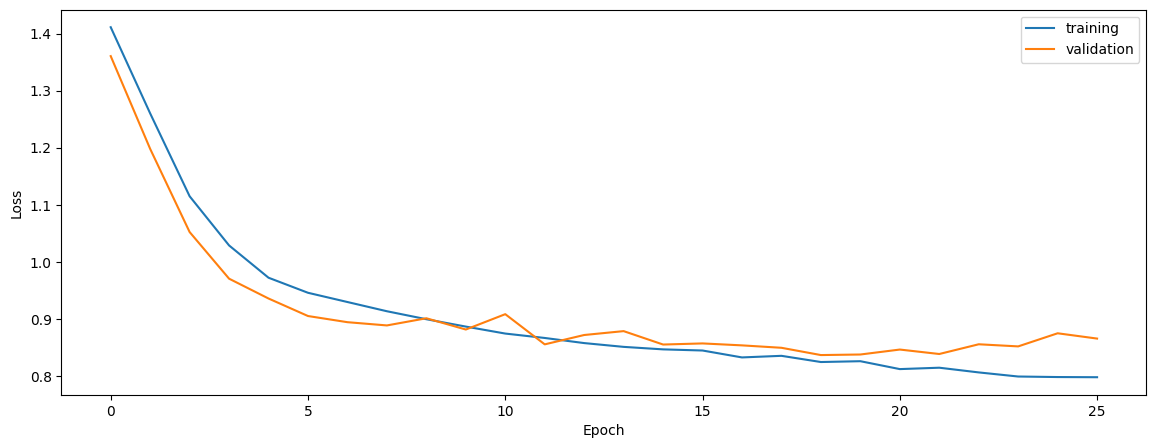

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuracy(train[1],train_pred))
print(getAccuracy(val[1],val_pred))
print(getAccuracy(test[1],test_pred))

train
0.6799141274238227
0.6742034400112787
0.6394394110985278


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuracy(train2[1],train_pred2))
print(getAccuracy(val2[1],val_pred2))
print(getAccuracy(test2[1],test_pred2))

normalized
0.6799141274238227
0.6742034400112787
0.6394394110985278


In [9]:
print('native')
print(getAccuracy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuracy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuracy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.6850545882828566
0.6869645858691242
0.6499139094420401


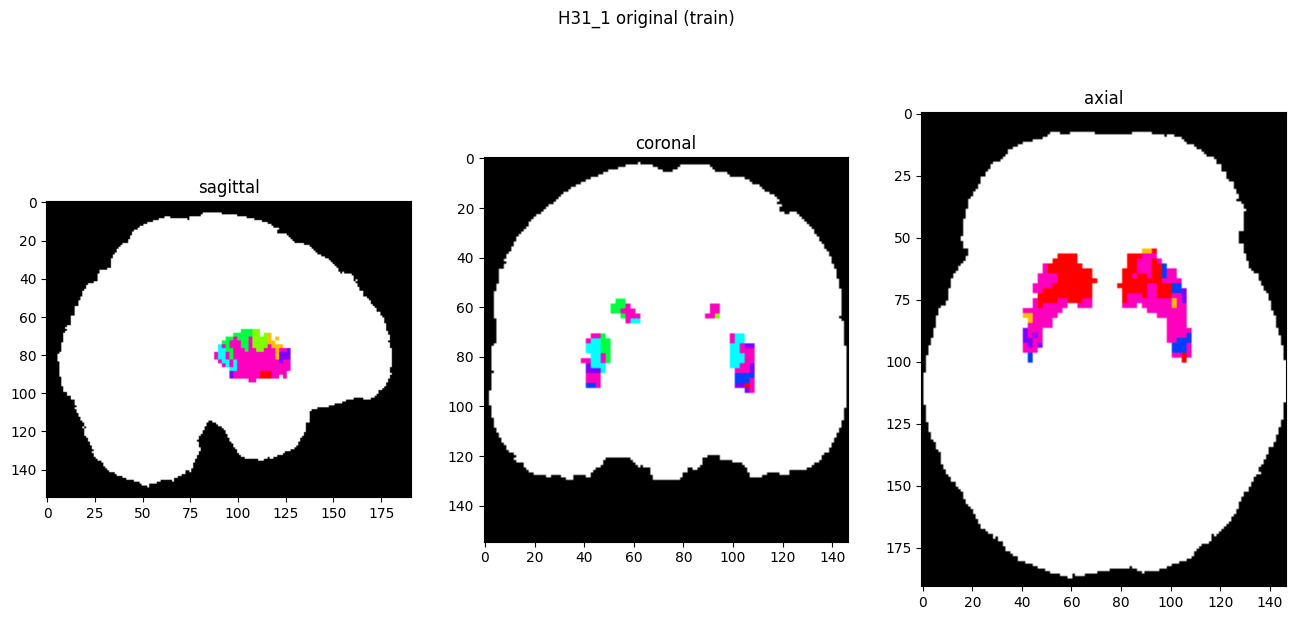

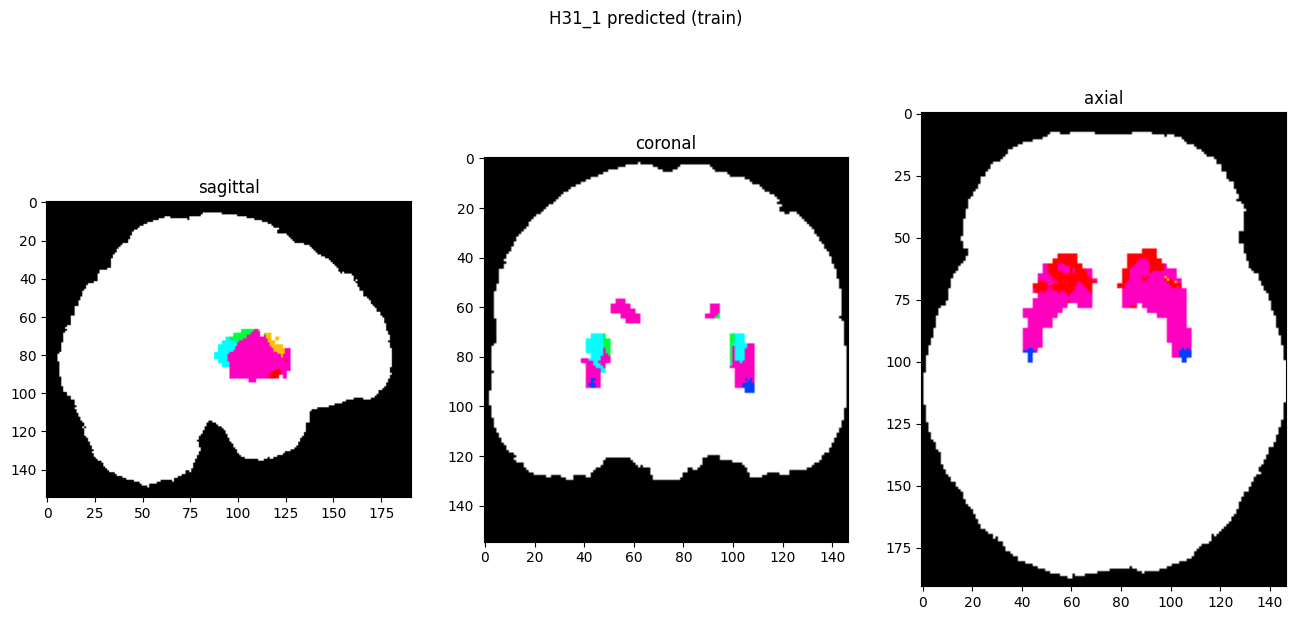

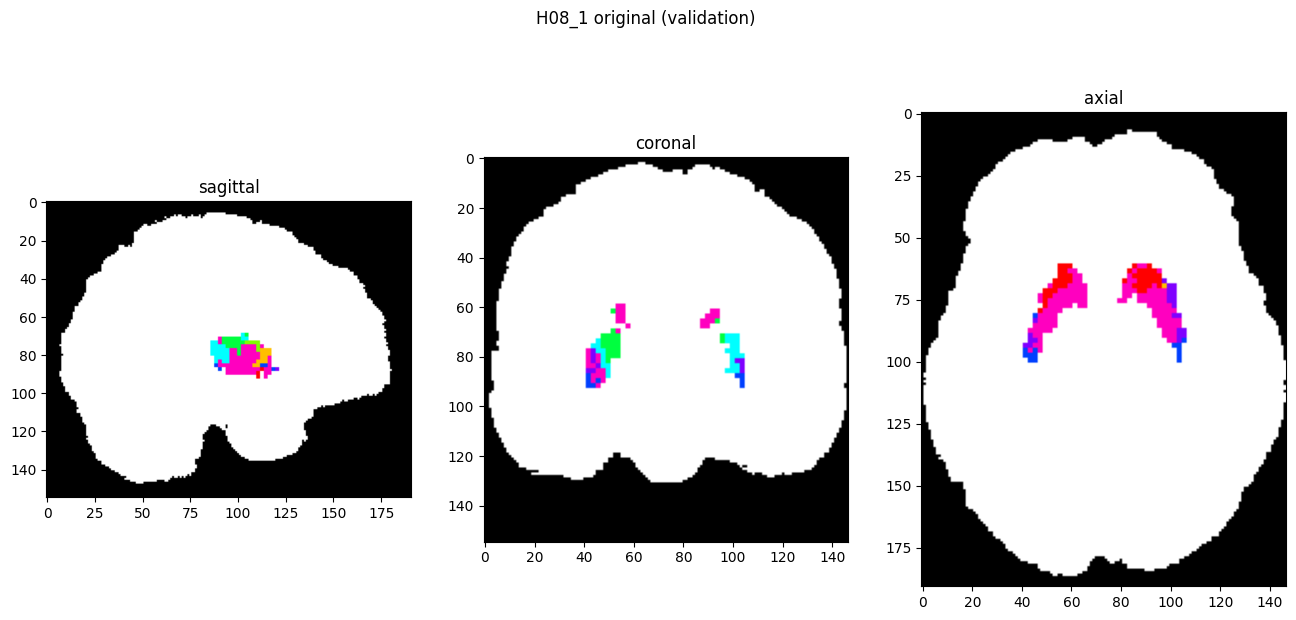

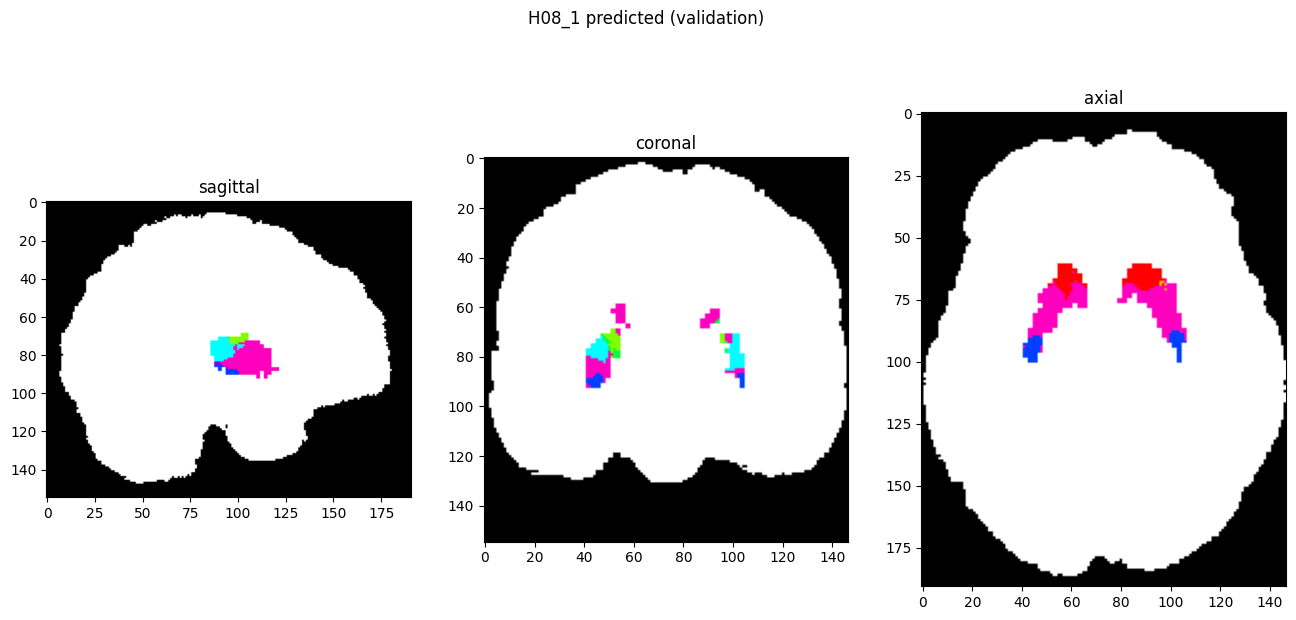

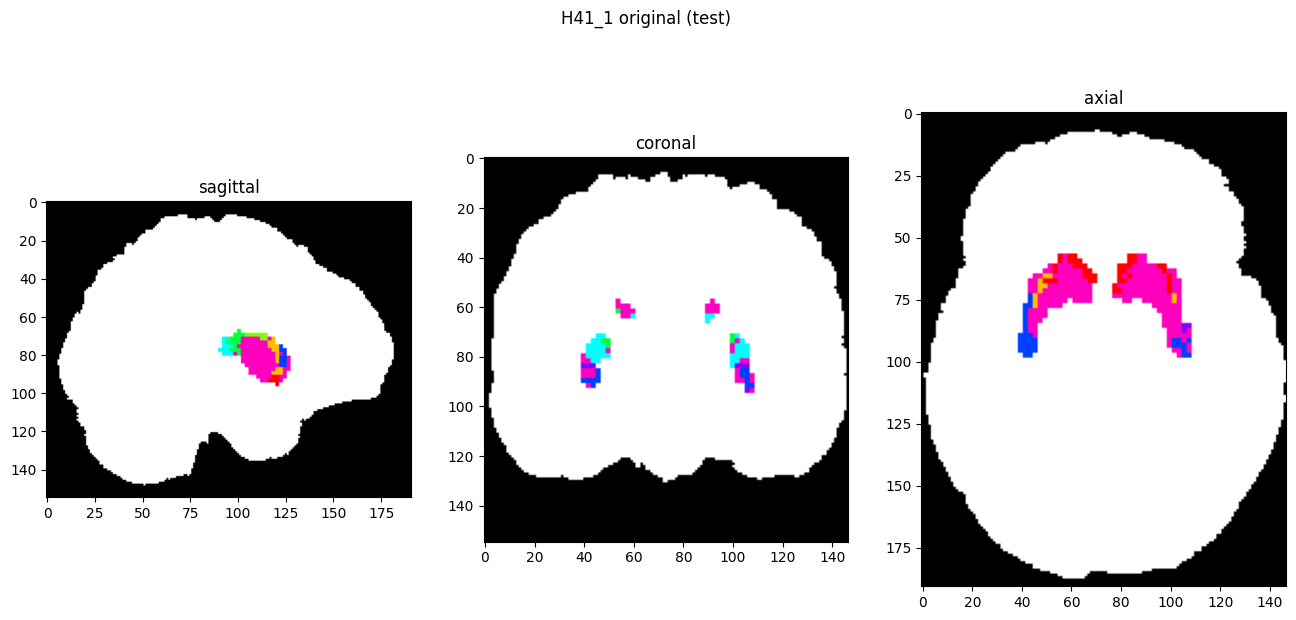

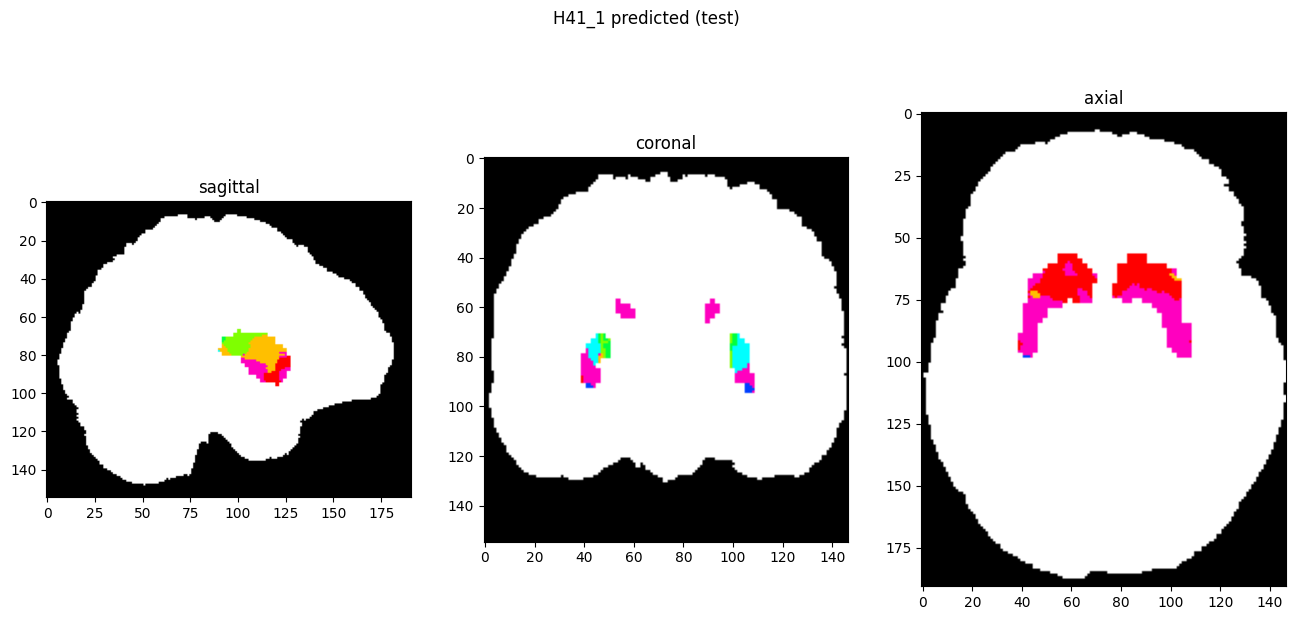

In [10]:
showResults(model, gen, threshold=0)